# MPI calibration of a Grid5000 cluster

## Data extraction

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import numpy
from math import sqrt
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import statsmodels.formula.api as st

archive_name = '../../exp_output/mpi_calibration/grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 64000

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

result = extract_zip(archive_name)

In [2]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808878 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dahu-15.grenoble.grid5000.fr:
    - (172.16.20.15) at 3c:fd:fe:55:ed:60 [ether] on enp24s0f0
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
dahu-15.grenoble.grid5000.

In [3]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

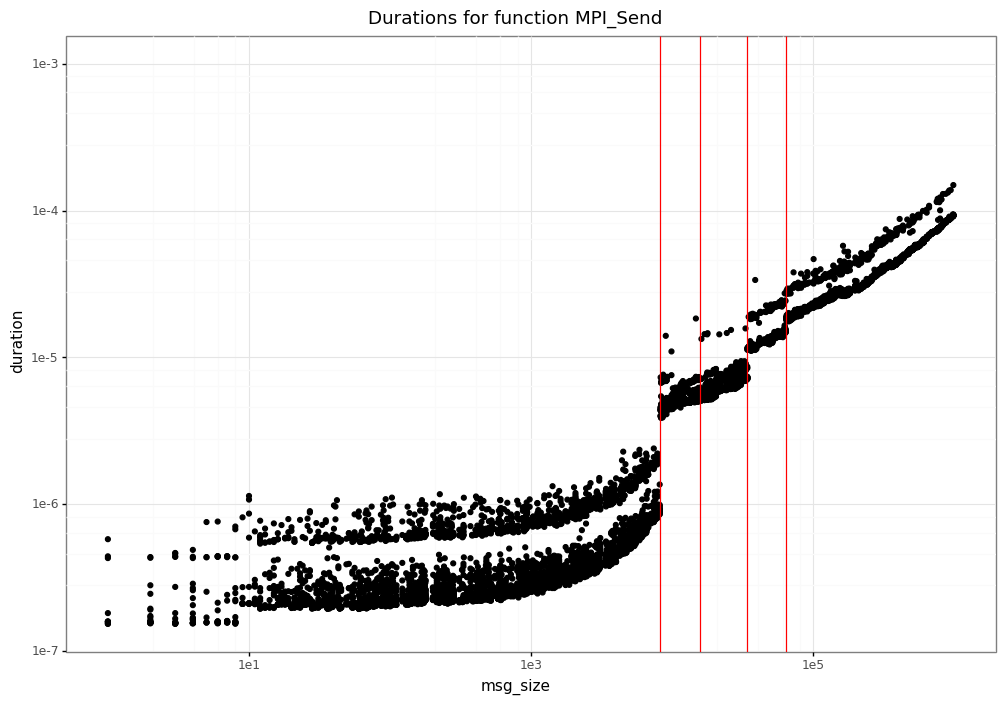

<ggplot: (8742382806746)>


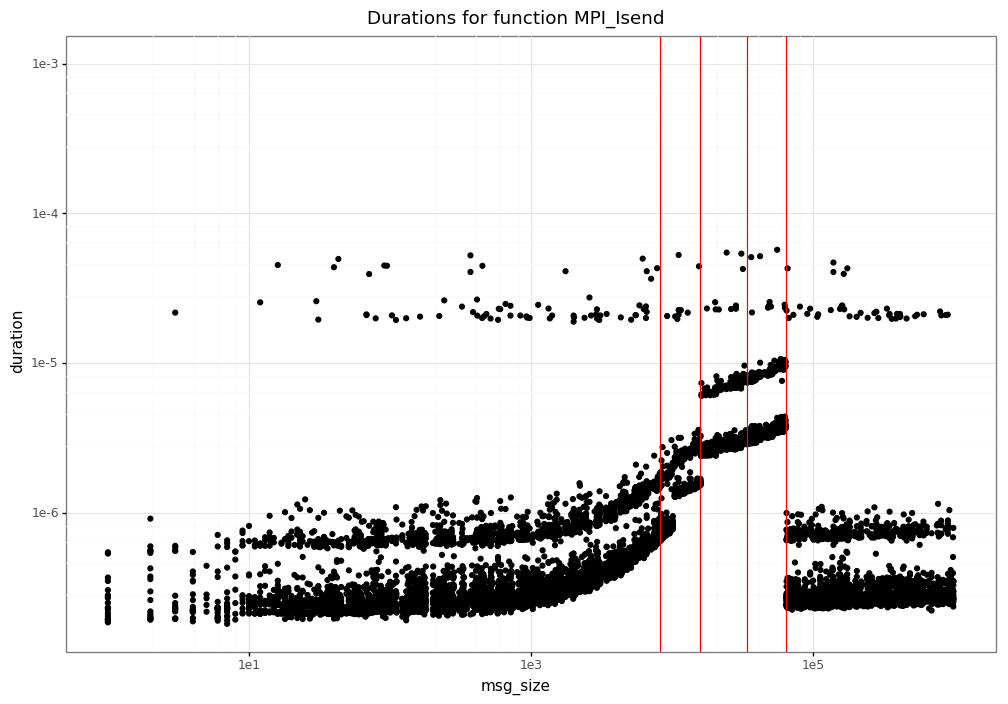

<ggplot: (8742382723283)>


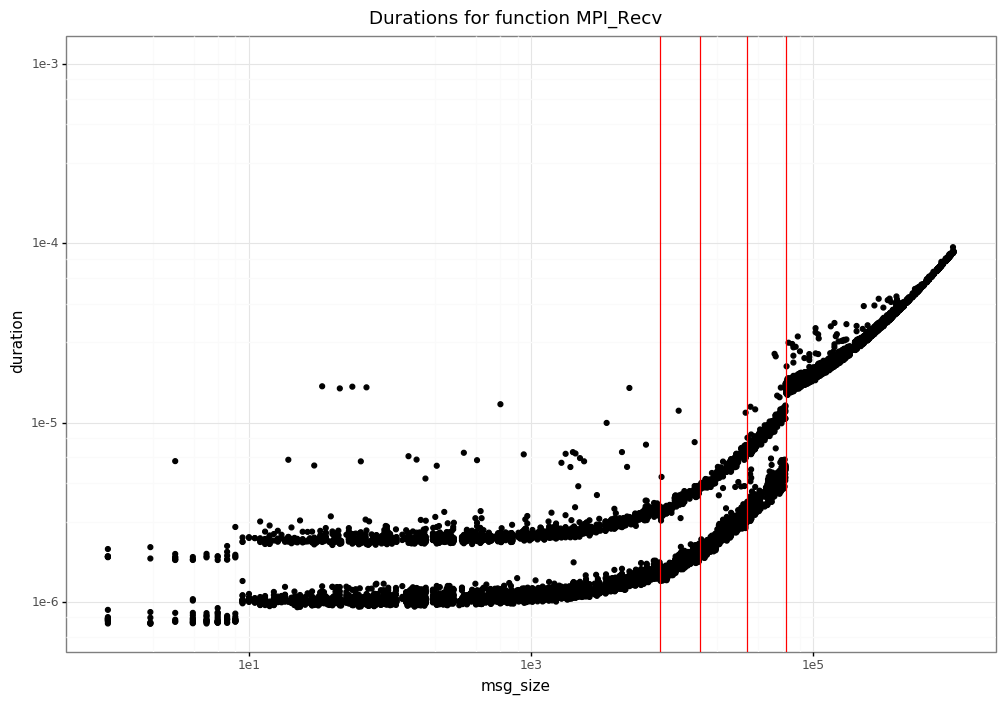

<ggplot: (-9223363294520482367)>


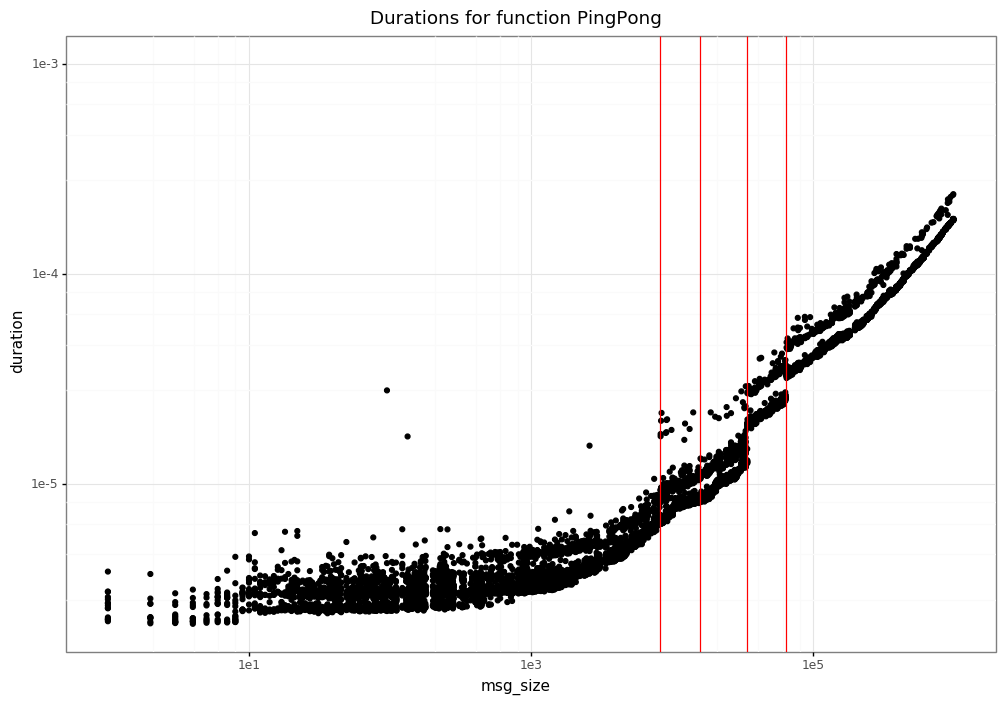

<ggplot: (8742334175983)>


In [4]:
breakpoints = [None, 8133, 15831, 33956, 64000, None]

for df in [df_send, df_isend, df_recv, df_pingpong]:
    plot = ggplot(df.sample(n=10000)) + geom_point(aes(x='msg_size', y='duration')) + theme_bw() + scale_x_log10() + scale_y_log10()
    plot = plot + ggtitle('Durations for function %s' % df['op'].unique()[0]) + expand_limits(y=1e-3)
    for bp in breakpoints[1:-1]:
        plot = plot + geom_vline(xintercept=bp, color='red')
    print(plot)

## Utility classes and functions

In [5]:
class Util:
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other
    def __truediv__(self, other):
        return self * (1/other)
    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return '%s(...)' % self.__class__.__name__

class Normal(Util):
    '''
    Represent a variable following a normal distribution N(μ, σ²)
    '''
    def __init__(self, mu, sigma):
        self.mu = mu
        assert sigma >= 0
        self.sigma = sigma
        self.half = False

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            if self.sigma == 0:
                return str(self.mu)
            return 'N(%s, %s)' % (self.mu, self.sigma)

    def to_tex(self):
        if self.sigma == 0:
            return self.number_to_tex(self.mu, digits=4)
        return r'\mathcal{N}\left(%s, %s\right)' % (self.number_to_tex(self.mu, digits=4), self.number_to_tex(self.sigma, digits=4))

    def __add__(self, other):
        '''
        https://fr.wikipedia.org/wiki/Loi_normale#Stabilit%C3%A9s_et_famille_normale
        '''
        try:
            mu = self.mu + other.mu
            sigma = sqrt(self.sigma**2 + other.sigma**2)
        except AttributeError:
            mu = self.mu + other
            sigma = self.sigma
        return Normal(mu, sigma)

    def __mul__(self, other):
        return Normal(self.mu*other, self.sigma*sqrt(abs(other)))

    def __neg__(self):
        return Normal(-self.mu, self.sigma)
    
    def sample(self):
        if self.half:
            sigma = self.sigma/sqrt(1-2/numpy.pi)
            mu = self.mu - sigma*sqrt(2/numpy.pi)
            return mu + abs(numpy.random.normal(0, sigma))
        else:
            return numpy.random.normal(self.mu, self.sigma)

    @staticmethod
    def number_to_tex(x, digits=None):
        string = '%e' if digits is None else '%.{}e'.format(digits)
        string = string % x
        exp_i = string.index('e')
        coefficient = string[:exp_i]
        exponent = int(string[exp_i+1:])
        return r'%s\mathrm{e}{%d}' % (coefficient, exponent)

    def to_c(self, variable_name):
        if self.sigma > 0:
            return '%s = random_halfnormal_shifted(%e, %e);' % (variable_name, self.mu, self.sigma)
        else:
            return '%s = %e;' % (variable_name, self.mu)
    
dist = Normal(12, 5)
x = [dist.sample() for _ in range(1000)]
assert min(x) < -2
print(min(x), numpy.mean(x), numpy.std(x))
dist.half = True
x = [dist.sample() for _ in range(1000)]
assert min(x) > 5
print(min(x), numpy.mean(x), numpy.std(x))
print(Normal(1, 2) - Normal(3, 4))
print([Normal(1, 2).sample() for _ in range(5)])
x = Normal(3, 3)
print(x+x)
print(x*2)

class LinearRegression(Util):
    '''
    Represent a linear relation of the form y ~ αx + β
    Note that both α and β can be of any type, including random variables.
    '''
    def __init__(self, intercept, coefficient):
        if isinstance(intercept, (int, float)):
            intercept = Normal(intercept, 0)
        if isinstance(coefficient, (int, float)):
            coefficient = Normal(coefficient, 0)
        self.intercept = intercept
        self.coefficient = coefficient

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return 'Y ~ %sX + %s' % (self.coefficient, self.intercept)

    def to_tex(self):
        result =  r'Y \sim \alpha X + \beta\\'
        result += r'\alpha \sim %s\\' % self.coefficient.to_tex()
        result += r'\beta \sim %s\\' % self.intercept.to_tex()
        return result.replace(r'\\', '\\\\\n')

    def __add__(self, other):
        try:
            intercept = self.intercept + other.intercept
            coefficient = self.coefficient + other.coefficient
        except AttributeError:  # adding a constant
            intercept = self.intercept + other
            coefficient = self.coefficient
        return LinearRegression(intercept, coefficient)

    def __mul__(self, other):
        return LinearRegression(self.intercept*other, self.coefficient*other)

    def __neg__(self):
        return LinearRegression(-self.intercept, -self.coefficient)

    def sample(self, x, half=False):
        return self.coefficient.sample() * x + self.intercept.sample()

    def to_c(self, intercept_name, coefficient_name):
        return '\n'.join(variable.to_c(name) for name, variable in [(intercept_name, self.intercept), (coefficient_name, self.coefficient)])

print(LinearRegression(Normal(1, 1), 5) + 3*LinearRegression(Normal(1, 2), Normal(3, 4)))
print([LinearRegression(Normal(1, 0.5), 5).sample(i) for i in range(5)])
print(LinearRegression(Normal(1, 0.5), 5).to_c('intercept_smpi', 'coefficient_smpi'))

-4.312066981282566 11.928152722251935 5.1802283786851495
5.397657985282714 11.968245677965268 5.161727465498158


<IPython.core.display.Math object>


[2.2805827474051927, 0.4889455309912182, 0.8022335104079188, 3.805410352544589, 1.343334398474421]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


[1.2824652850984177, 4.7920451175555066, 10.420296323391153, 15.620146831166041, 20.526036798982283]
intercept_smpi = random_halfnormal_shifted(1.000000e+00, 5.000000e-01);
coefficient_smpi = 5.000000e+00;


In [6]:
class Mixture(Util):
    '''
    Represent a variable following a mixture of (any) distribution.
    '''
    def __init__(self, *modes):
        '''
        The argument "modes" has to be a list of couples. The first element of each couple is the distribution, the second argument is a positive weight.
        '''
        self.modes = modes
        self.total_weight = 0
        for couple in self.modes:
            assert len(couple) == 2
            assert couple[1] > 0
            self.total_weight += couple[1]
        self.probabilities = [t[1] / self.total_weight for t in self.modes]

    def __add__(self, other):
        if isinstance(other, self.__class__):
            modes = []
            for dist1, weight1 in self.modes:
                for dist2, weight2 in other.modes:
                    modes.append((dist1 + dist2, weight1 * weight2))
        else:
            modes = [(distribution+other, weight) for distribution, weight in self.modes]
        return Mixture(*modes)

    def __mul__(self, other):  # TODO very inefficient, we could do better
        if abs(other) == 0.5:
            return self/(4*other)
        if not isinstance(other, int):
            raise TypeError('Can only multiply a %s by an integer' % self.__class__.__name__)
        if other < 0:
            other = -other
            base = self.__class__(*[(-distribution, weight) for distribution, weight in self.modes])
        else:
            base = self
        result = base
        if other == 2:  # "smart" computation, we group the equal modes
            modes = []
            for dist, weight in base.modes:
                modes.append((dist+dist, weight**2))
            for i in range(len(base.modes)):
                for j in range(i+1, len(base.modes)):
                    dist1, weight1 = base.modes[i]
                    dist2, weight2 = base.modes[j]
                    modes.append((dist1+dist2, 2*weight1*weight2))
            result = self.__class__(*modes)
        else:  # too lazy to implement it, equal modes are not grouped
            for _ in range(other-1):
                result = result + base
        return result

    def __truediv__(self, other):
        if other != 2:
            raise TypeError('Can only divide a %s by 2' % self.__class__.__name__)
        if len(self.modes) == 1:
            return self.modes[0]/2
        else:  # we assume that self/2 has only 2 modes, otherwise it gets really messy in the computations
            modes = sorted(self.modes, key = lambda t: -t[1])  # modes by decreasing weight
            (yA, wA), (yB, wB) = modes[:2]
            pi_A = wA / self.total_weight
            pi_B = wB / self.total_weight
            assert isinstance(yA, Normal) and isinstance(yB, Normal)
            mu_A, sigma_A = yA.mu, yA.sigma
            mu_B, sigma_B = yB.mu, yB.sigma
            x1 = Normal(mu_A/2, sigma_A/sqrt(2))
            w1 = sqrt(pi_A)
            assert sigma_B >= sigma_A/sqrt(2)
            x2 = Normal(mu_B - mu_A/2, sqrt(sigma_B**2 - sigma_A**2/2))
            w2 = pi_B / w1 / 2
            return Mixture((x1, w1), (x2, w2))

    def __neg__(self):
        return self*(-1)

    def sample(self):
        mode_index = numpy.random.choice(a=len(self.modes), p=self.probabilities)
        return self.modes[mode_index][0].sample()

    def to_tex(self):
        result = []
        for distribution, weight in self.modes:
            result.append(r'%s & \text{ with probability } %s' % (distribution.to_tex(), Normal.number_to_tex(weight/self.total_weight, digits=4)))
        result = '\\\\\n'.join(result)
        return '\\begin{cases}\n%s\\end{cases}' % result

    def to_c(self, variable_name):
        mixtures = []
        for distrib, weight in sorted(self.modes, key=lambda mode: mode[1]):  # printing the modes from less likely to more likely
            assert isinstance(distrib, Normal)
            mixtures.append('{%e, %e, %e}' % (distrib.mu, distrib.sigma, weight/self.total_weight))
        mixtures = ['    ' + m for m in mixtures]
        mixtures = ',\n'.join(mixtures)
        nb_modes = len(self.modes)
        mixture_str = 'double mixtures_%s[%d][3] = {\n%s\n};' % (variable_name, nb_modes, mixtures)
        mixture_str += '\n%s = random_mixture(%d, mixtures_%s);' % (variable_name, nb_modes, variable_name)
        return mixture_str

print([Mixture((Normal(-3, 1), 2), (Normal(5, 1), 1)).sample() for _ in range(5)])
print(Mixture((Normal(12, 3), 2), (Normal(24, 9), 1)) -2*Mixture((Normal(4, 1), 3), (Normal(8, 3), 1)))
print((Mixture((Normal(4, 2), 3), (Normal(6, 3), 1))))
print((Mixture((Normal(4, 2), 3), (Normal(6, 3), 1))*2))
print((Mixture((Normal(4, 2), 3), (Normal(6, 3), 1))*2)/2)  # the standard deviation for the last normal distribution should be greater than what it initially was, this is expected
print(Mixture((Normal(4, 2), 3), (Normal(6, 3), 1)).to_c('intercept'))

[4.606660555508391, -4.076046251906602, 4.545519757697462, -2.310753639417416, 2.788173181449417]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


double mixtures_intercept[2][3] = {
    {6.000000e+00, 3.000000e+00, 2.500000e-01},
    {4.000000e+00, 2.000000e+00, 7.500000e-01}
};
intercept = random_mixture(2, mixtures_intercept);


In [7]:
class SegmentedRegression(Util):
    def __init__(self):
        self.segments = []

    def append(self, regression, min_x, max_x):
        assert len(self.segments) == 0 or min_x == self.segments[-1][2]
        self.segments.append((regression, min_x, max_x))

    def to_tex(self):
        result = []
        for reg, min_x, max_x in self.segments:
            interval_string = ''
            if min_x is not None:
                interval_string += r'%s \leq ' % min_x
            interval_string += 'X'
            if max_x is not None:
                interval_string += r' < %s' % max_x
            result.append('%s\\\\\n%s' % (interval_string, reg.to_tex()))
        return '\\\\\n'.join(result)

    def __add__(self, other):
        result = self.__class__()
        if isinstance(other, self.__class__):
            for (dist1, min_x1, max_x1), (dist2, min_x2, max_x2) in zip(self.segments, other.segments):
                assert min_x1 == min_x2 and max_x1 == max_x2
                result.append(dist1 + dist2, min_x1, max_x1)
        else:
            for distribution, min_x, max_x in self.segments:
                result.append(distribution + other, min_x, max_x)
        return result

    def __mul__(self, other):
        result = self.__class__()
        for distribution, min_x, max_x in self.segments:
            result.append(distribution*other, min_x, max_x)
        return result

    def __neg__(self):
        return self*(-1)

    def sample(self, x):
        for reg, min_x, max_x in self.segments:
            min_x = min_x or float('-inf')
            max_x = max_x or float('inf')
            if min_x <= x <= max_x:
                return reg.sample(x)
        assert False

    def to_c(self):
        intercept_name = 'smpi_stochastic_intercept'
        coefficient_name = 'smpi_stochastic_coefficient'
        size_name = 'smpi_stochastic_size'
        reg_str = 'double %s=-1, %s=-1;\n' % (intercept_name, coefficient_name)
        for reg, min_x, max_x in self.segments:
            segment_str = reg.to_c(intercept_name, coefficient_name).split('\n')
            segment_str = ['    '+line for line in segment_str]
            segment_str = '\n'.join(segment_str)
            cond = []
            if min_x and abs(min_x) != float('inf'):
                cond.append('%d <= %s' % (min_x, size_name))
            if max_x and abs(max_x) != float('inf'):
                cond.append('%s < %d' % (size_name, max_x))
            cond = ' && '.join(cond) if cond else '1'
            reg_str += 'if(%s) {\n%s\n}\n' % (cond, segment_str)
        return reg_str

    
    def pretty_c(self):
        from IPython.display import Markdown, display
        display(Markdown('```c\n%s\n```' % self.to_c()))

In [8]:
def aggregated_regression(df):
    df_aggr = df.groupby('msg_size')[['duration']].mean().reset_index()
    reg = st.ols(data=df_aggr, formula='duration ~ msg_size').fit()
    df_aggr['pred'] = df_aggr['msg_size'] * reg.params.msg_size + reg.params.Intercept
    plot = ggplot(df_aggr) + geom_point(aes(x='msg_size', y='duration')) + scale_x_log10() + scale_y_log10() + theme_bw() + geom_line(aes(x='msg_size', y='pred'), color='red')
    print(plot + ggtitle('Regression on the aggregated data (averaged per message size)'))
    return reg

def set_groups(df, reg_coeff, intercept_bounds):
    df['intercept_estimate'] = df['duration'] - df['msg_size'] * reg_coeff
    plot = ggplot(df[df.intercept_estimate > 0], aes(x='intercept_estimate')) + geom_histogram(bins=100) + theme_bw()
    plot = plot + scale_x_log10() + scale_y_log10() + ggtitle('Observed intercept (taking a coefficient of %.2e)' % reg_coeff)
    for bound in intercept_bounds:
        plot = plot + geom_vline(xintercept=bound, color='red')
    print(plot)
    df['group'] = 0
    for i, bound in enumerate(intercept_bounds):
        df.loc[df['duration'] > df['msg_size'] * reg_coeff + bound, 'group'] = i+1
    df_sample = df.sample(n=100000) if len(df) > 100000 else df
    plot = ggplot(df_sample) + geom_point(aes(x='msg_size', y='duration', color='factor(group)')) + scale_x_log10() + scale_y_log10() + theme_bw() + ggtitle('Observation of the assigned groups')
    summary = df.groupby('group')[['intercept_estimate']].agg(['mean', 'std', 'count'])
    summary.columns = summary.columns.droplevel()
    summary = summary.reset_index()
    all_intercepts = []
    for _, row in summary.iterrows():
        all_intercepts.append((Normal(row['mean'], row['std']), row['count']))
        x = df_sample.msg_size
        tmp = pandas.DataFrame({'x': x, 'y': x*reg_coeff + row['mean']})
        plot = plot + geom_line(tmp, aes(x='x', y='y'))
    print(plot)
    adhoc_reg = LinearRegression(
                    intercept = Mixture(*all_intercepts),
                    coefficient = reg_coeff,
                )
    return adhoc_reg

def compute_mixture_regression(df, min_x, max_x, intercept_bounds):
    if min_x is not None:
        df = df[df.msg_size > min_x]
    if max_x is not None:
        df = df[df.msg_size < max_x]
    df = df.copy()
    reg = aggregated_regression(df)
    print(reg.summary())
    reg_coeff = max(0, reg.params.msg_size)  # a negative coefficient does not make any sense (may happen with MPI_Irecv)
    adhoc_reg = set_groups(df, reg_coeff, intercept_bounds)
    return adhoc_reg

## Analysis - MPI_Recv

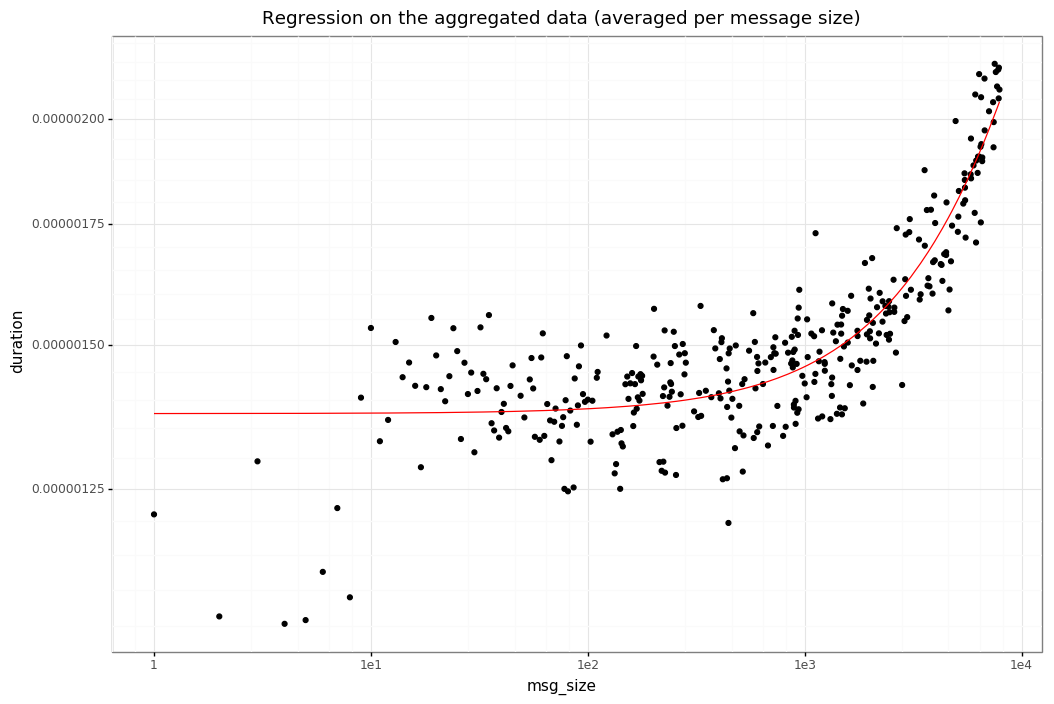

<ggplot: (-9223363294456936781)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1478.
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          7.04e-130
Time:                        14:53:24   Log-Likelihood:                 5404.6
No. Observations:                 364   AIC:                        -1.081e+04
Df Residuals:                     362   BIC:                        -1.080e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.376e-

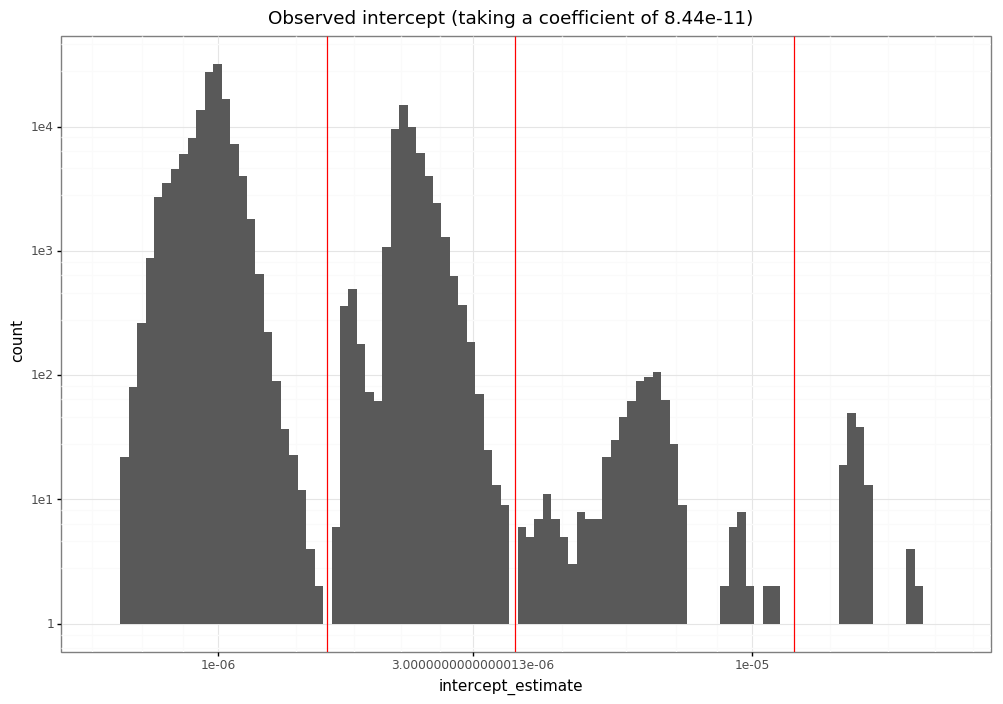

<ggplot: (8742334282367)>


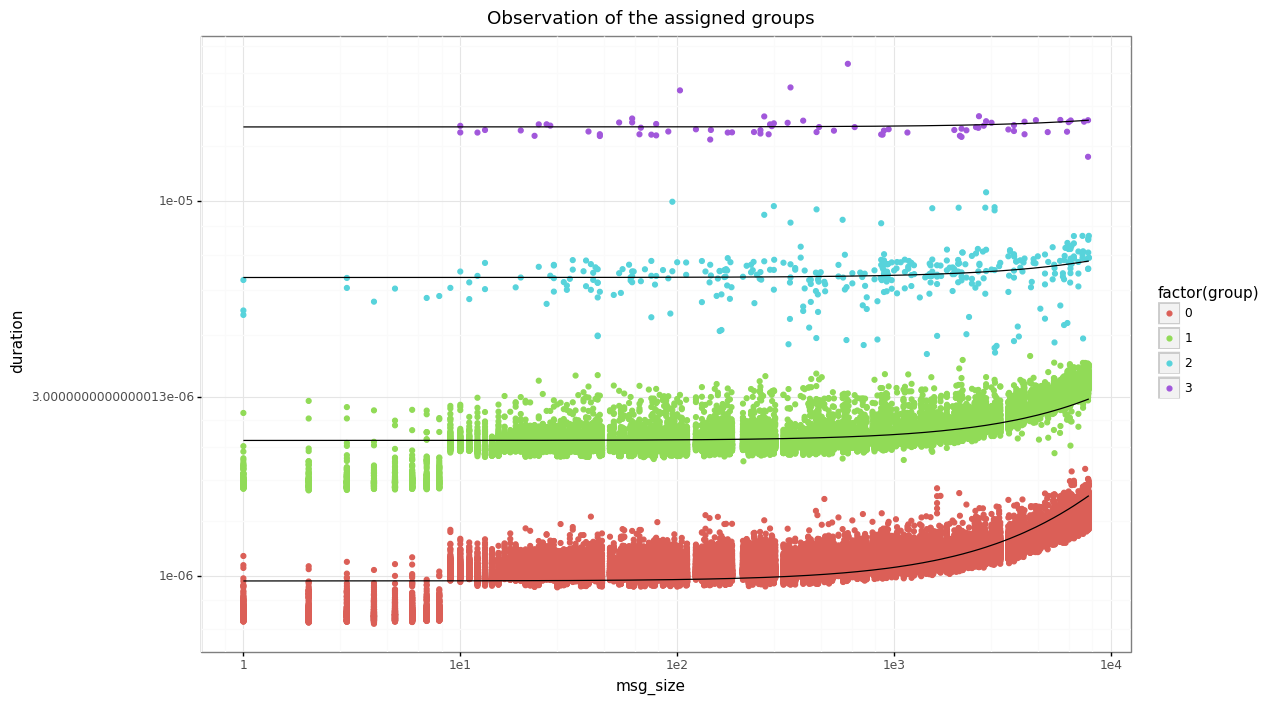

<ggplot: (8742322356975)>


<IPython.core.display.Math object>

In [9]:
regressions_recv = SegmentedRegression()
min_x, max_x = breakpoints[0:2]
adhoc_reg = compute_mixture_regression(df_recv, min_x, max_x, [1.6e-6, 3.6e-6, 1.2e-5])
adhoc_reg

In [10]:
regressions_recv.append(adhoc_reg, min_x, max_x)

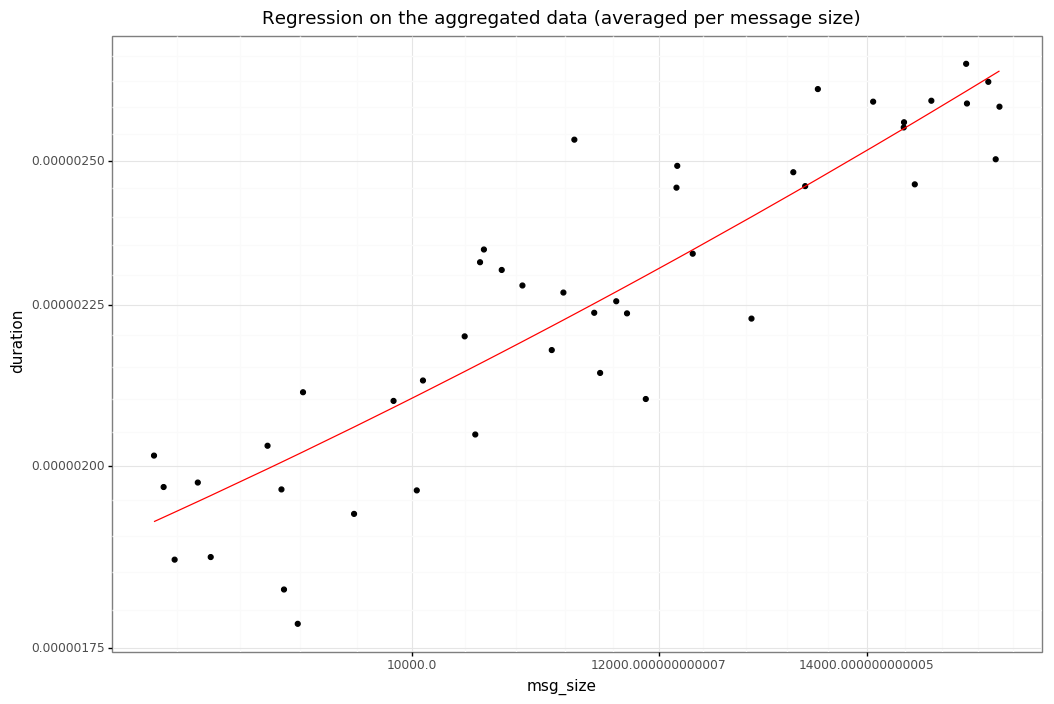

<ggplot: (8742302937085)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     180.7
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           5.37e-17
Time:                        14:53:33   Log-Likelihood:                 656.18
No. Observations:                  45   AIC:                            -1308.
Df Residuals:                      43   BIC:                            -1305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.057e-06   9.

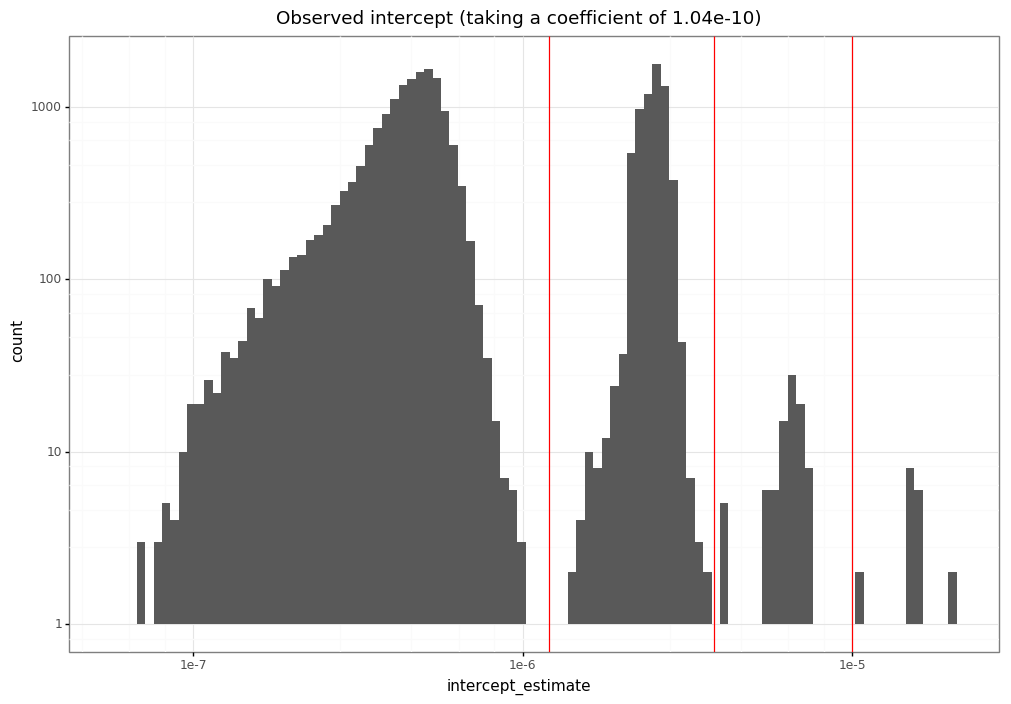

<ggplot: (-9223363294520486077)>


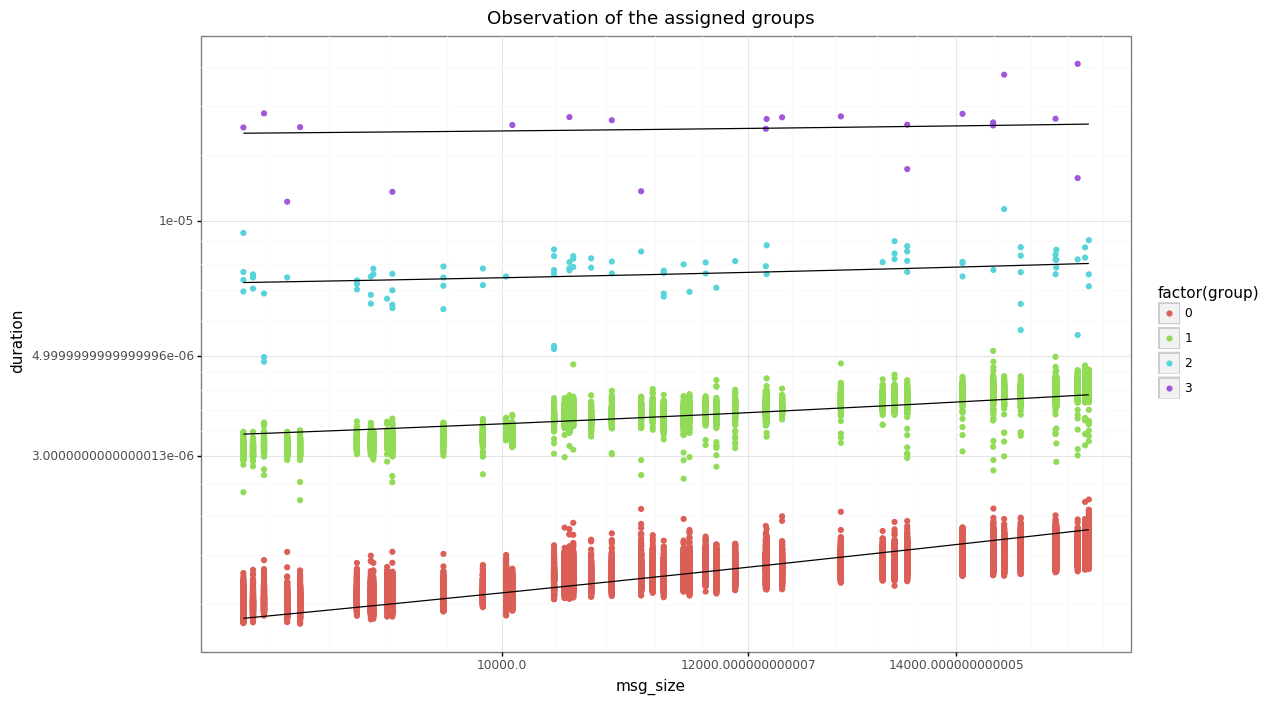

<ggplot: (8742322239706)>


<IPython.core.display.Math object>

In [11]:
min_x, max_x = breakpoints[1:3]
adhoc_reg = compute_mixture_regression(df_recv, min_x, max_x, [1.2e-6, 3.8e-6, 1e-5])
adhoc_reg

In [12]:
regressions_recv.append(adhoc_reg, min_x, max_x)

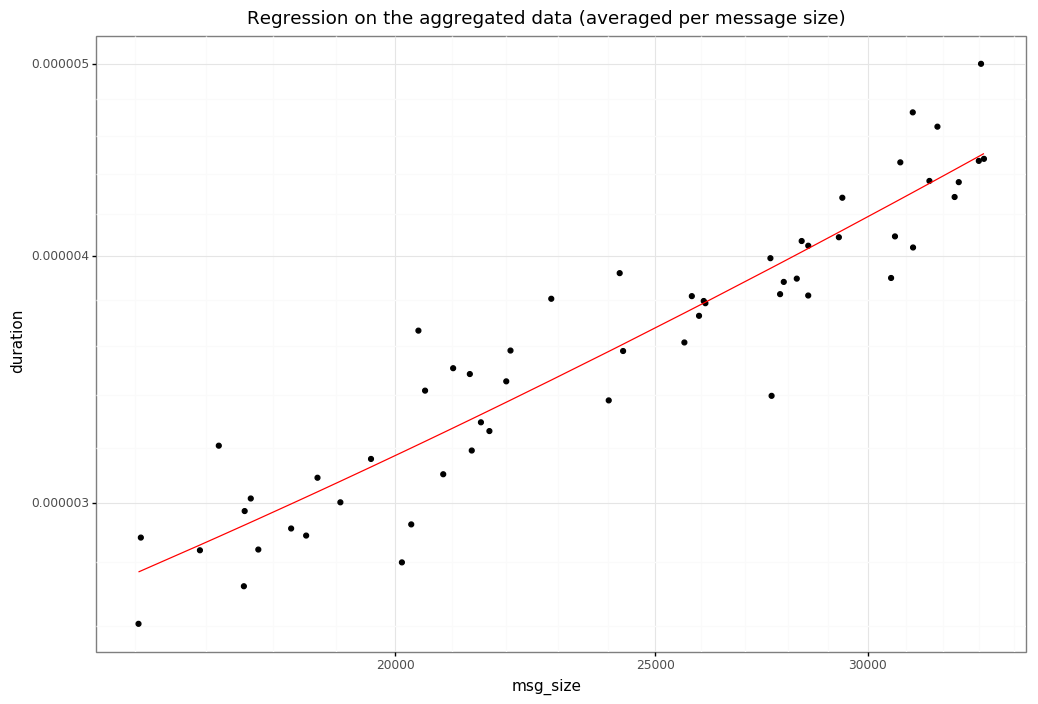

<ggplot: (8742322238945)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     367.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           9.21e-26
Time:                        14:53:36   Log-Likelihood:                 782.80
No. Observations:                  56   AIC:                            -1562.
Df Residuals:                      54   BIC:                            -1558.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.14e-06   1.

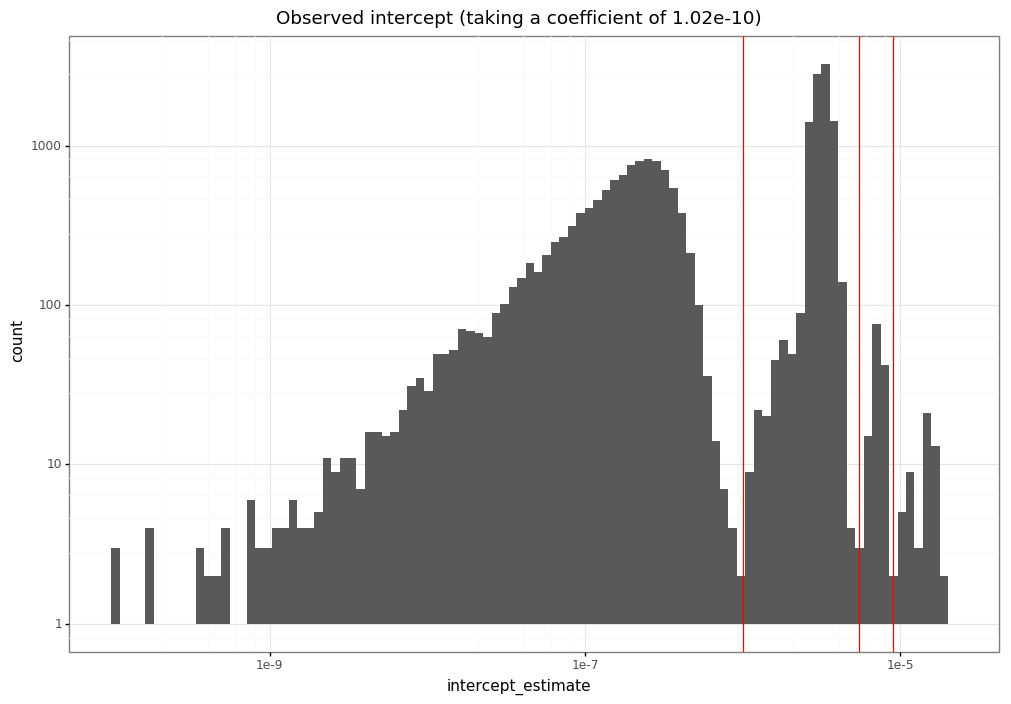

<ggplot: (-9223363294552000750)>


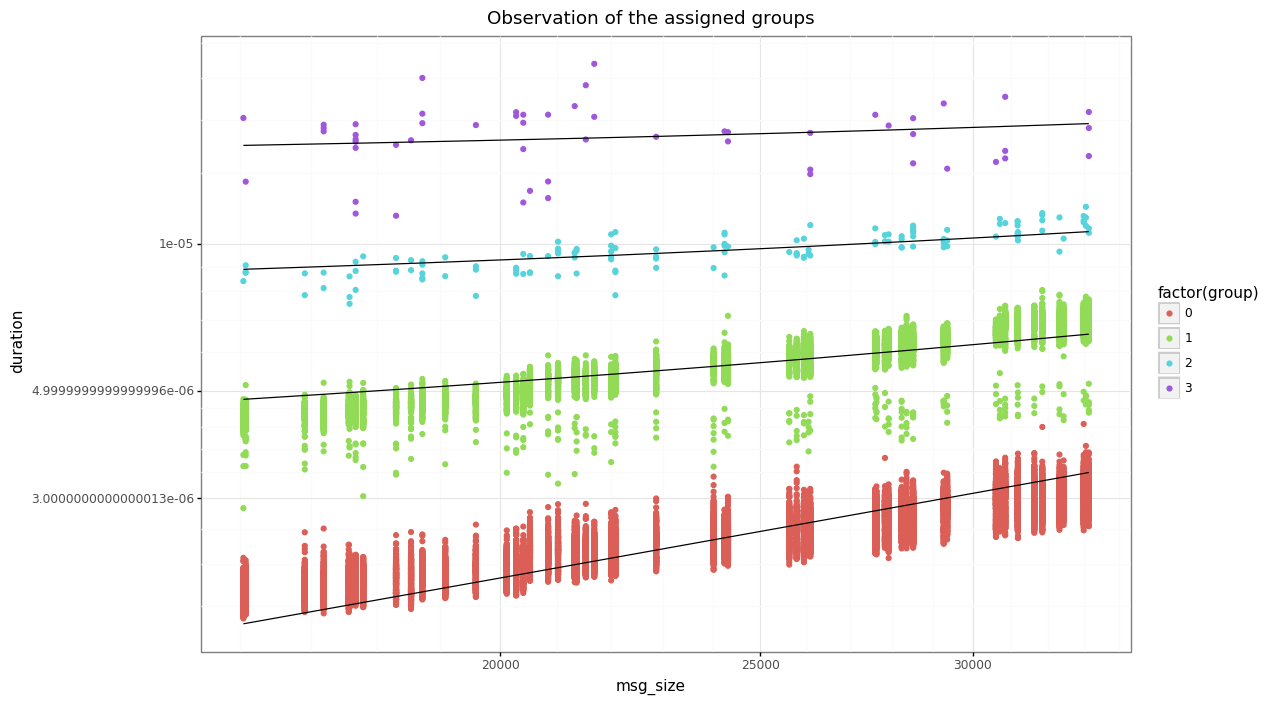

<ggplot: (-9223363294551810949)>


<IPython.core.display.Math object>

In [13]:
min_x, max_x = breakpoints[2:4]
adhoc_reg = compute_mixture_regression(df_recv, min_x, max_x, [1e-6, 5.5e-6, 9e-6])
adhoc_reg

In [14]:
regressions_recv.append(adhoc_reg, min_x, max_x)

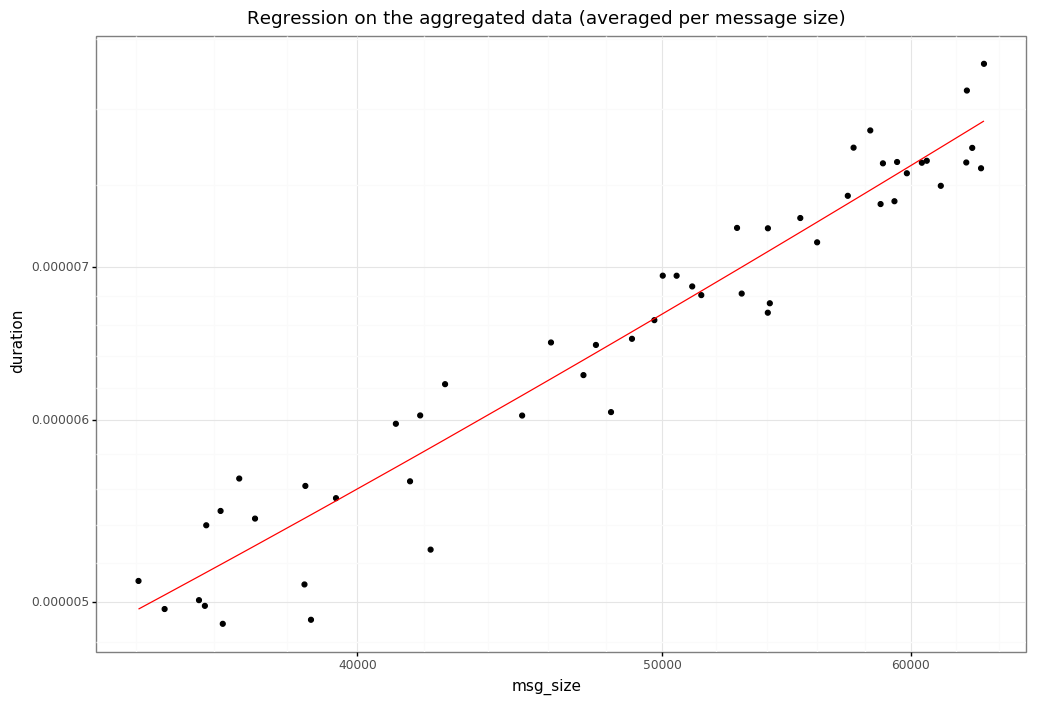

<ggplot: (-9223363294532562151)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     753.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           8.12e-32
Time:                        14:53:40   Log-Likelihood:                 714.56
No. Observations:                  52   AIC:                            -1425.
Df Residuals:                      50   BIC:                            -1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.303e-

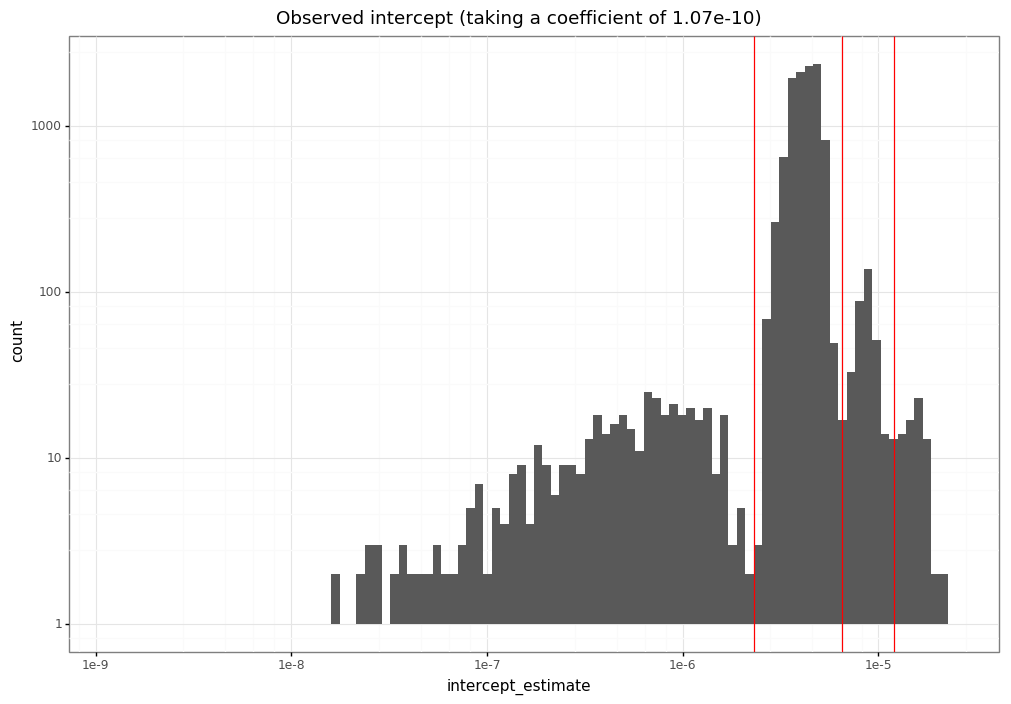

<ggplot: (-9223363294532611710)>


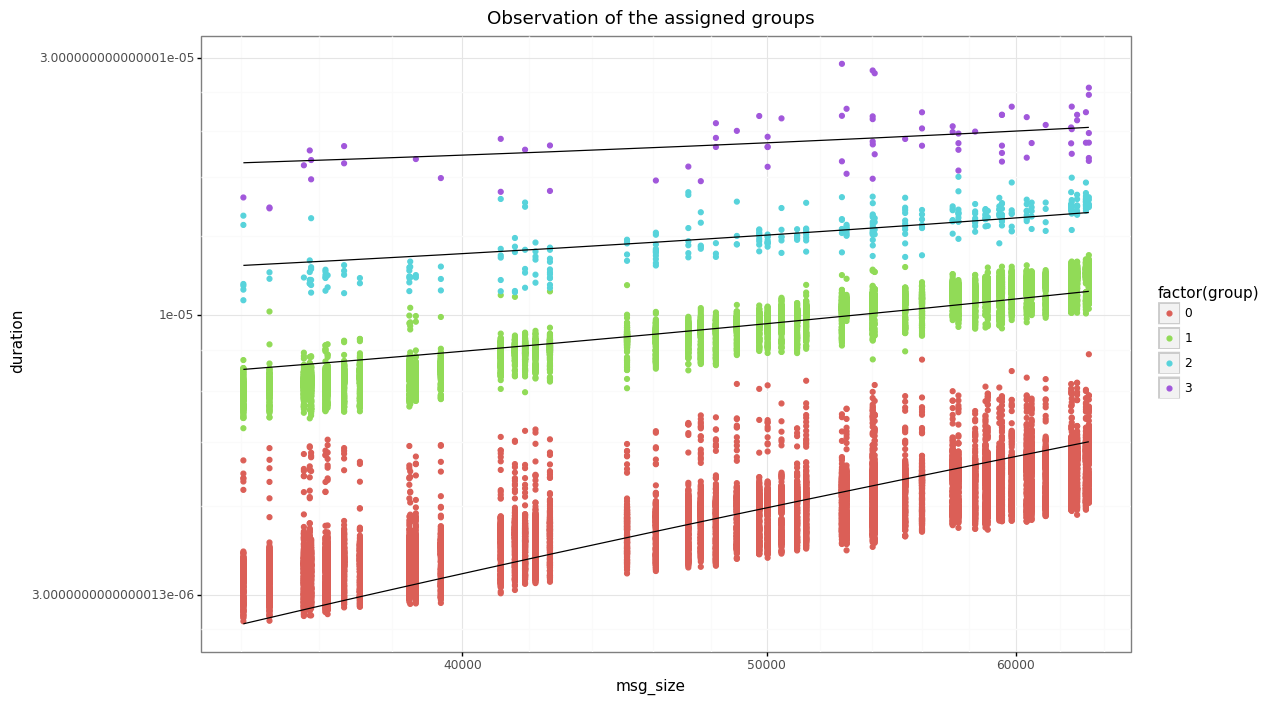

<ggplot: (-9223363294532672887)>


<IPython.core.display.Math object>

In [15]:
min_x, max_x = breakpoints[3:5]
adhoc_reg = compute_mixture_regression(df_recv, min_x, max_x, [2.3e-6, 6.5e-6, 1.2e-5])
adhoc_reg

In [16]:
regressions_recv.append(adhoc_reg, min_x, max_x)

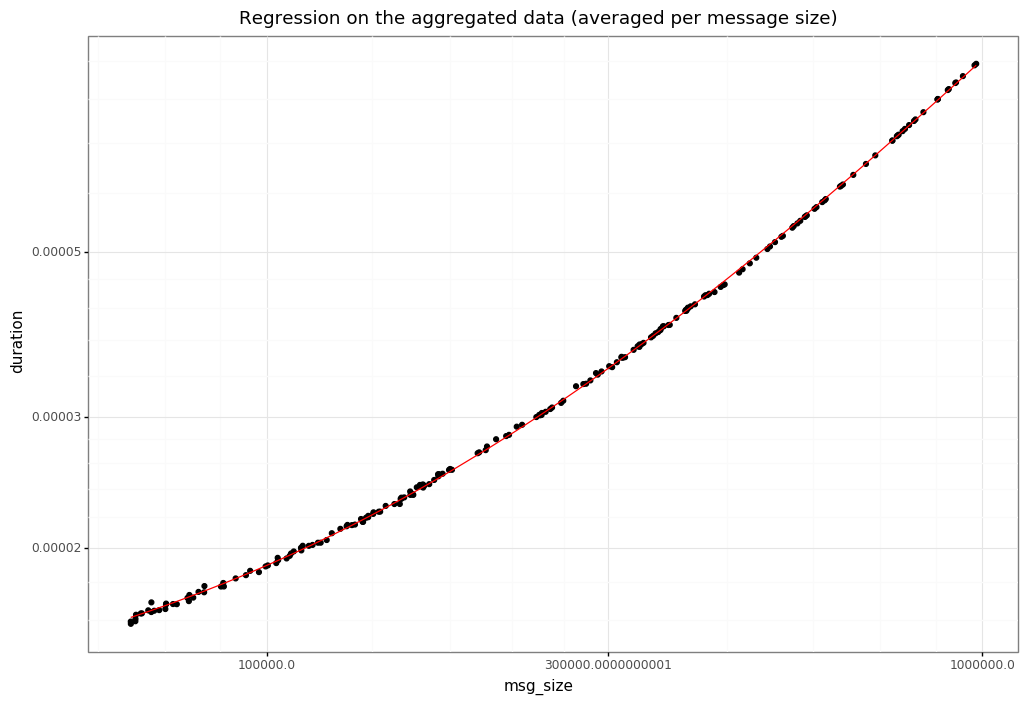

<ggplot: (-9223363294532604430)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.066e+06
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:53:44   Log-Likelihood:                 2869.8
No. Observations:                 204   AIC:                            -5736.
Df Residuals:                     202   BIC:                            -5729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.102e-

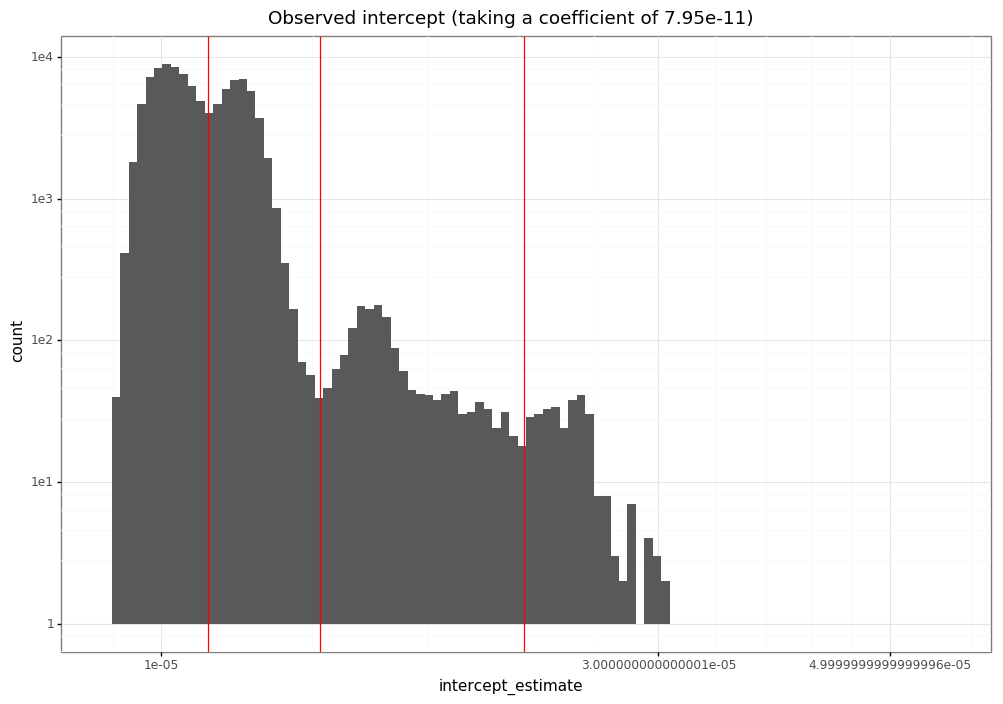

<ggplot: (-9223363294551838797)>


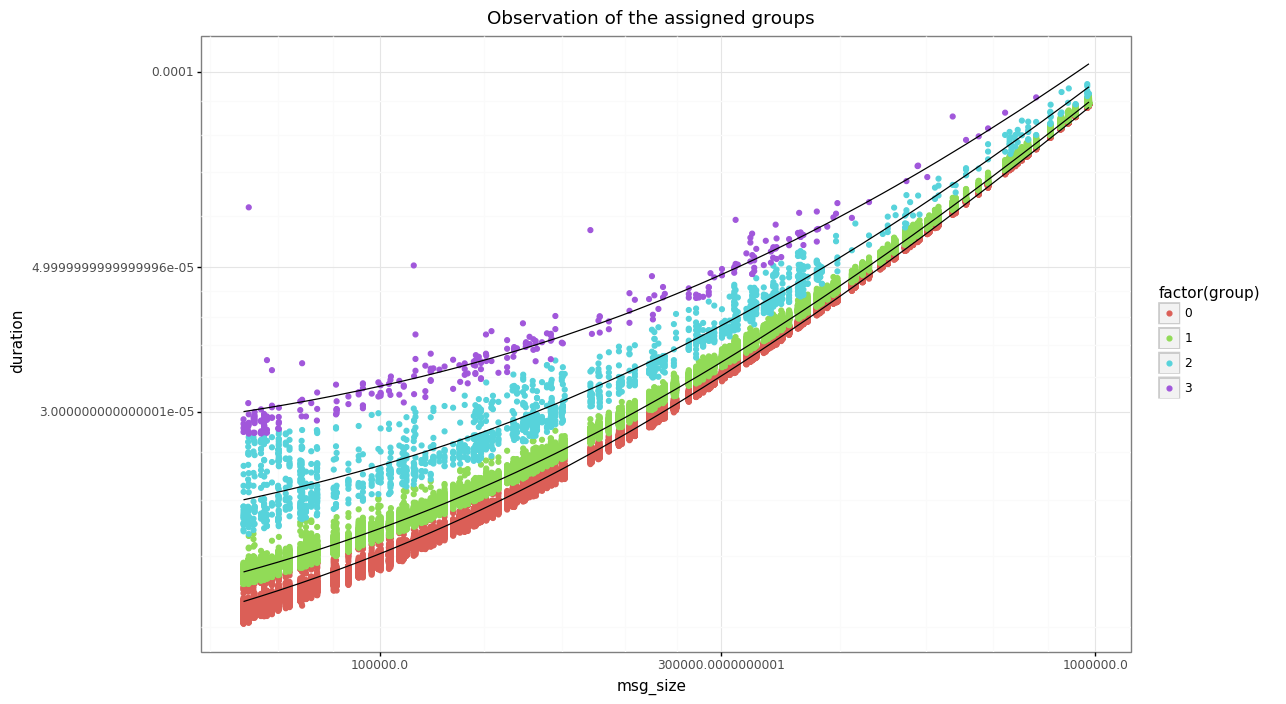

<ggplot: (8742381585672)>


<IPython.core.display.Math object>

In [17]:
min_x, max_x = breakpoints[4:6]
adhoc_reg = compute_mixture_regression(df_recv, min_x, max_x, [1.11e-5, 1.42e-5, 2.23e-5])
adhoc_reg

In [18]:
regressions_recv.append(adhoc_reg, min_x, max_x)

In [19]:
regressions_recv

<IPython.core.display.Math object>

In [20]:
regressions_recv.pretty_c()

```c
double smpi_stochastic_intercept=-1, smpi_stochastic_coefficient=-1;
if(smpi_stochastic_size < 8133) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {1.578858e-05, 1.353790e-06, 7.197802e-04},
        {6.255998e-06, 1.015674e-06, 3.538462e-03},
        {2.297108e-06, 1.768100e-07, 2.844286e-01},
        {9.681853e-07, 8.229993e-08, 7.113132e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 8.443925e-11;
}
if(8133 <= smpi_stochastic_size && smpi_stochastic_size < 15831) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {1.480942e-05, 2.686375e-06, 9.777778e-04},
        {6.427250e-06, 8.791199e-07, 4.088889e-03},
        {2.489158e-06, 2.181154e-07, 2.819111e-01},
        {4.415818e-07, 1.243068e-07, 7.130222e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.044152e-10;
}
if(15831 <= smpi_stochastic_size && smpi_stochastic_size < 33956) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {1.434377e-05, 2.540300e-06, 1.964286e-03},
        {7.252870e-06, 5.616525e-07, 4.892857e-03},
        {3.168695e-06, 4.400812e-07, 3.339286e-01},
        {2.804051e-08, 2.379107e-07, 6.592143e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.015274e-10;
}
if(33956 <= smpi_stochastic_size && smpi_stochastic_size < 64000) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {1.550638e-05, 2.360998e-06, 3.000000e-03},
        {8.684909e-06, 9.668691e-07, 1.303846e-02},
        {4.243792e-06, 6.296865e-07, 4.060769e-01},
        {-1.003977e-06, 5.748014e-07, 5.778846e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.074226e-10;
}
if(64000 <= smpi_stochastic_size) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {2.489976e-05, 2.892017e-06, 2.990196e-03},
        {1.685468e-05, 1.875655e-06, 1.577451e-02},
        {1.190200e-05, 4.715726e-07, 3.903431e-01},
        {1.021040e-05, 4.376536e-07, 5.908922e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 7.945817e-11;
}

```

## Analysis - MPI_Send

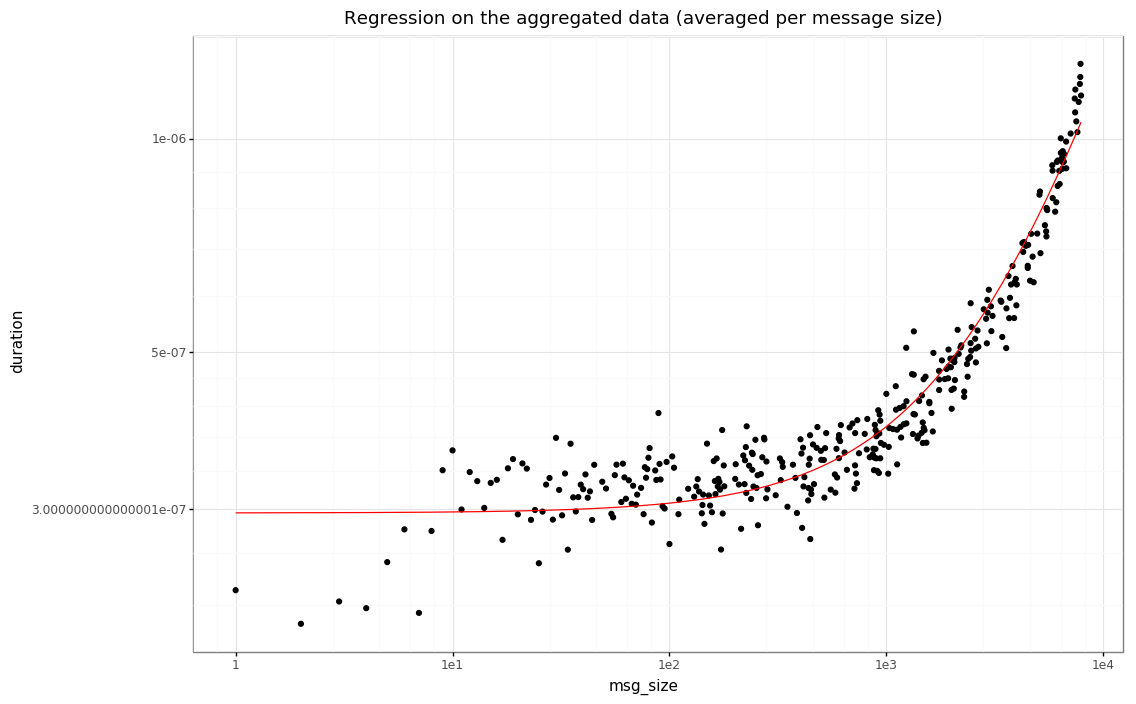

<ggplot: (8742322239685)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     7092.
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          7.26e-240
Time:                        14:53:53   Log-Likelihood:                 5642.1
No. Observations:                 364   AIC:                        -1.128e+04
Df Residuals:                     362   BIC:                        -1.127e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.966e-07     

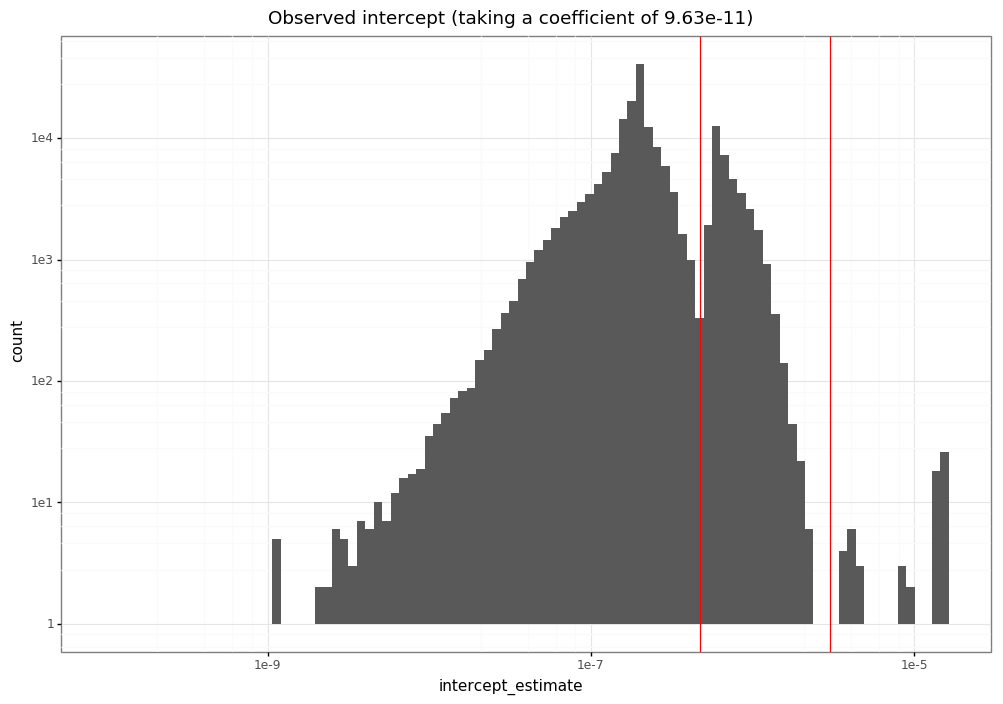

<ggplot: (8742322319259)>


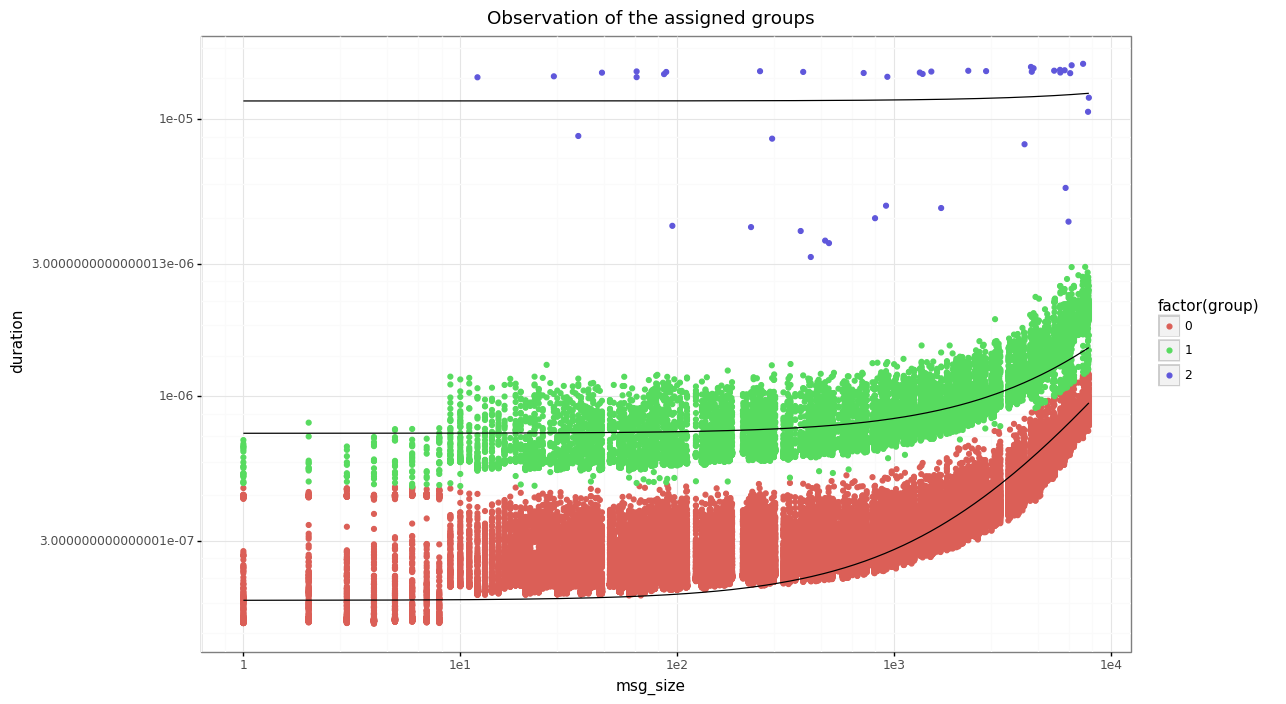

<ggplot: (8742302472242)>


<IPython.core.display.Math object>

In [21]:
regressions_send = SegmentedRegression()
min_x, max_x = breakpoints[0:2]
adhoc_reg = compute_mixture_regression(df_send, min_x, max_x, [4.7e-7, 3e-6])
adhoc_reg

In [22]:
regressions_send.append(adhoc_reg, min_x, max_x)

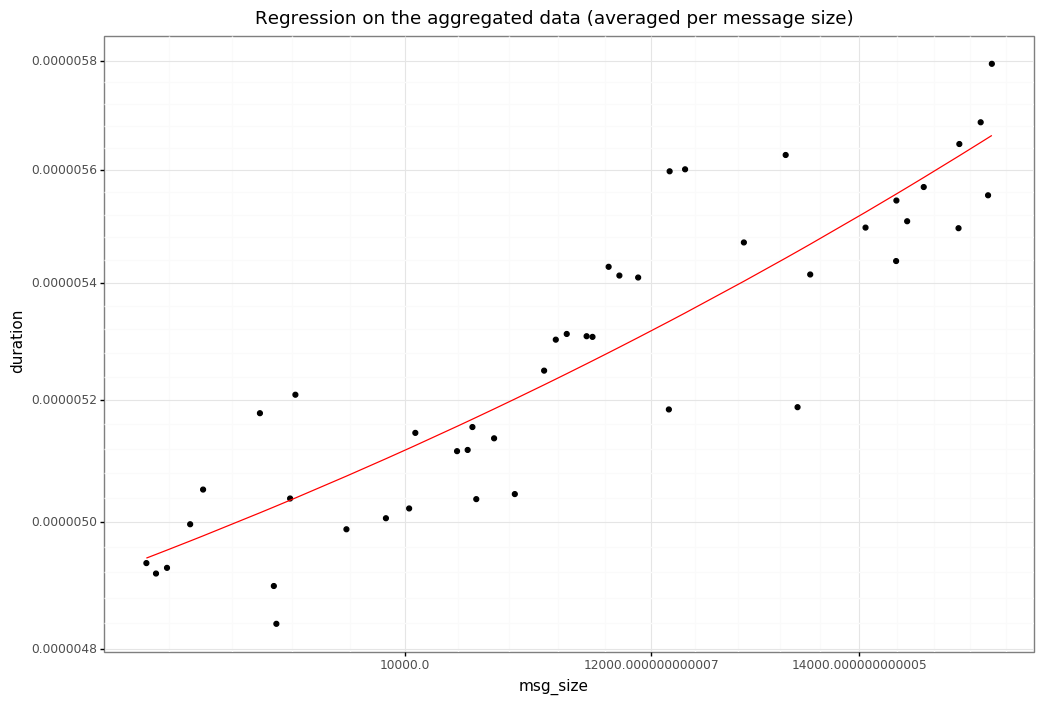

<ggplot: (-9223363294552763511)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     162.0
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           3.54e-16
Time:                        14:54:02   Log-Likelihood:                 655.56
No. Observations:                  45   AIC:                            -1307.
Df Residuals:                      43   BIC:                            -1304.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.115e-

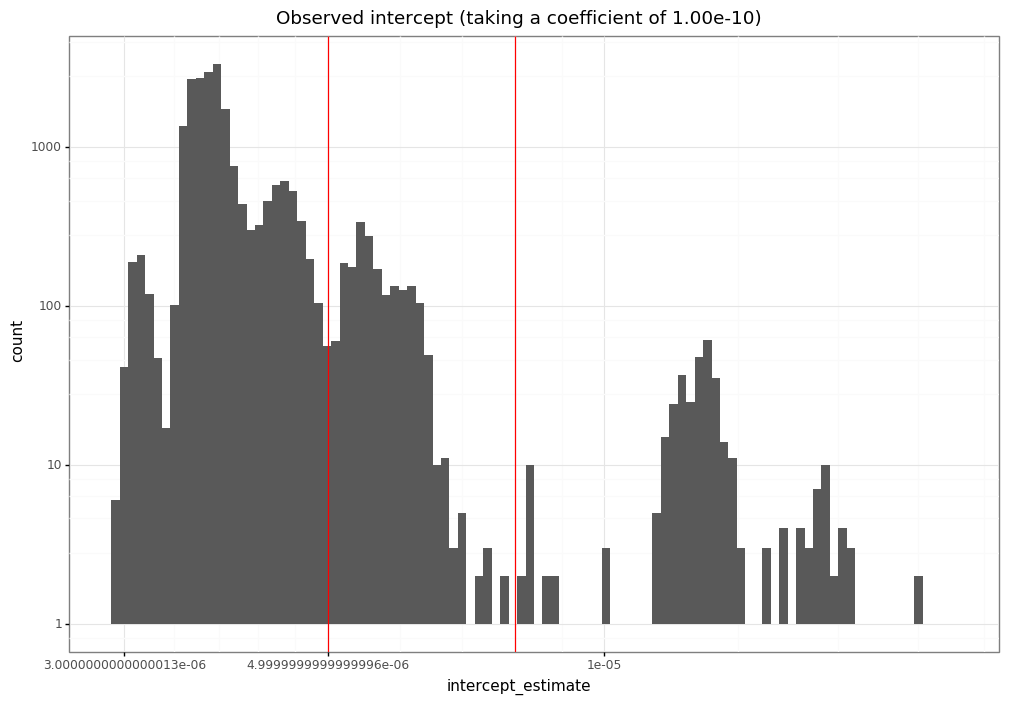

<ggplot: (8742302015773)>


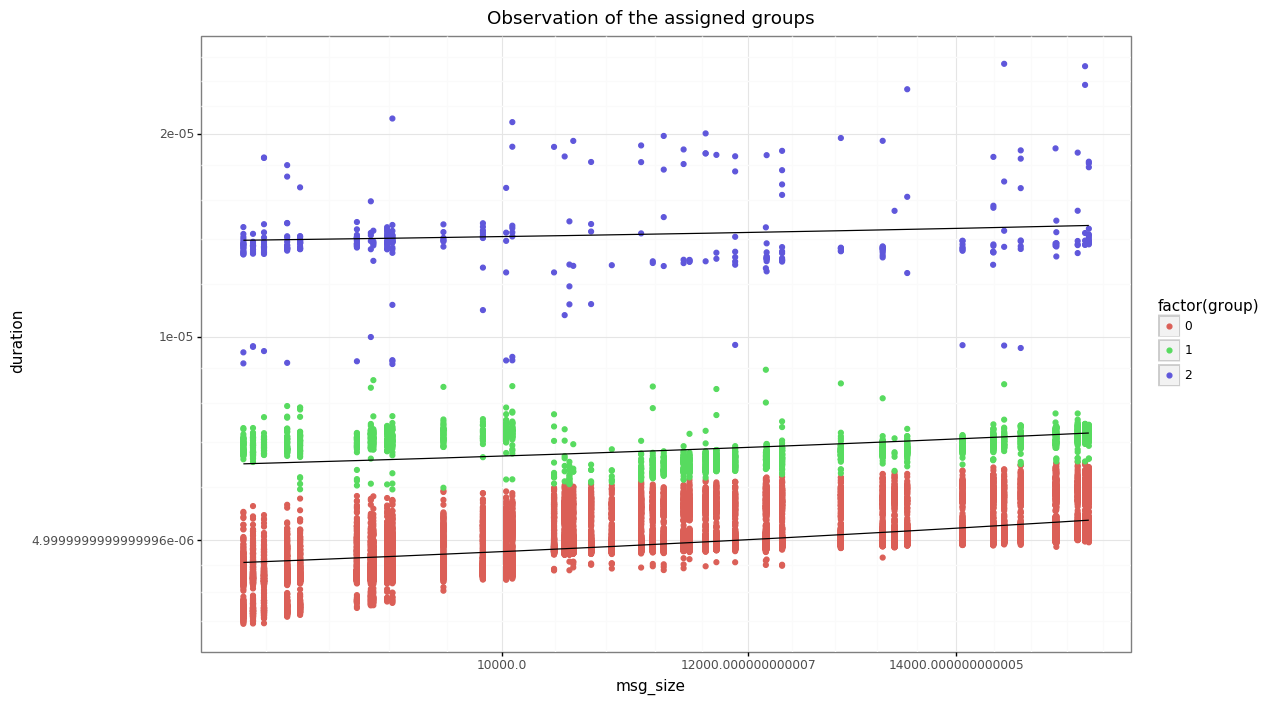

<ggplot: (-9223363294472000340)>


<IPython.core.display.Math object>

In [23]:
min_x, max_x = breakpoints[1:3]
adhoc_reg = compute_mixture_regression(df_send, min_x, max_x, [5e-6, 8e-6])
adhoc_reg

In [24]:
regressions_send.append(adhoc_reg, min_x, max_x)

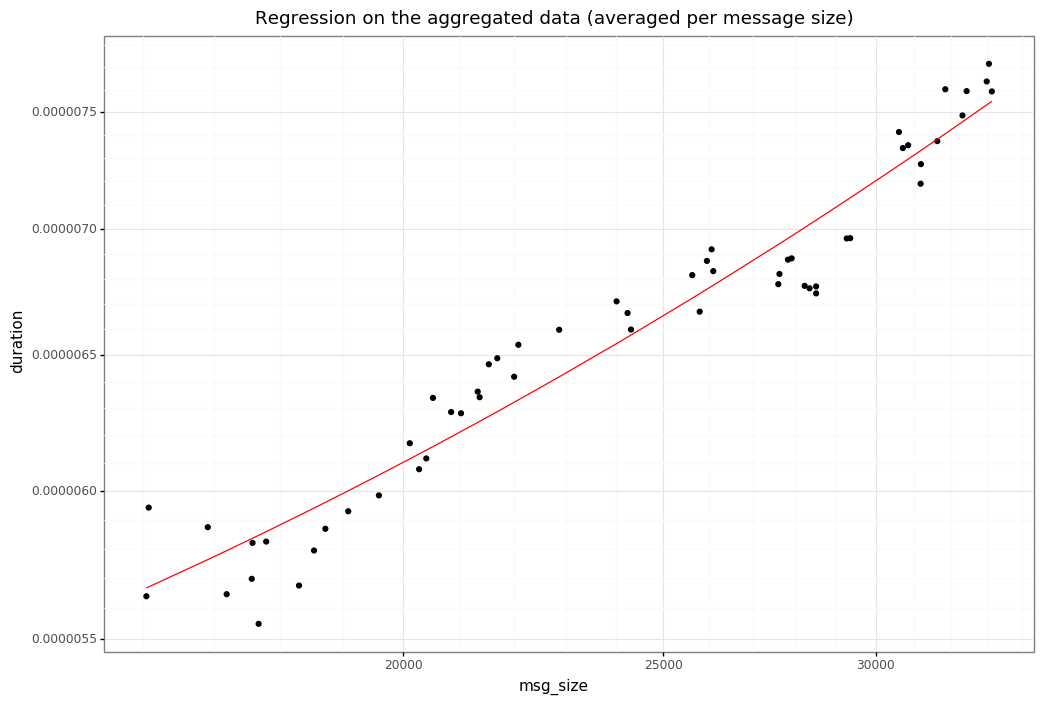

<ggplot: (8742302973290)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     863.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           6.83e-35
Time:                        14:54:06   Log-Likelihood:                 802.23
No. Observations:                  56   AIC:                            -1600.
Df Residuals:                      54   BIC:                            -1596.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.903e-06   9.

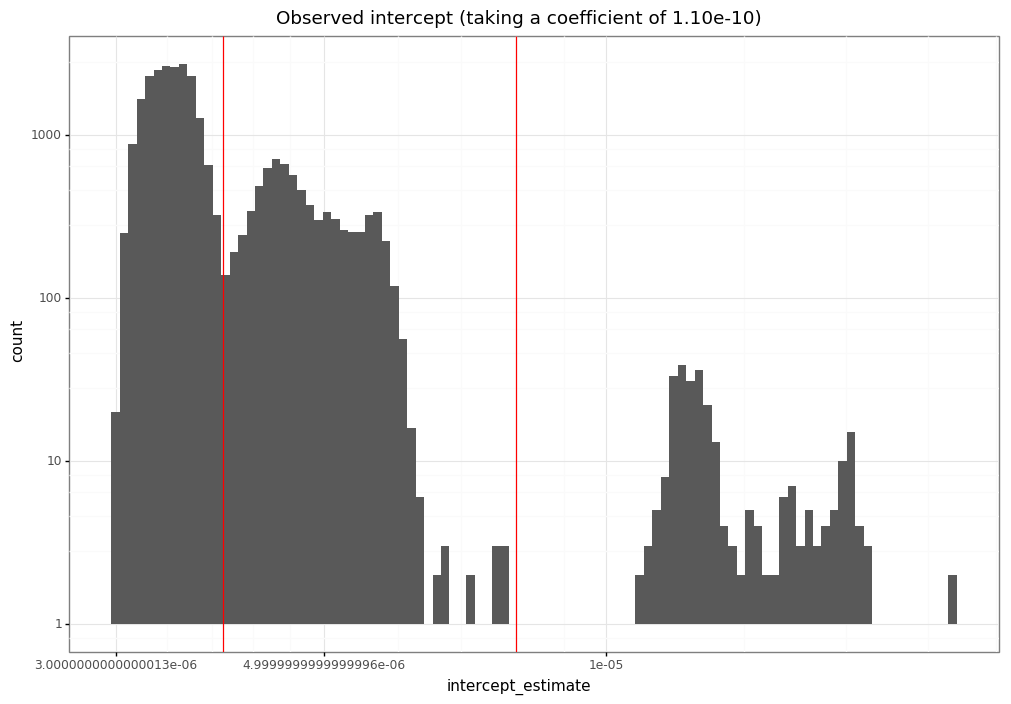

<ggplot: (-9223363294473214846)>


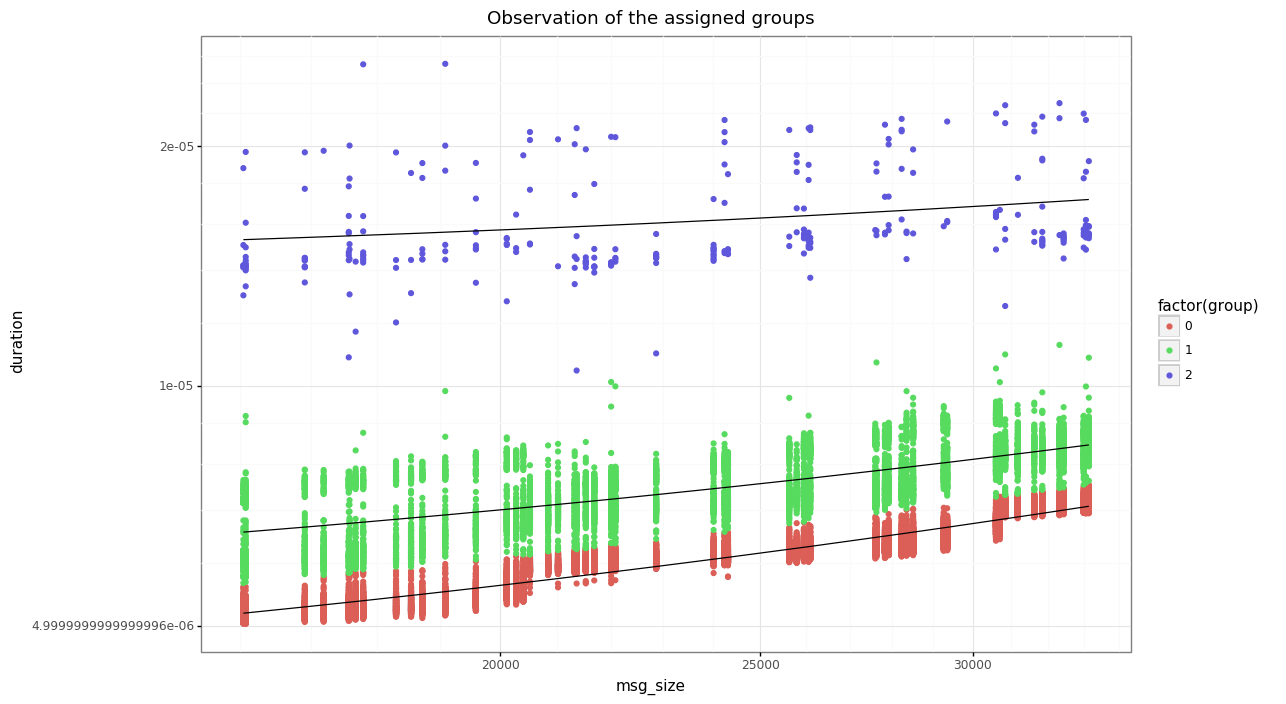

<ggplot: (-9223363294532827462)>


<IPython.core.display.Math object>

In [25]:
min_x, max_x = breakpoints[2:4]
adhoc_reg = compute_mixture_regression(df_send, min_x, max_x, [3.9e-6, 8e-6])
adhoc_reg

In [26]:
regressions_send.append(adhoc_reg, min_x, max_x)

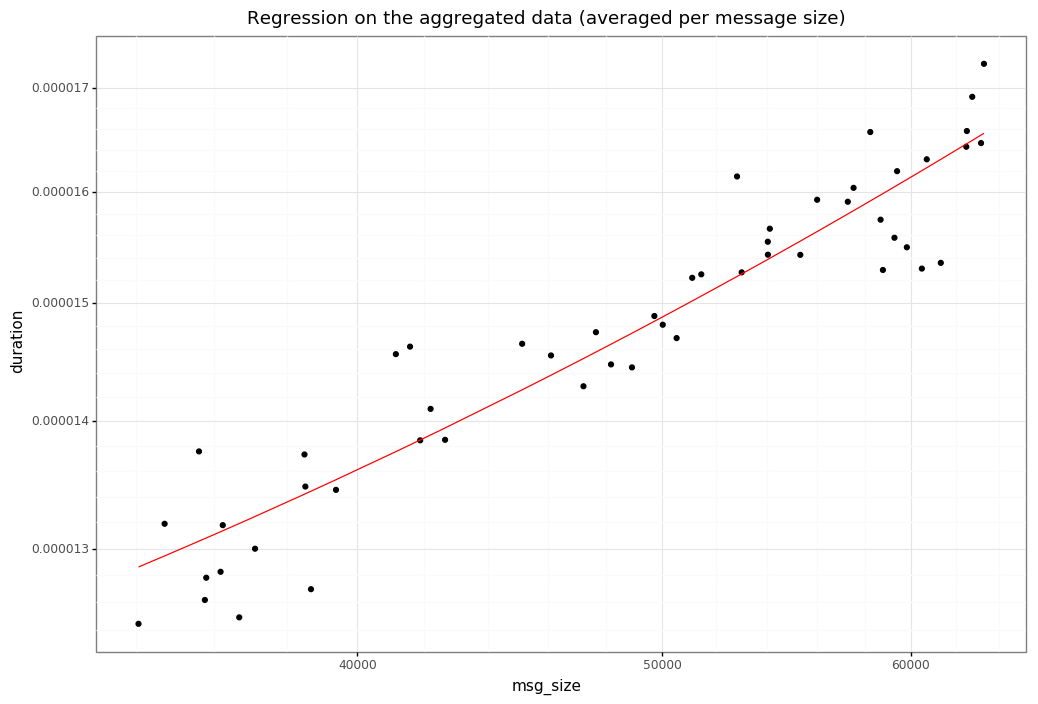

<ggplot: (8742302969583)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     396.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           2.00e-25
Time:                        14:54:11   Log-Likelihood:                 689.42
No. Observations:                  52   AIC:                            -1375.
Df Residuals:                      50   BIC:                            -1371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.556e-06   3.

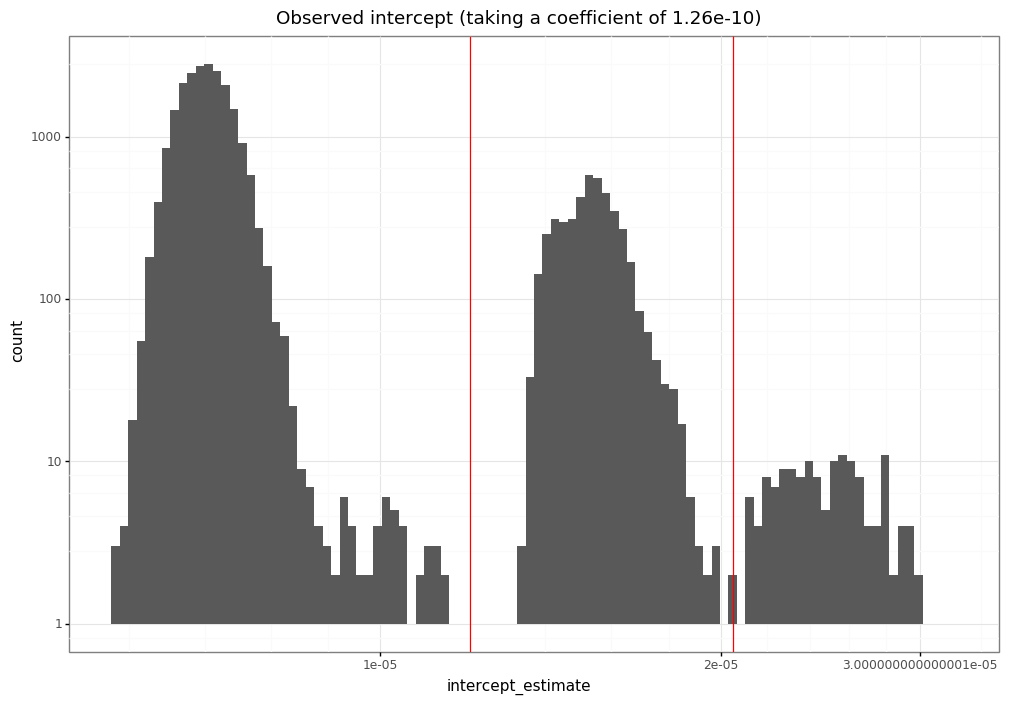

<ggplot: (-9223363294552089172)>


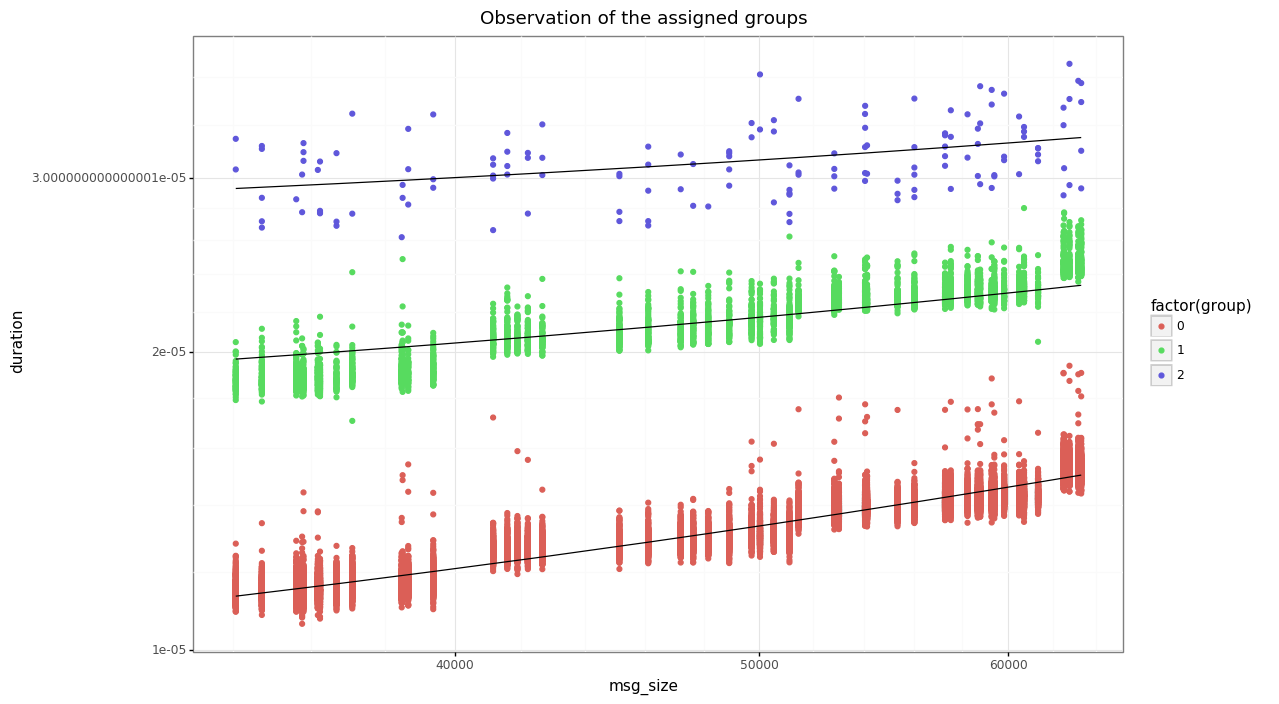

<ggplot: (8742321956991)>


<IPython.core.display.Math object>

In [27]:
min_x, max_x = breakpoints[3:5]
adhoc_reg = compute_mixture_regression(df_send, min_x, max_x, [1.2e-5, 2.05e-5])
adhoc_reg

In [28]:
regressions_send.append(adhoc_reg, min_x, max_x)

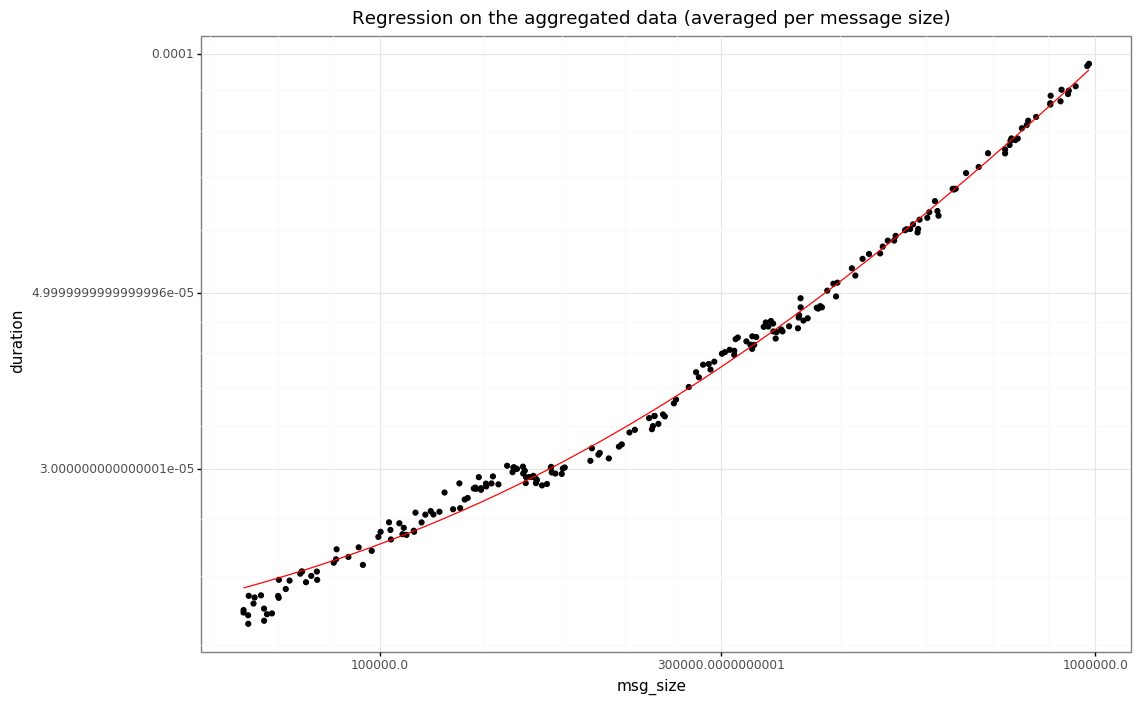

<ggplot: (-9223363294552156430)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 6.308e+04
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          4.61e-254
Time:                        14:54:14   Log-Likelihood:                 2509.8
No. Observations:                 204   AIC:                            -5016.
Df Residuals:                     202   BIC:                            -5009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.603e-

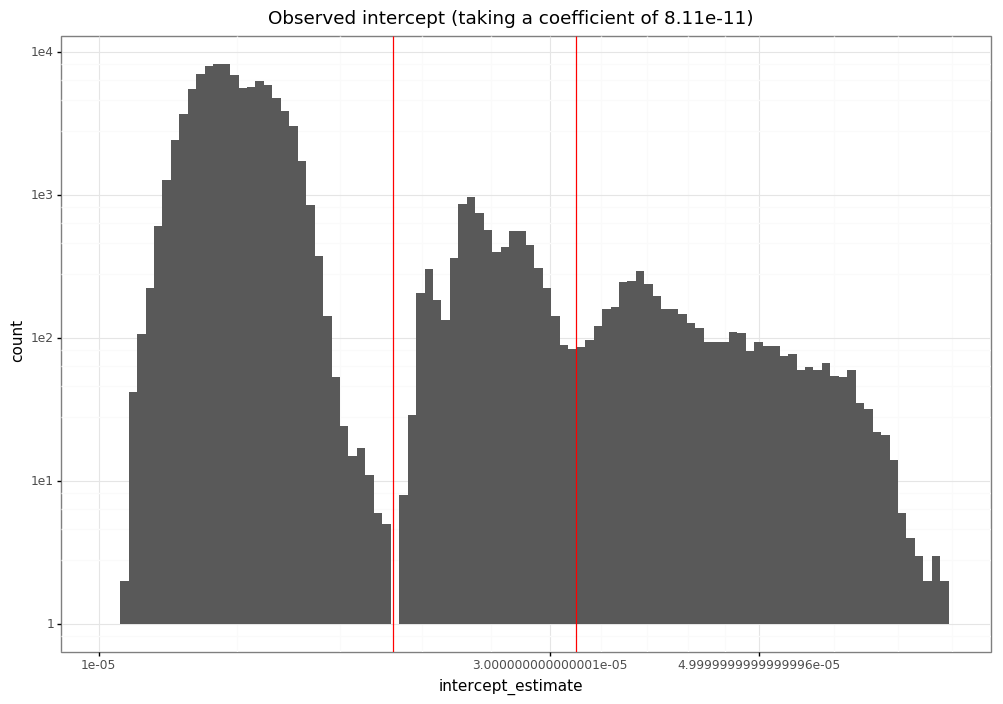

<ggplot: (-9223363294552023822)>


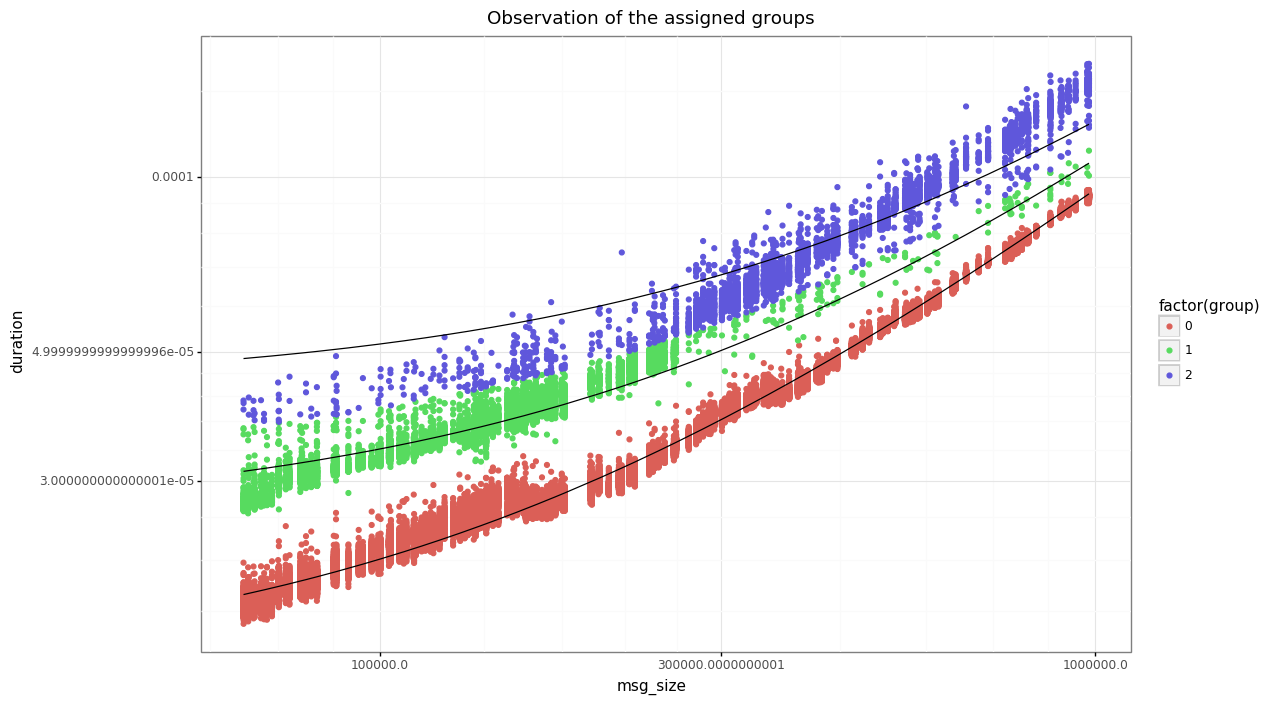

<ggplot: (8742397819305)>


<IPython.core.display.Math object>

In [29]:
min_x, max_x = breakpoints[4:6]
adhoc_reg = compute_mixture_regression(df_send, min_x, max_x, [2.05e-5, 3.2e-5])
adhoc_reg

In [30]:
regressions_send.append(adhoc_reg, min_x, max_x)

In [31]:
regressions_send

<IPython.core.display.Math object>

In [32]:
regressions_send.pretty_c()

```c
double smpi_stochastic_intercept=-1, smpi_stochastic_coefficient=-1;
if(smpi_stochastic_size < 8133) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {1.158459e-05, 4.445288e-06, 3.681319e-04},
        {7.342084e-07, 1.921238e-07, 1.978187e-01},
        {1.834565e-07, 6.848359e-08, 8.018132e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 9.630674e-11;
}
if(8133 <= smpi_stochastic_size && smpi_stochastic_size < 15831) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {1.309743e-05, 2.247476e-06, 1.560000e-02},
        {5.666558e-06, 3.963607e-07, 8.555556e-02},
        {3.811149e-06, 3.445008e-07, 8.988444e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.002390e-10;
}
if(15831 <= smpi_stochastic_size && smpi_stochastic_size < 33956) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {1.351552e-05, 2.434263e-06, 1.028571e-02},
        {4.800520e-06, 5.476791e-07, 2.700357e-01},
        {3.429396e-06, 1.783164e-07, 7.196786e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.099663e-10;
}
if(33956 <= smpi_stochastic_size && smpi_stochastic_size < 64000) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {2.499927e-05, 2.469454e-06, 5.730769e-03},
        {1.538620e-05, 9.485493e-07, 1.705385e-01},
        {7.027786e-06, 3.911404e-07, 8.237308e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.263659e-10;
}
if(64000 <= smpi_stochastic_size) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {4.349341e-05, 8.929562e-06, 4.033333e-02},
        {2.597202e-05, 2.246442e-06, 7.444118e-02},
        {1.394499e-05, 1.225181e-06, 8.852255e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 8.107116e-11;
}

```

## Analysis - MPI_Isend

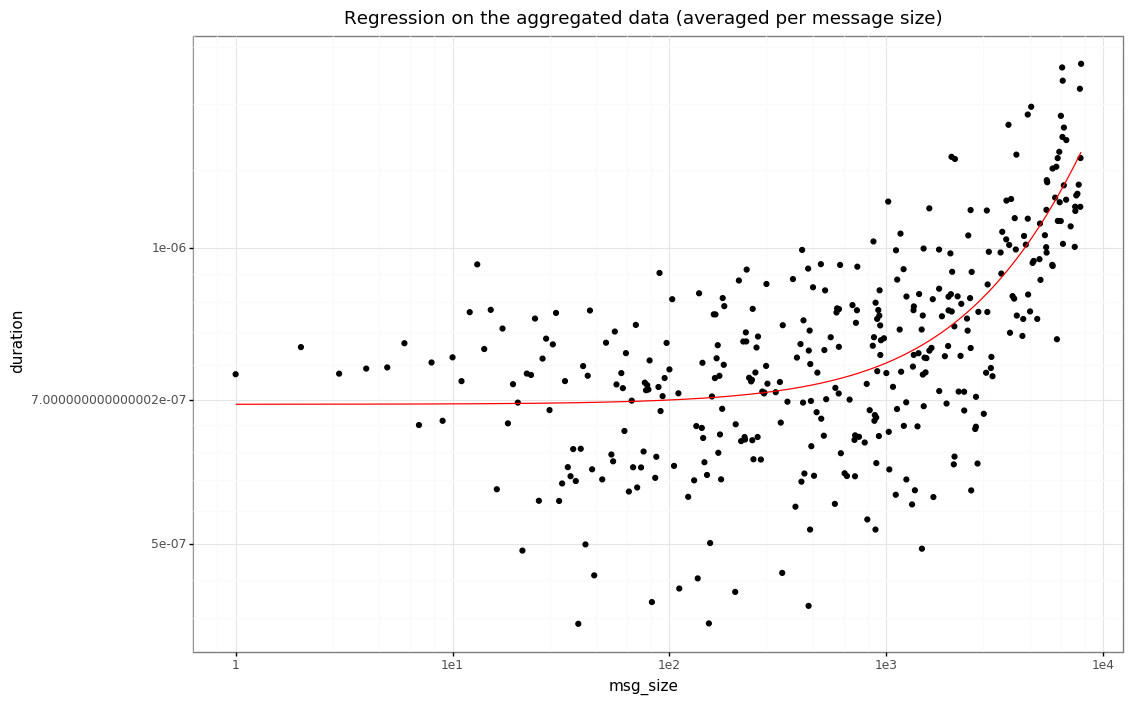

<ggplot: (8742302964786)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     400.5
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.57e-60
Time:                        14:54:24   Log-Likelihood:                 5232.6
No. Observations:                 364   AIC:                        -1.046e+04
Df Residuals:                     362   BIC:                        -1.045e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.931e-07   9.

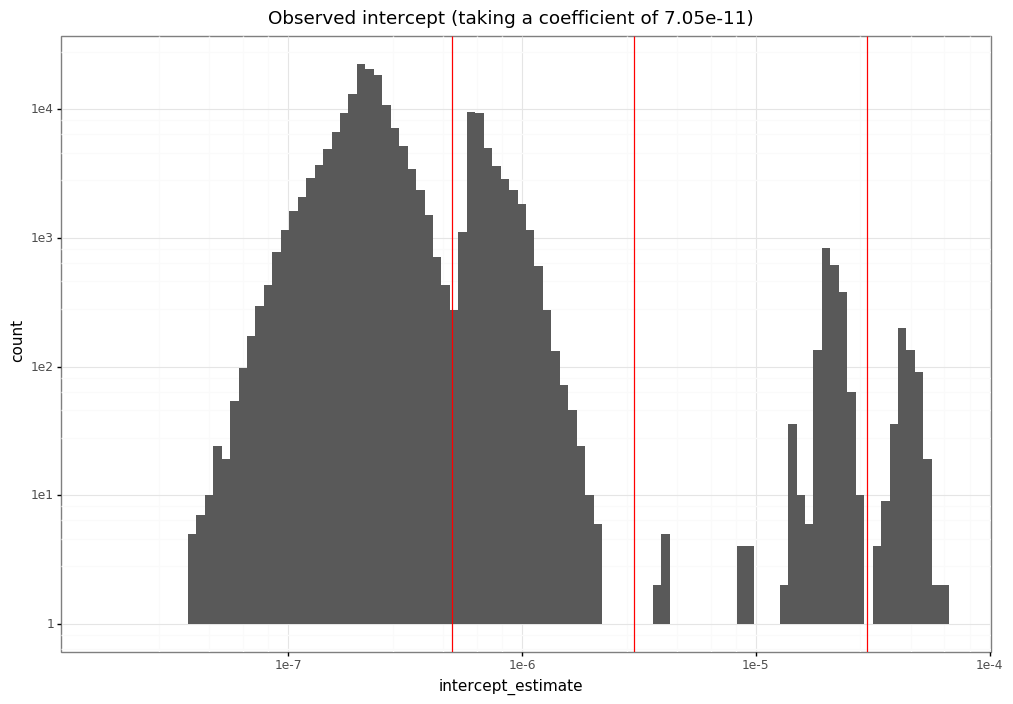

<ggplot: (-9223363294532384210)>


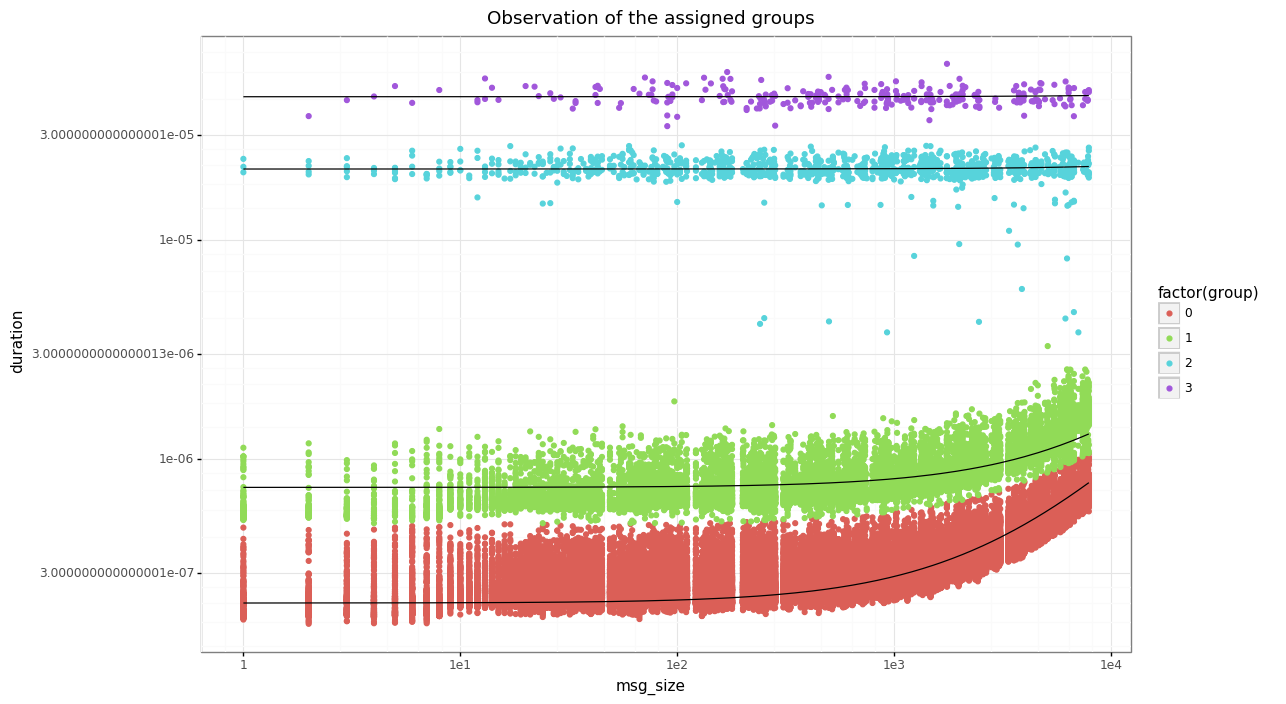

<ggplot: (-9223363294532681163)>


<IPython.core.display.Math object>

In [33]:
regressions_isend = SegmentedRegression()
min_x, max_x = breakpoints[0:2]
adhoc_reg = compute_mixture_regression(df_isend, min_x, max_x, [5e-7, 3e-6, 3e-5])
adhoc_reg

In [34]:
regressions_isend.append(adhoc_reg, min_x, max_x)

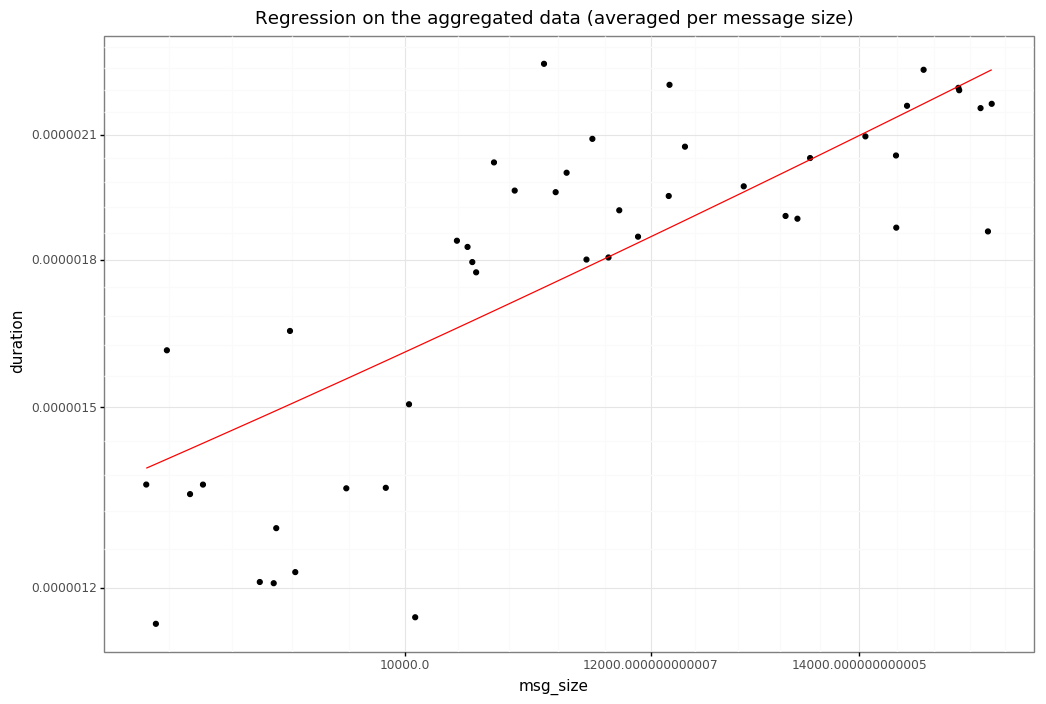

<ggplot: (8742322384318)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     72.54
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           8.89e-11
Time:                        14:54:34   Log-Likelihood:                 628.29
No. Observations:                  45   AIC:                            -1253.
Df Residuals:                      43   BIC:                            -1249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    3.76e-07    1

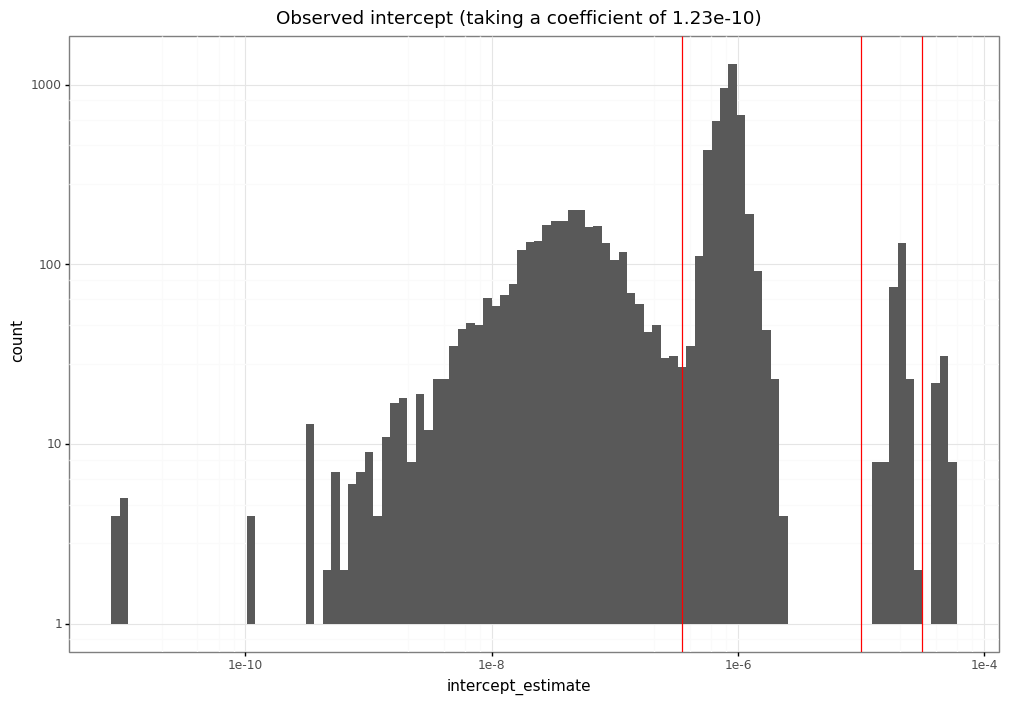

<ggplot: (-9223363294520535103)>


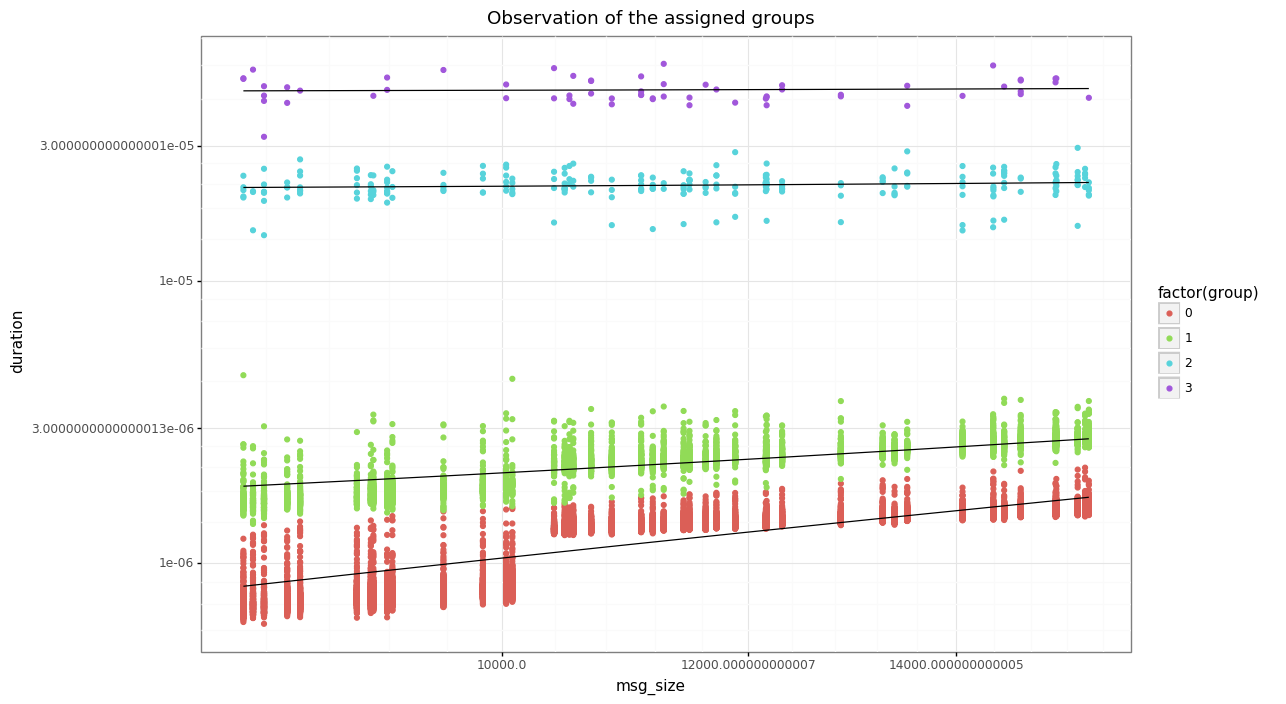

<ggplot: (-9223363294520620505)>


<IPython.core.display.Math object>

In [35]:
min_x, max_x = breakpoints[1:3]
adhoc_reg = compute_mixture_regression(df_isend, min_x, max_x, [3.5e-7, 1e-5, 3.1e-5])
adhoc_reg

In [36]:
regressions_isend.append(adhoc_reg, min_x, max_x)

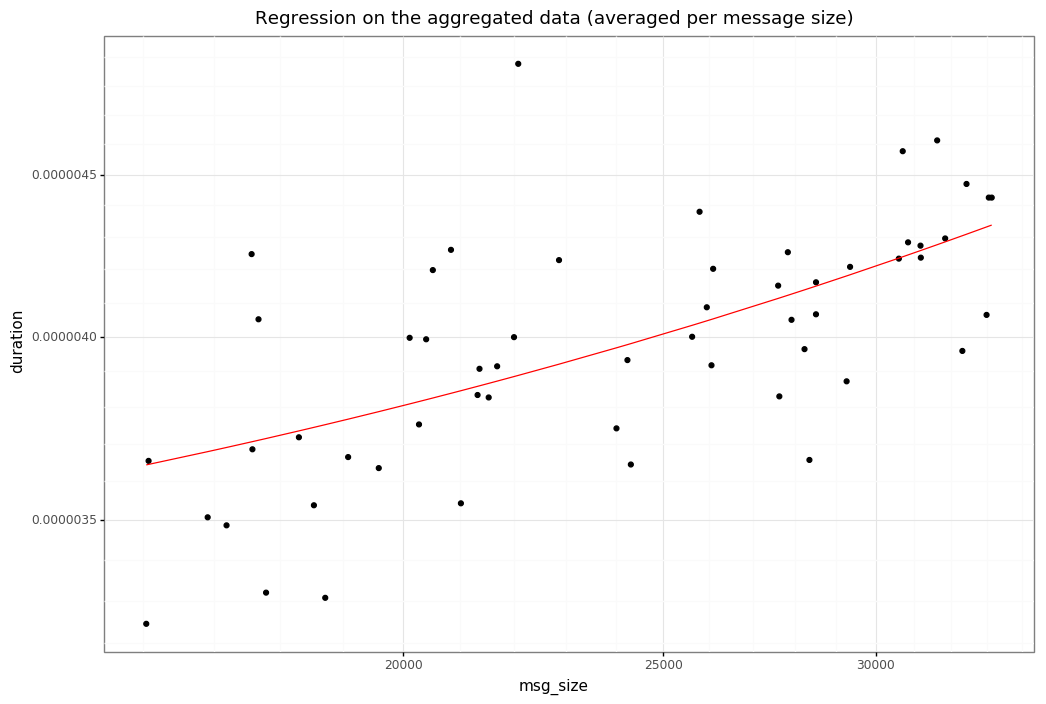

<ggplot: (8742301616637)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     35.68
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.88e-07
Time:                        14:54:37   Log-Likelihood:                 768.83
No. Observations:                  56   AIC:                            -1534.
Df Residuals:                      54   BIC:                            -1530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.992e-06   1.

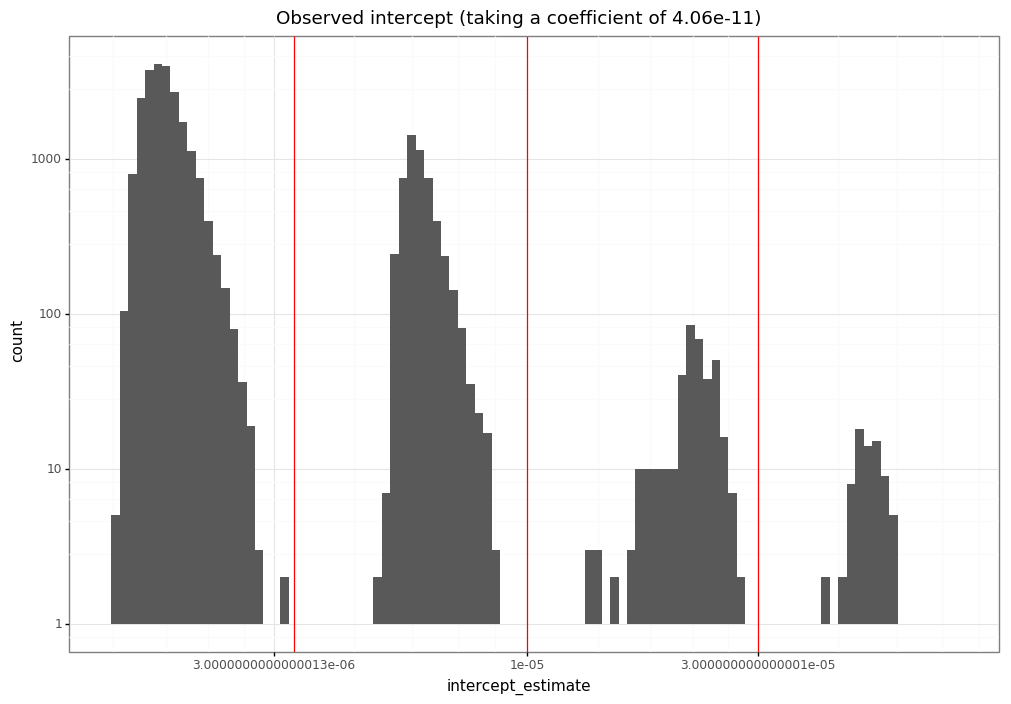

<ggplot: (8742382843126)>


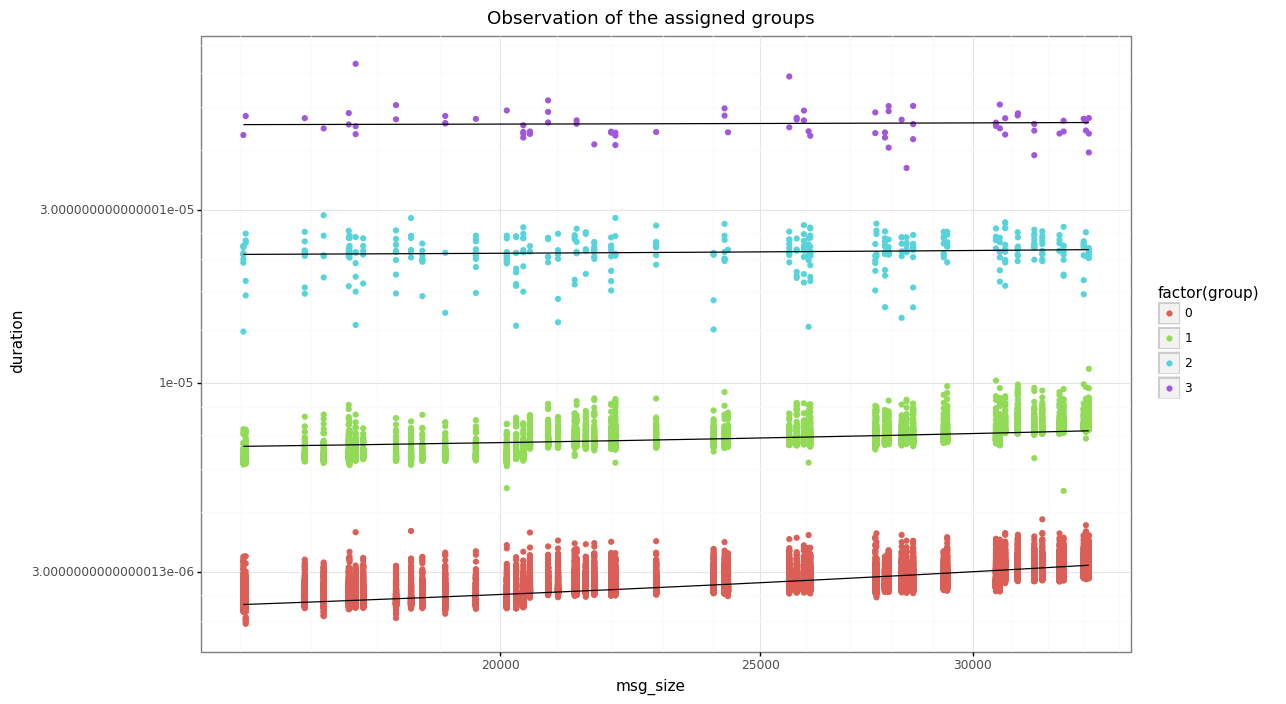

<ggplot: (8742322367766)>


<IPython.core.display.Math object>

In [37]:
min_x, max_x = breakpoints[2:4]
adhoc_reg = compute_mixture_regression(df_isend, min_x, max_x, [3.3e-6, 1e-5, 3e-5])
adhoc_reg

In [38]:
regressions_isend.append(adhoc_reg, min_x, max_x)

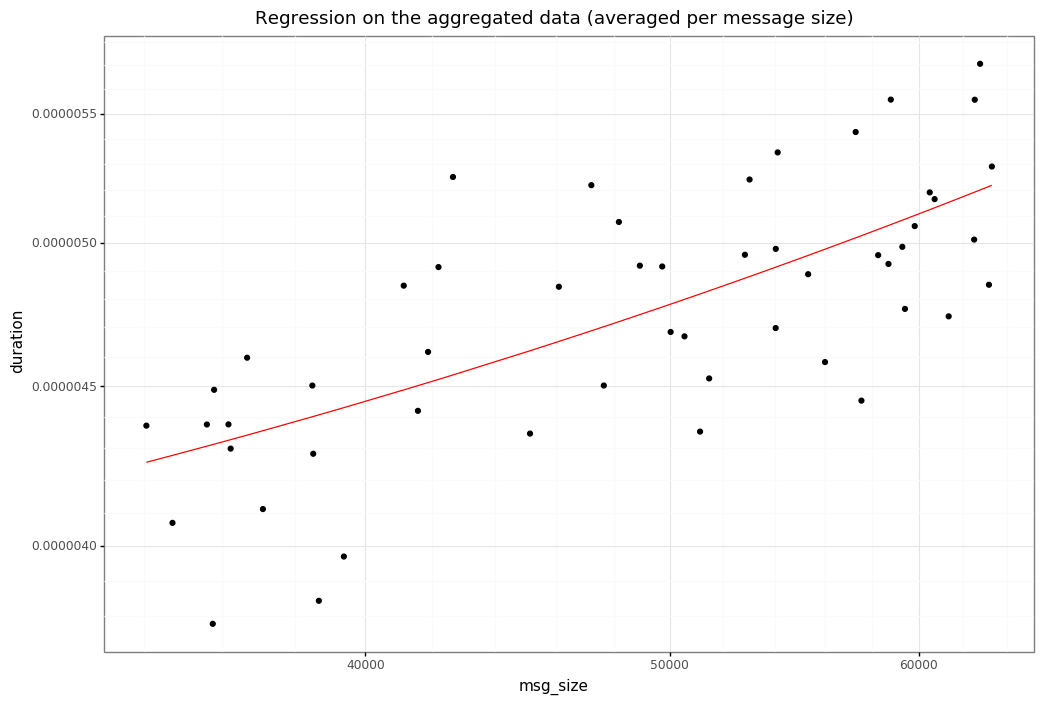

<ggplot: (8742382807083)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     50.37
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           4.22e-09
Time:                        14:54:41   Log-Likelihood:                 705.69
No. Observations:                  52   AIC:                            -1407.
Df Residuals:                      50   BIC:                            -1403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.133e-06   2.

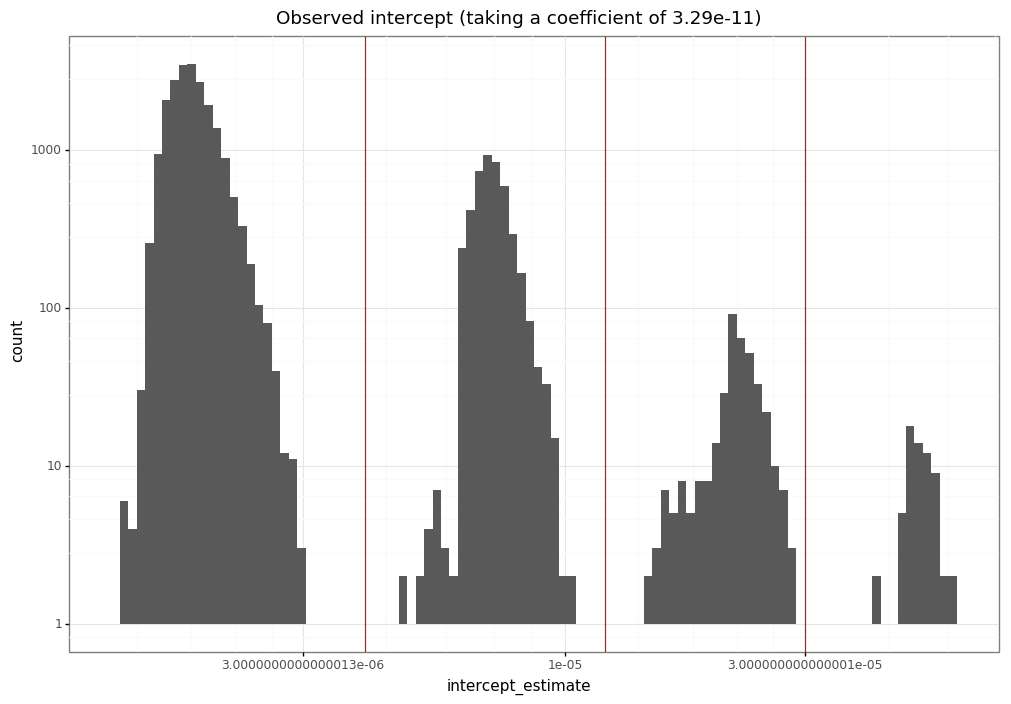

<ggplot: (-9223363294471962487)>


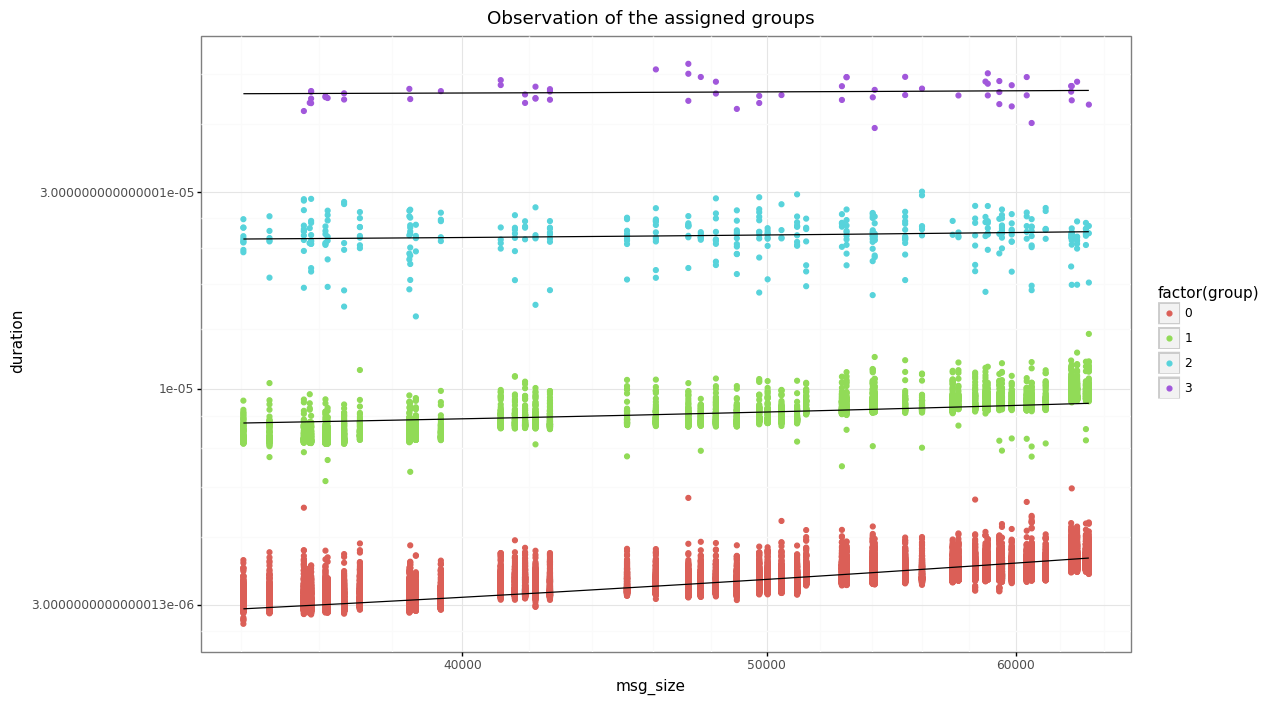

<ggplot: (-9223363294532412065)>


<IPython.core.display.Math object>

In [39]:
min_x, max_x = breakpoints[3:5]
adhoc_reg = compute_mixture_regression(df_isend, min_x, max_x, [4e-6, 1.2e-5, 3e-5])
adhoc_reg

In [40]:
regressions_isend.append(adhoc_reg, min_x, max_x)

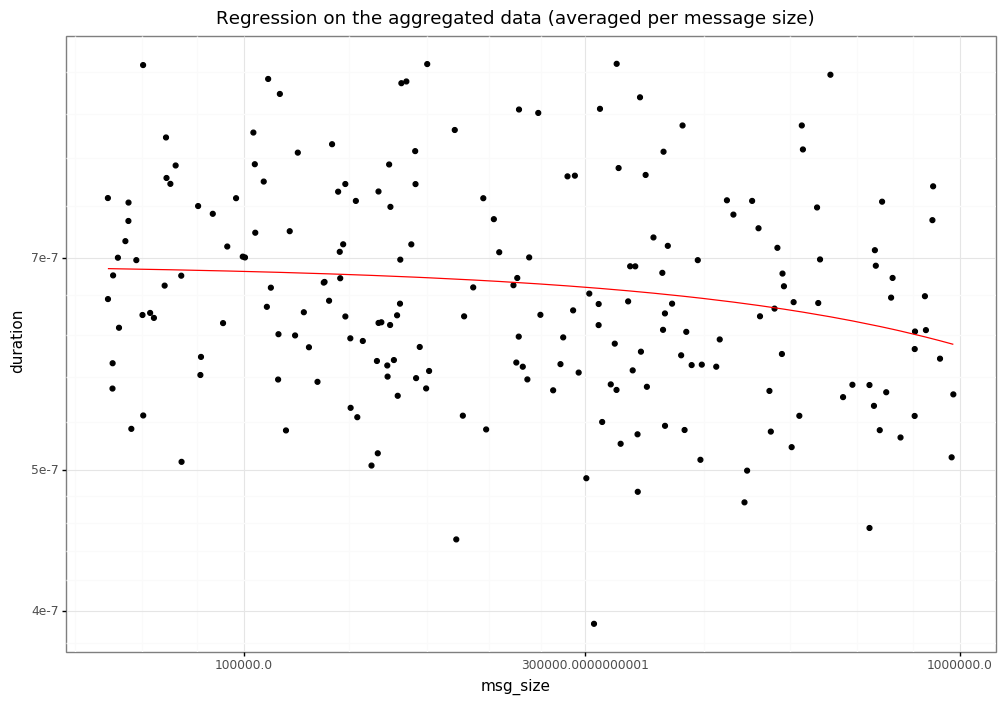

<ggplot: (-9223363294471969213)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.790
Date:                Thu, 21 Mar 2019   Prob (F-statistic):            0.00985
Time:                        14:54:45   Log-Likelihood:                 2977.3
No. Observations:                 204   AIC:                            -5951.
Df Residuals:                     202   BIC:                            -5944.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    6.94e-

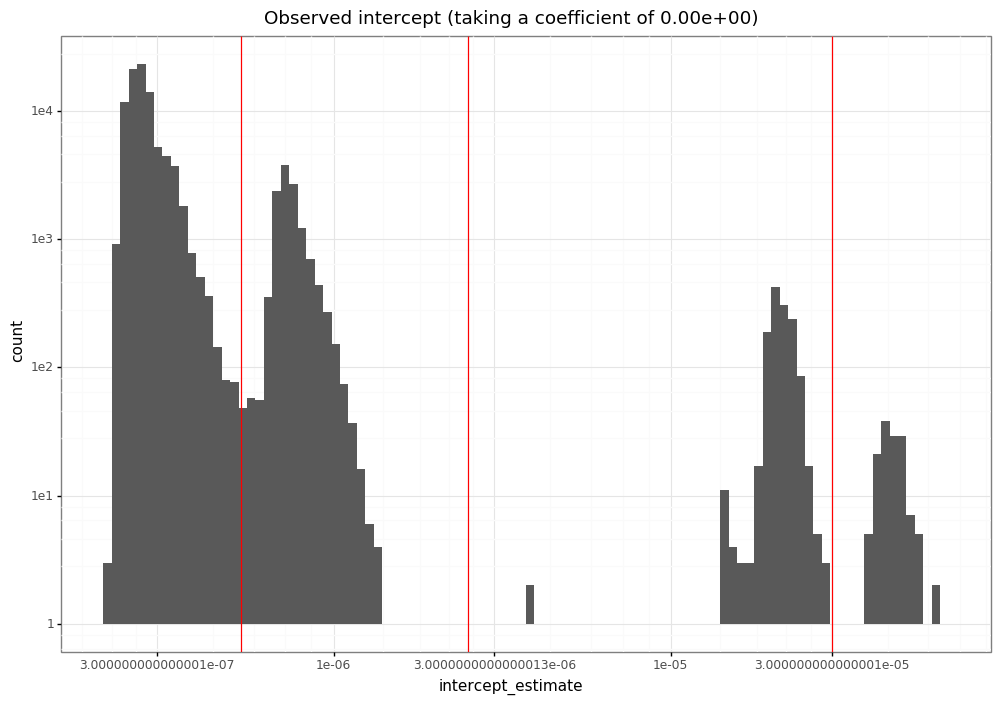

<ggplot: (-9223363294472049050)>


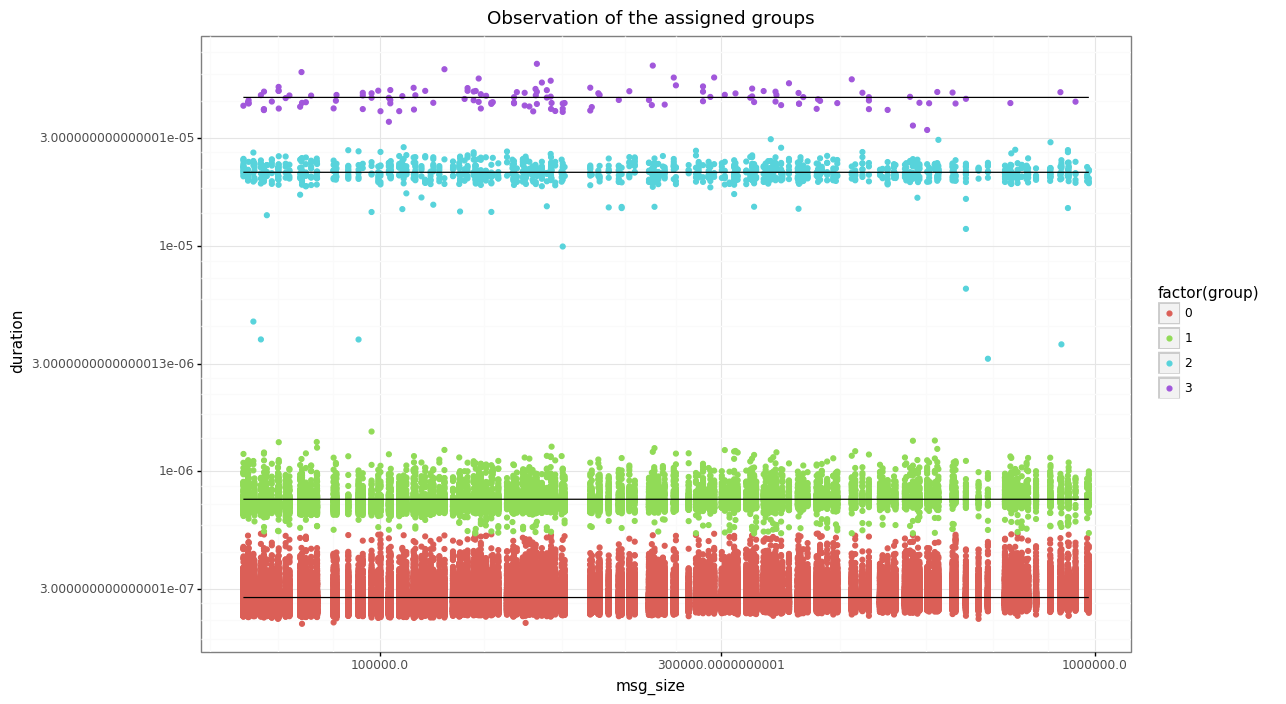

<ggplot: (8742302766000)>


<IPython.core.display.Math object>

In [41]:
min_x, max_x = breakpoints[4:6]
adhoc_reg = compute_mixture_regression(df_isend, min_x, max_x, [5.3e-7, 2.5e-6, 3e-5])
adhoc_reg

In [42]:
regressions_isend.append(adhoc_reg, min_x, max_x)

In [43]:
regressions_isend

<IPython.core.display.Math object>

In [44]:
regressions_isend.pretty_c()

```c
double smpi_stochastic_intercept=-1, smpi_stochastic_coefficient=-1;
if(smpi_stochastic_size < 8133) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {4.492700e-05, 4.074614e-06, 2.730769e-03},
        {2.100718e-05, 2.427905e-06, 1.167582e-02},
        {7.387183e-07, 1.654137e-07, 2.104066e-01},
        {2.189611e-07, 6.260189e-08, 7.751868e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 7.050642e-11;
}
if(8133 <= smpi_stochastic_size && smpi_stochastic_size < 15831) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {4.590579e-05, 4.614774e-06, 2.755556e-03},
        {2.034218e-05, 2.321272e-06, 1.097778e-02},
        {8.584810e-07, 2.402363e-07, 2.008444e-01},
        {-1.862171e-07, 1.632566e-07, 7.854222e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.229780e-10;
}
if(15831 <= smpi_stochastic_size && smpi_stochastic_size < 33956) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {5.106743e-05, 5.243046e-06, 2.785714e-03},
        {2.200488e-05, 2.521526e-06, 1.325000e-02},
        {6.032292e-06, 4.870055e-07, 1.873571e-01},
        {1.792845e-06, 1.766367e-07, 7.966071e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 4.059840e-11;
}
if(33956 <= smpi_stochastic_size && smpi_stochastic_size < 64000) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {5.093095e-05, 3.380393e-06, 2.461538e-03},
        {2.201740e-05, 2.466355e-06, 1.430769e-02},
        {7.167819e-06, 5.962693e-07, 1.693077e-01},
        {1.817755e-06, 1.954229e-07, 8.139231e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 3.293459e-11;
}
if(64000 <= smpi_stochastic_size) {
    double mixtures_smpi_stochastic_intercept[4][3] = {
        {4.549290e-05, 4.842656e-06, 1.382353e-03},
        {2.117993e-05, 2.147733e-06, 1.298039e-02},
        {7.524123e-07, 8.528449e-08, 1.205392e-01},
        {2.759115e-07, 3.453358e-08, 8.650980e-01}
    };
    smpi_stochastic_intercept = random_mixture(4, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 0.000000e+00;
}

```

## Analysis - Pingpong

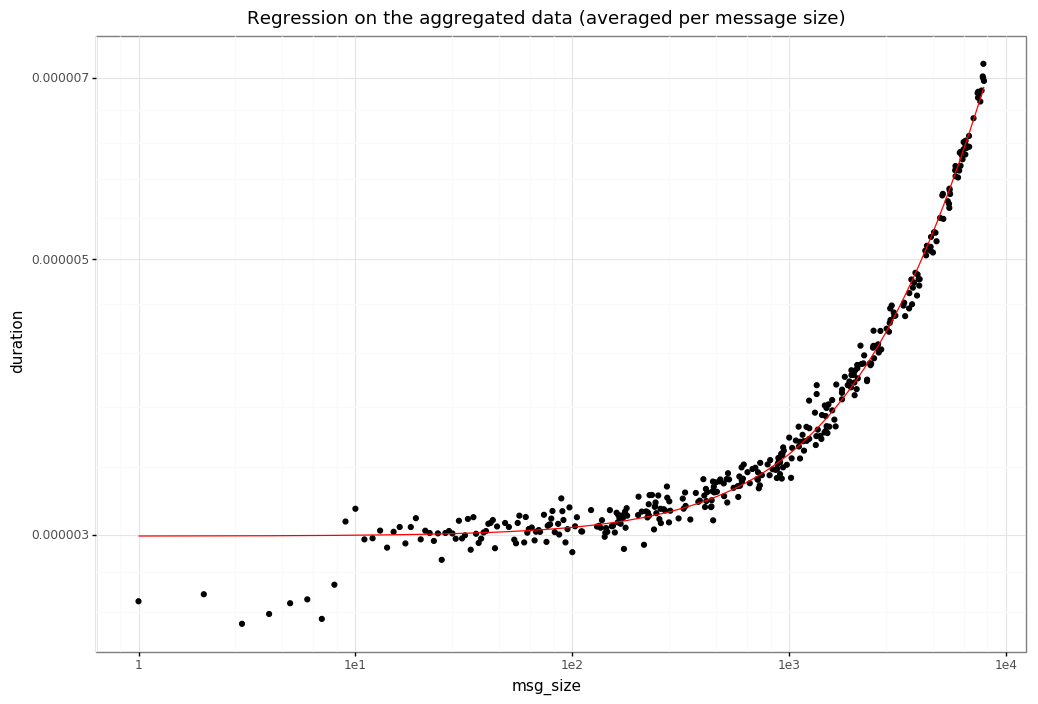

<ggplot: (-9223363294551830135)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.950e+04
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:54:55   Log-Likelihood:                 5360.7
No. Observations:                 364   AIC:                        -1.072e+04
Df Residuals:                     362   BIC:                        -1.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.994e-

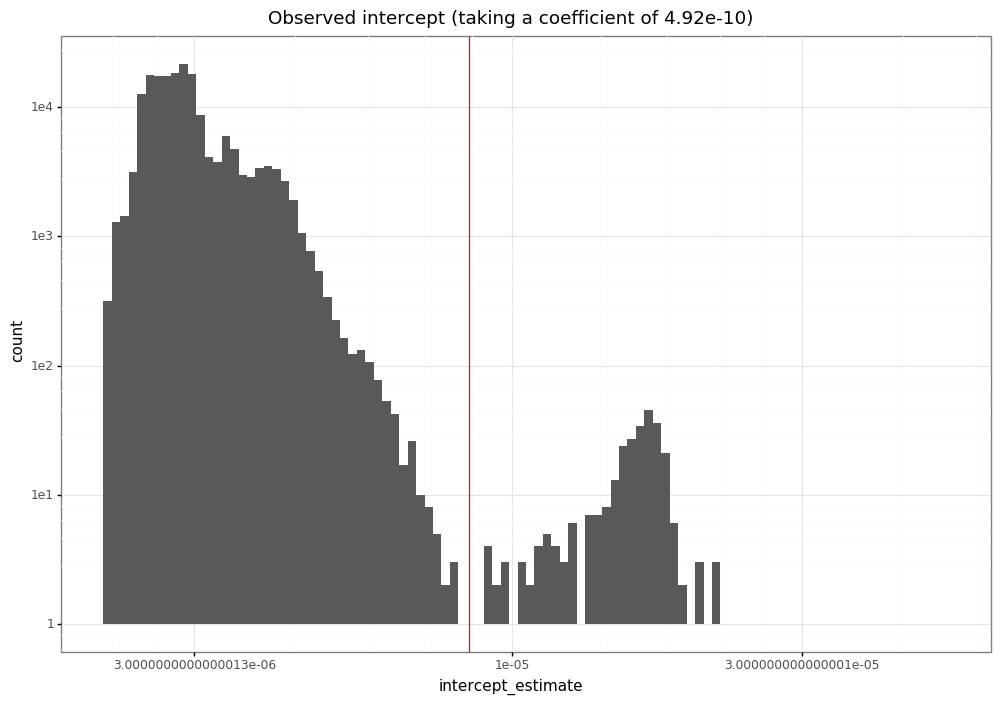

<ggplot: (-9223363294552598952)>


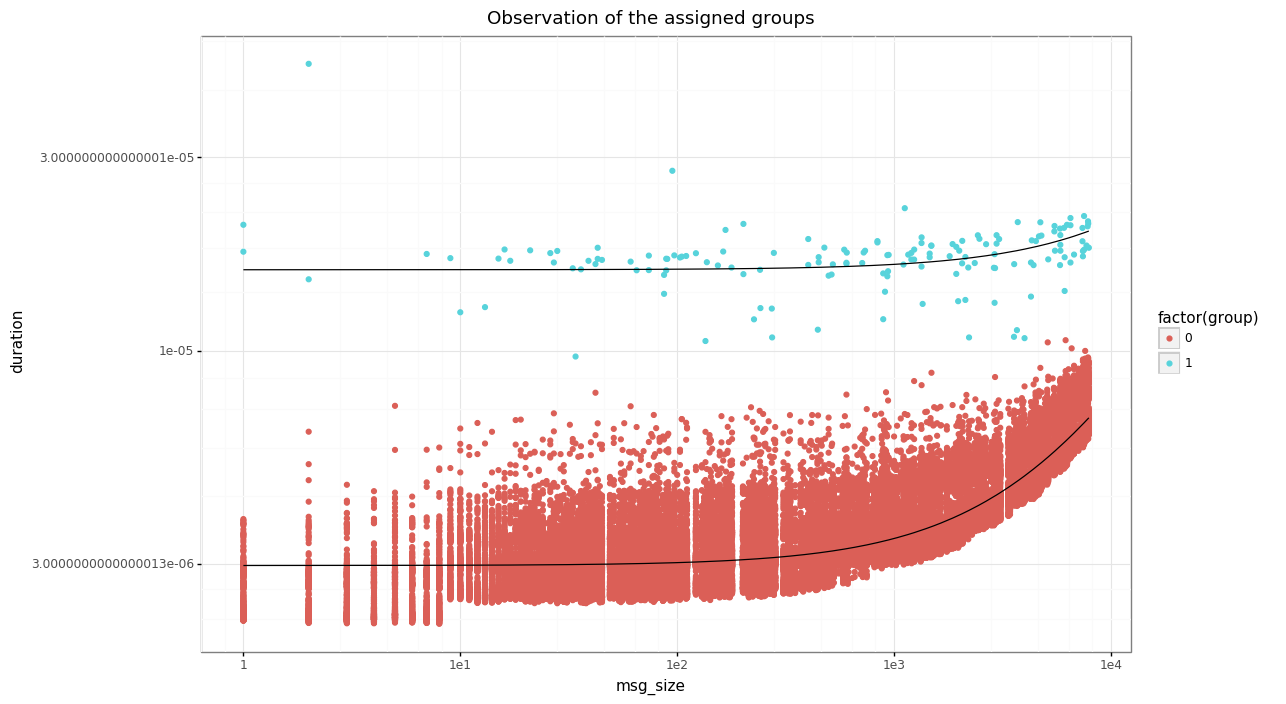

<ggplot: (8742302471744)>


<IPython.core.display.Math object>

In [45]:
regressions_pingpong = SegmentedRegression()
min_x, max_x = breakpoints[0:2]
adhoc_reg = compute_mixture_regression(df_pingpong, min_x, max_x, [8.5e-6])
adhoc_reg

In [46]:
regressions_pingpong.append(adhoc_reg, min_x, max_x)

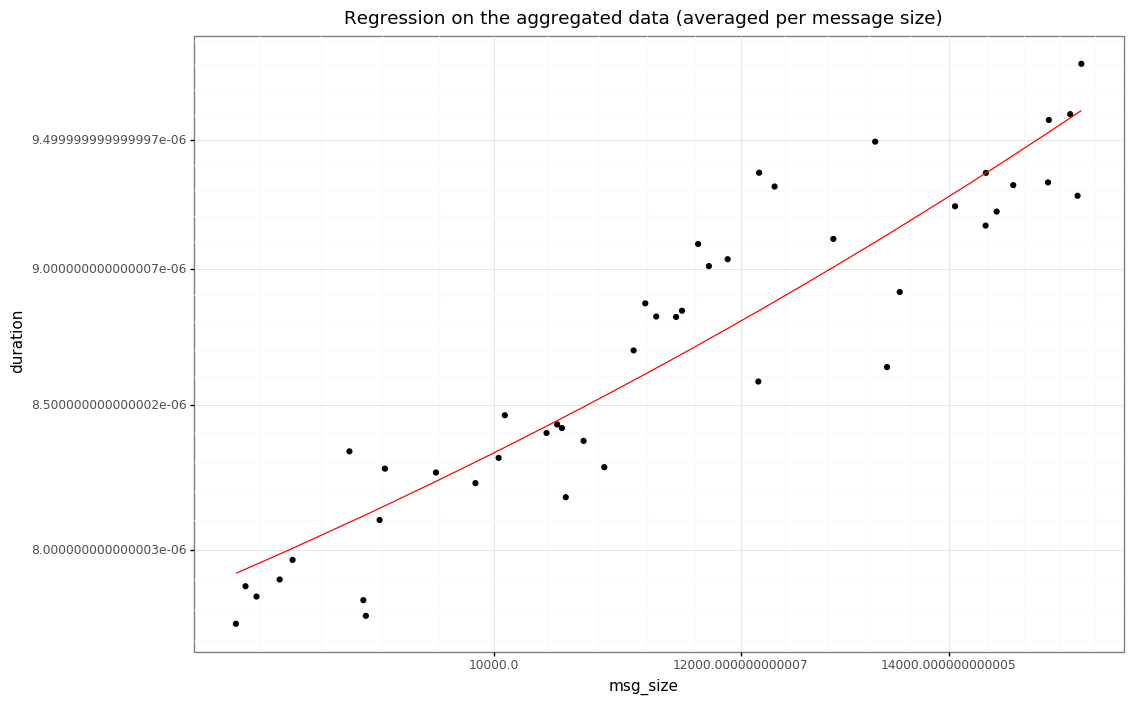

<ggplot: (-9223363294552799842)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     236.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           4.33e-19
Time:                        14:55:05   Log-Likelihood:                 625.57
No. Observations:                  45   AIC:                            -1247.
Df Residuals:                      43   BIC:                            -1244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.974e-

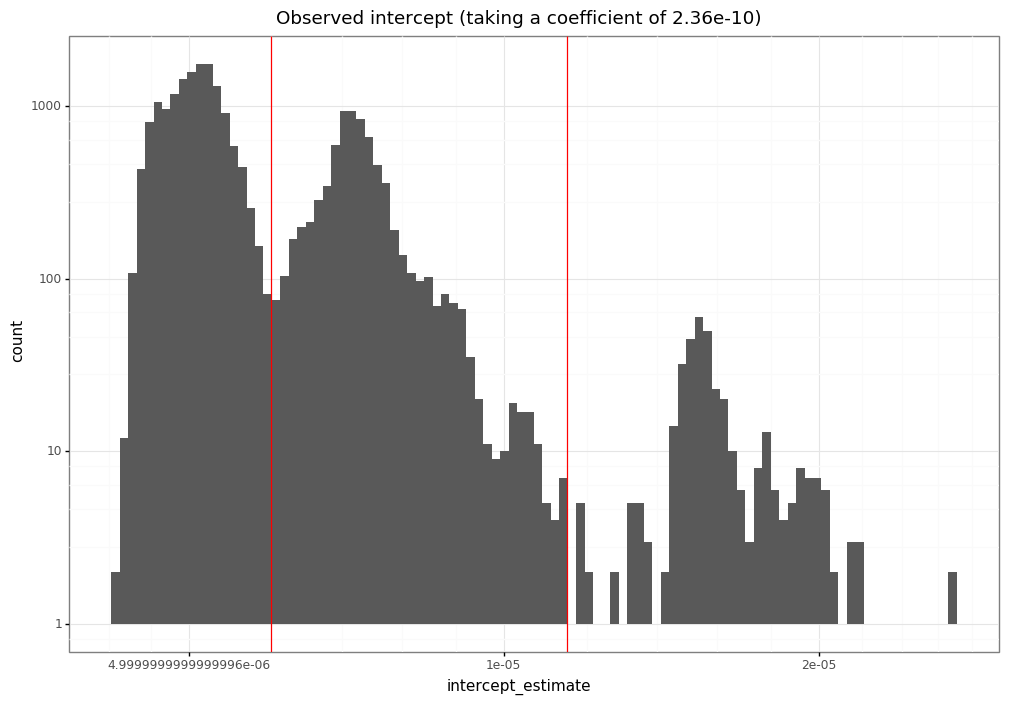

<ggplot: (-9223363294532376737)>


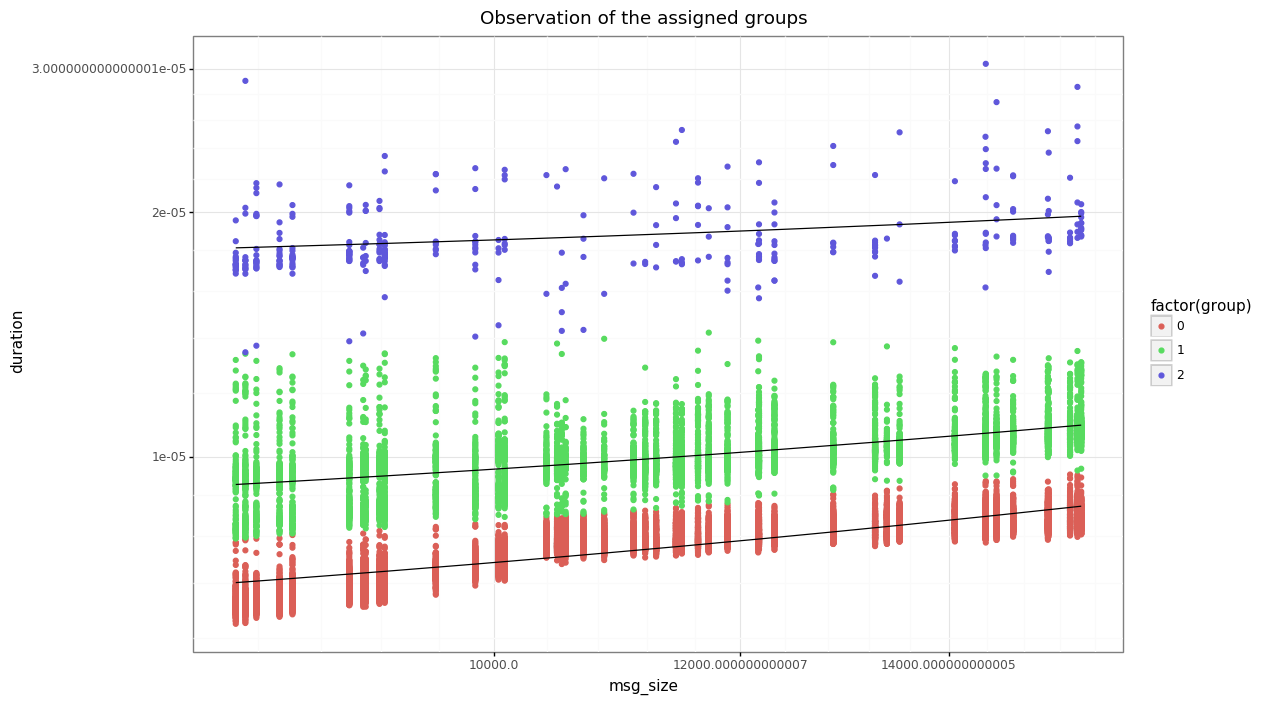

<ggplot: (8742382809457)>


<IPython.core.display.Math object>

In [47]:
min_x, max_x = breakpoints[1:3]
adhoc_reg = compute_mixture_regression(df_pingpong, min_x, max_x, [6e-6, 1.15e-5])
adhoc_reg

In [48]:
regressions_pingpong.append(adhoc_reg, min_x, max_x)

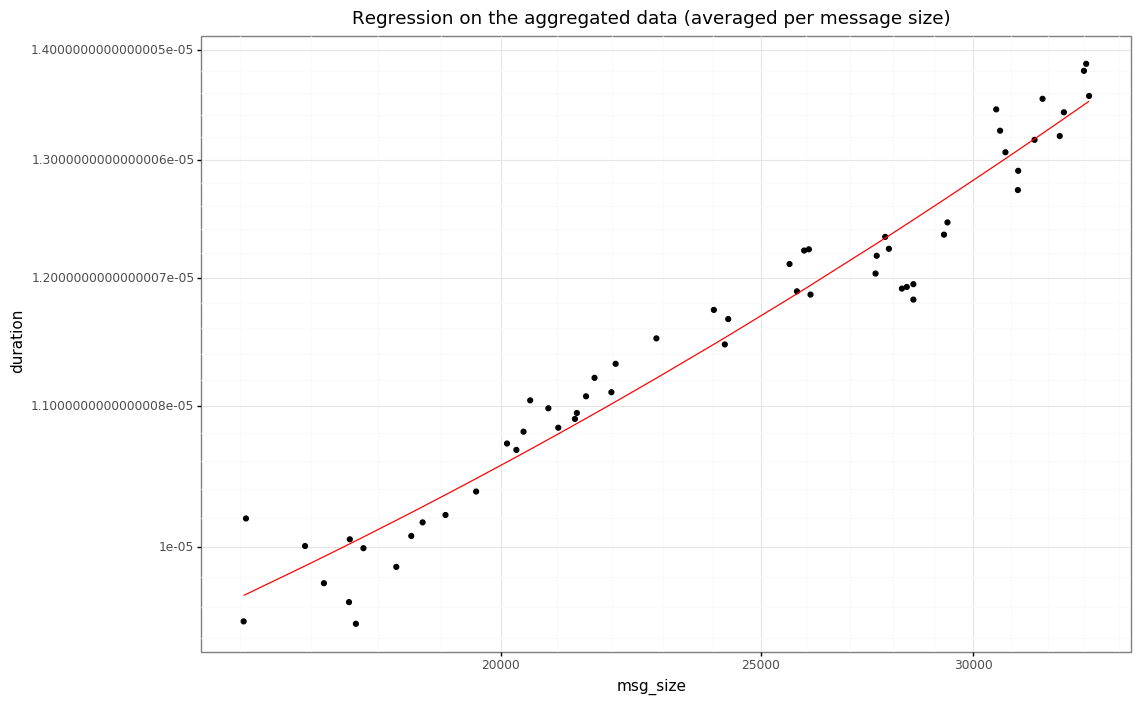

<ggplot: (8742302138011)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1033.
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           6.91e-37
Time:                        14:55:08   Log-Likelihood:                 767.16
No. Observations:                  56   AIC:                            -1530.
Df Residuals:                      54   BIC:                            -1526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.067e-06   1.

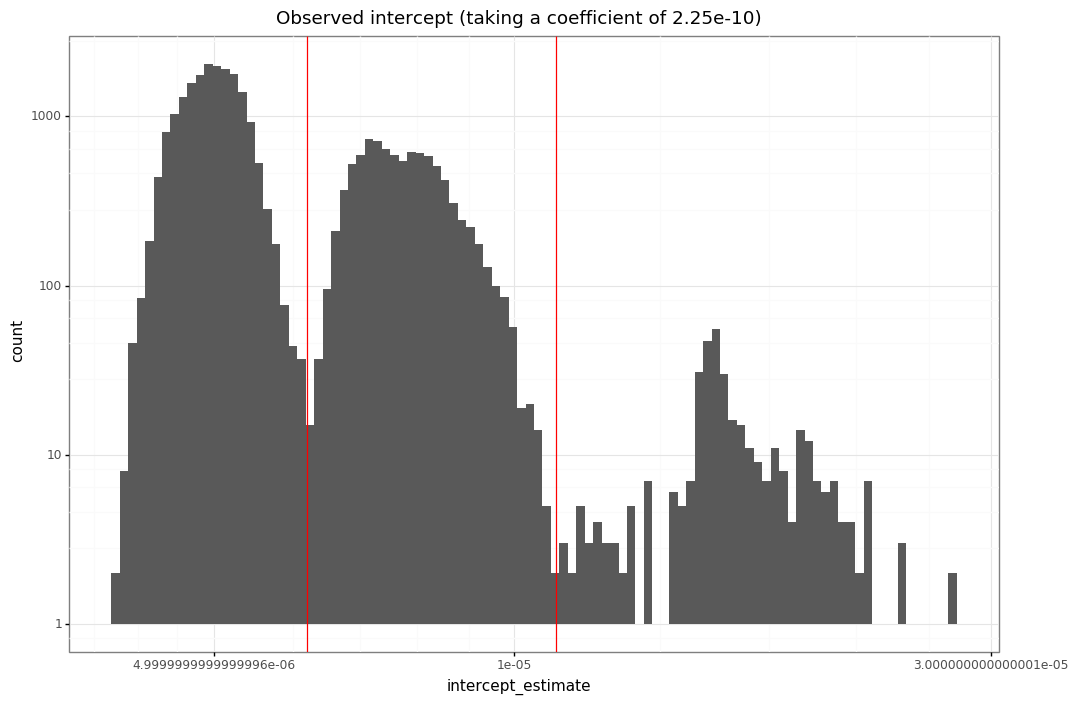

<ggplot: (8742302542470)>


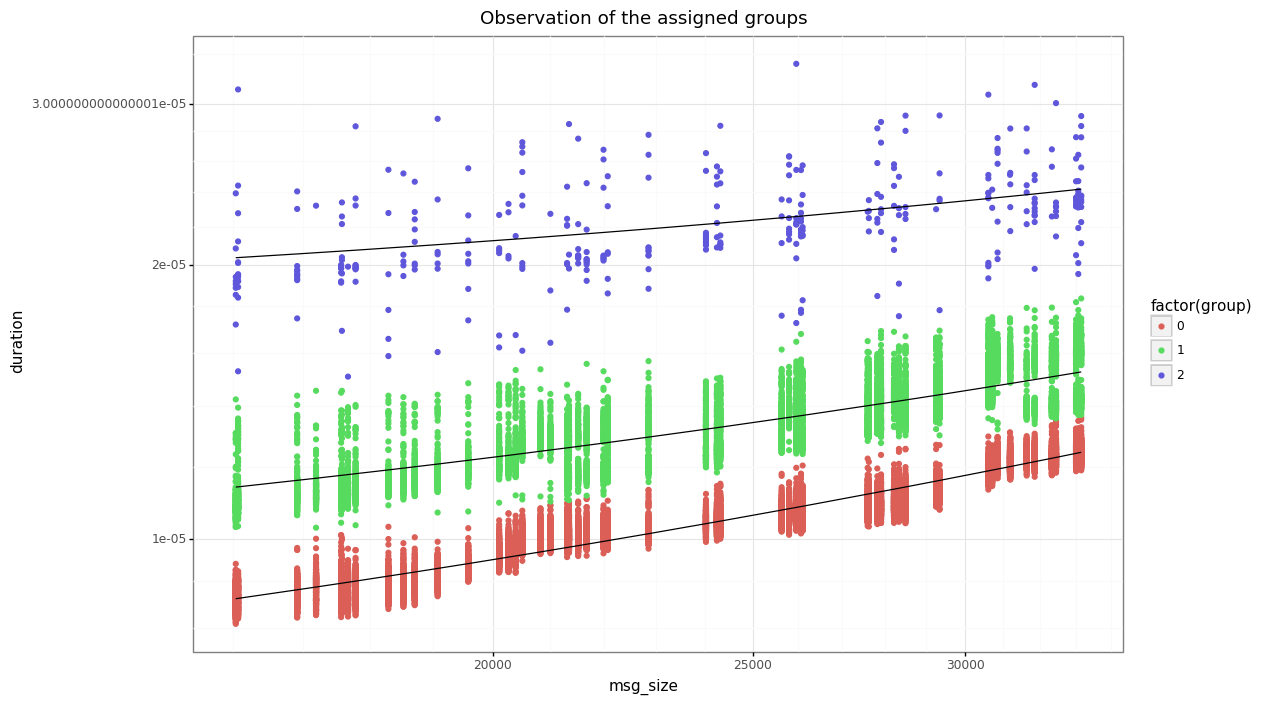

<ggplot: (-9223363294552235306)>


<IPython.core.display.Math object>

In [49]:
min_x, max_x = breakpoints[2:4]
adhoc_reg = compute_mixture_regression(df_pingpong, min_x, max_x, [6.2e-6, 1.1e-5])
adhoc_reg

In [50]:
regressions_pingpong.append(adhoc_reg, min_x, max_x)

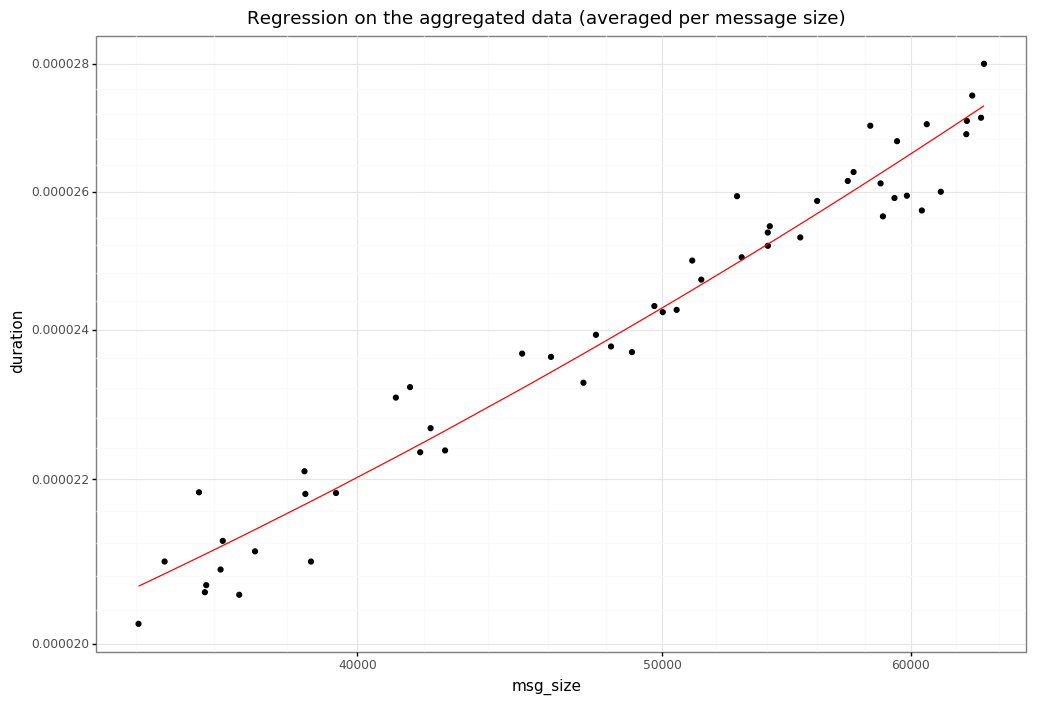

<ggplot: (8742382805445)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1143.
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           4.15e-36
Time:                        14:55:12   Log-Likelihood:                 686.37
No. Observations:                  52   AIC:                            -1369.
Df Residuals:                      50   BIC:                            -1365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.293e-05   3.

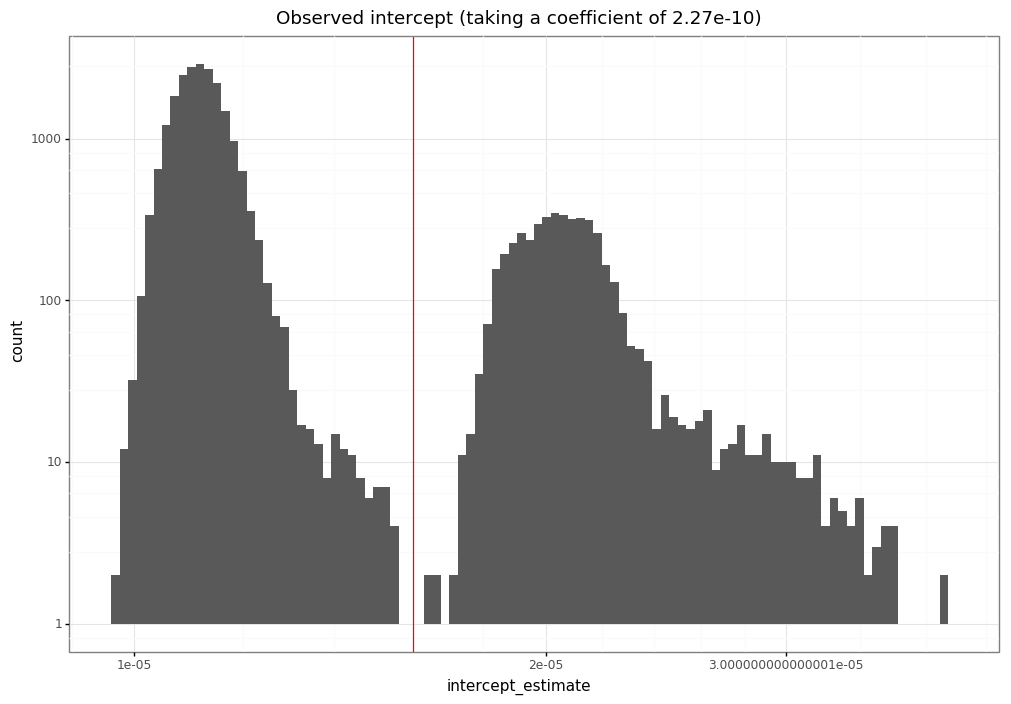

<ggplot: (8742382833086)>


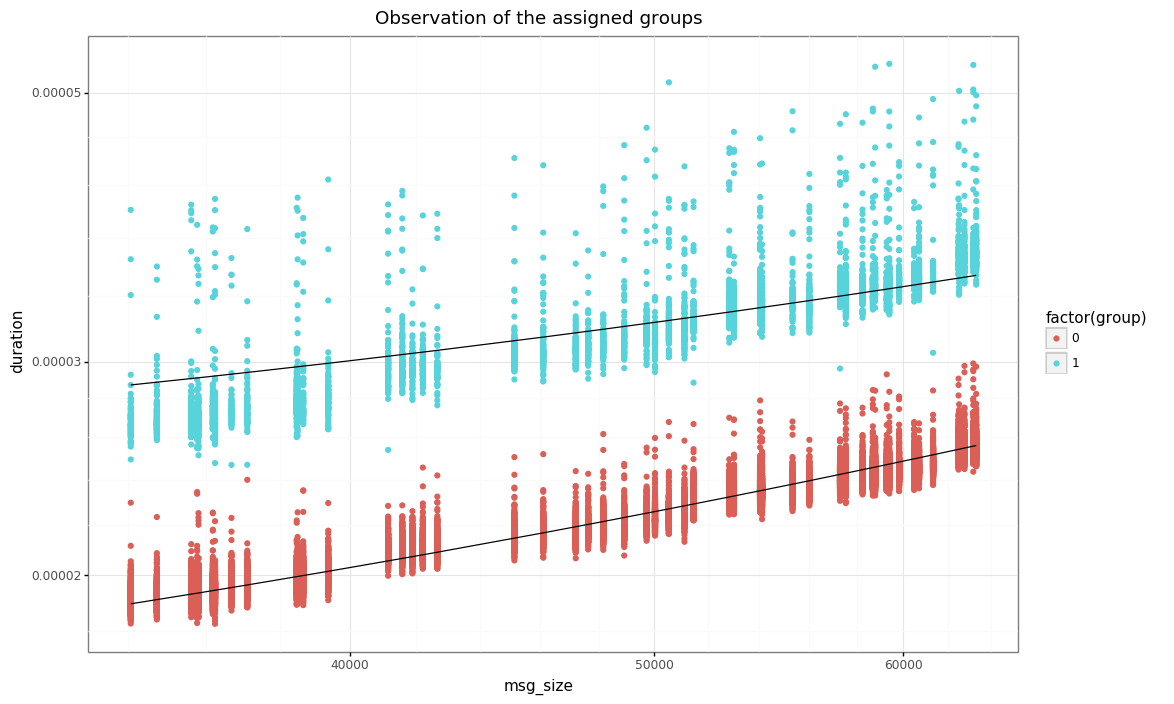

<ggplot: (8742382769840)>


<IPython.core.display.Math object>

In [51]:
min_x, max_x = breakpoints[3:5]
adhoc_reg = compute_mixture_regression(df_pingpong, min_x, max_x, [1.6e-5])
adhoc_reg

In [52]:
regressions_pingpong.append(adhoc_reg, min_x, max_x)

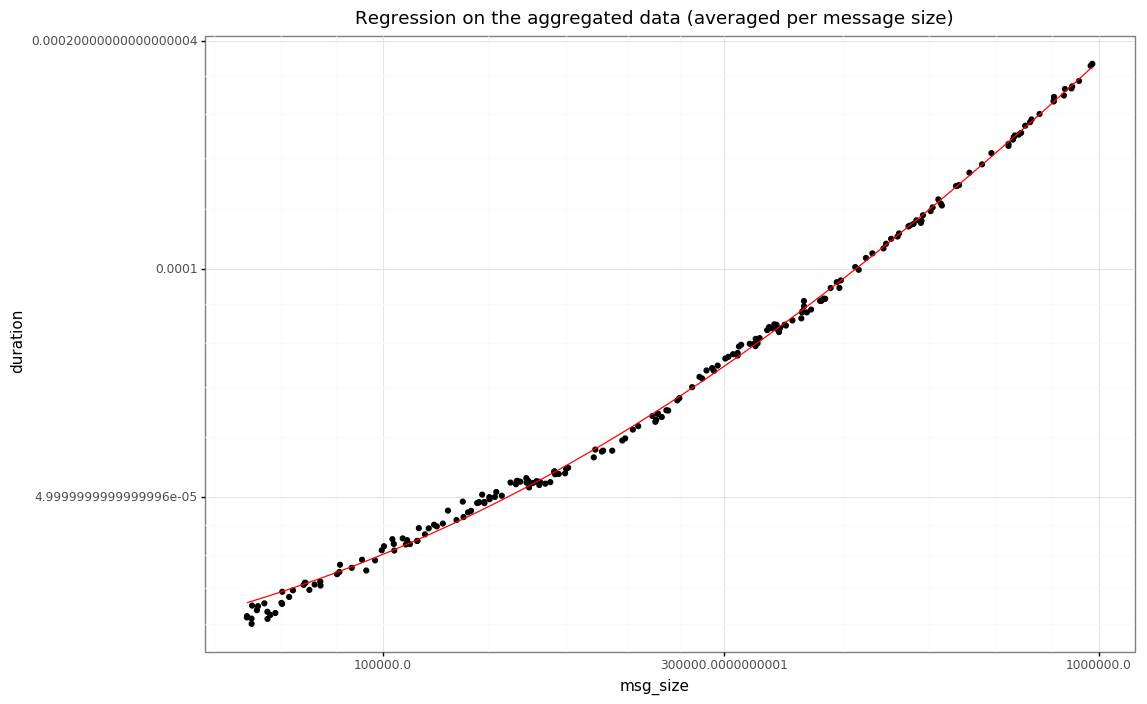

<ggplot: (8742334148749)>
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.352e+05
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.11e-311
Time:                        14:55:15   Log-Likelihood:                 2502.6
No. Observations:                 204   AIC:                            -5001.
Df Residuals:                     202   BIC:                            -4995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.585e-05   1.

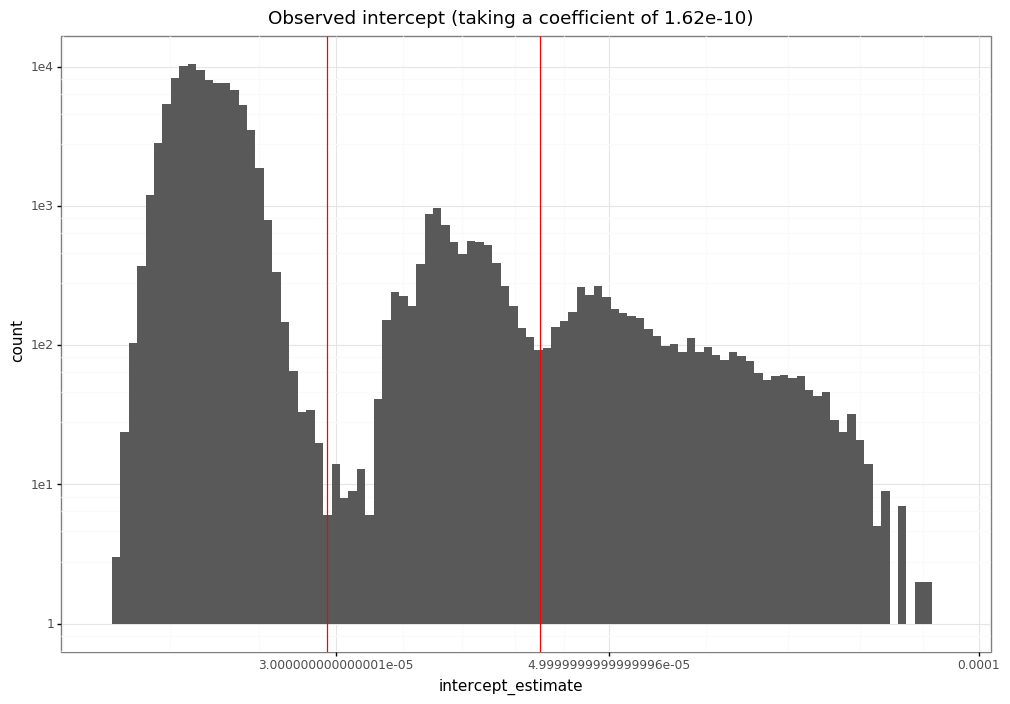

<ggplot: (8742322399005)>


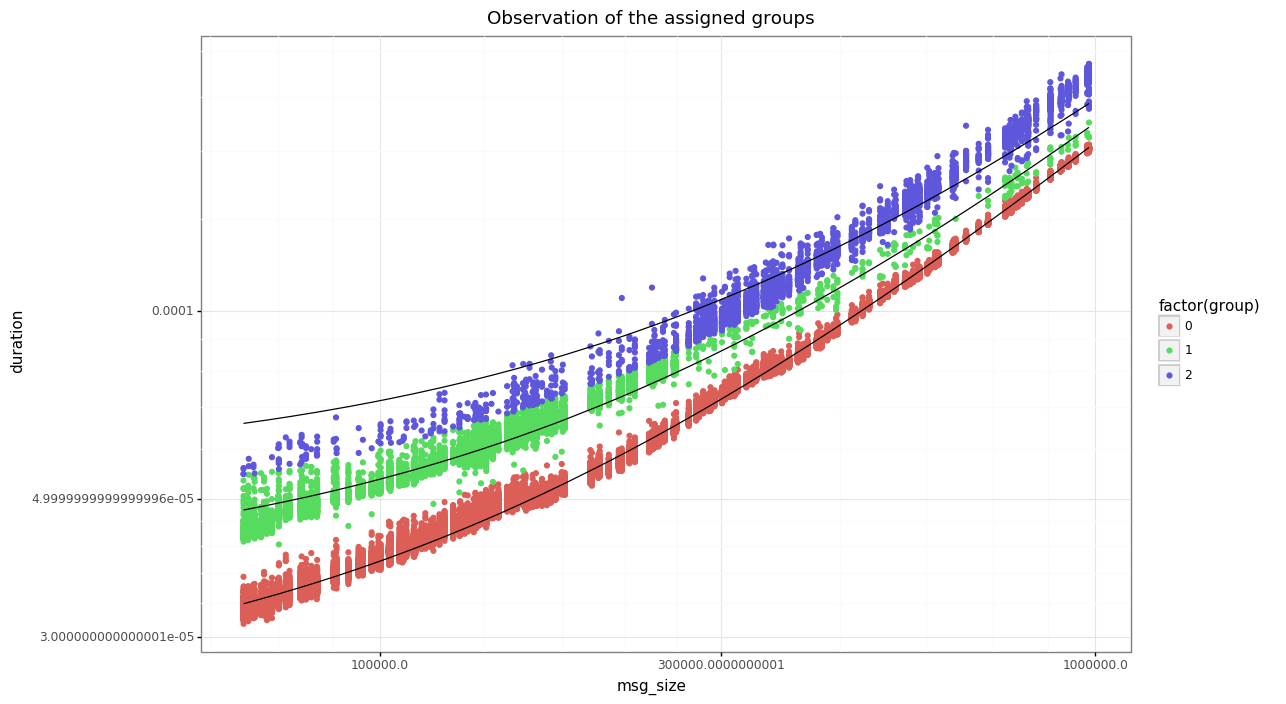

<ggplot: (-9223363294552006645)>


<IPython.core.display.Math object>

In [53]:
min_x, max_x = breakpoints[4:6]
adhoc_reg = compute_mixture_regression(df_pingpong, min_x, max_x, [2.95e-5, 4.4e-5])
adhoc_reg

In [54]:
regressions_pingpong.append(adhoc_reg, min_x, max_x)

In [55]:
regressions_pingpong

<IPython.core.display.Math object>

In [56]:
regressions_pingpong.pretty_c()

```c
double smpi_stochastic_intercept=-1, smpi_stochastic_coefficient=-1;
if(smpi_stochastic_size < 8133) {
    double mixtures_smpi_stochastic_intercept[2][3] = {
        {1.588091e-05, 3.229236e-06, 1.527473e-03},
        {2.974040e-06, 5.394214e-07, 9.984725e-01}
    };
    smpi_stochastic_intercept = random_mixture(2, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 4.923649e-10;
}
if(8133 <= smpi_stochastic_size && smpi_stochastic_size < 15831) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {1.614585e-05, 2.114452e-06, 1.631111e-02},
        {7.312389e-06, 7.114853e-07, 3.235111e-01},
        {5.066502e-06, 3.164576e-07, 6.601778e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 2.358957e-10;
}
if(15831 <= smpi_stochastic_size && smpi_stochastic_size < 33956) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {1.673856e-05, 2.628646e-06, 1.332143e-02},
        {7.792866e-06, 7.913409e-07, 3.277857e-01},
        {4.992295e-06, 3.344578e-07, 6.588929e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 2.250601e-10;
}
if(33956 <= smpi_stochastic_size && smpi_stochastic_size < 64000) {
    double mixtures_smpi_stochastic_intercept[2][3] = {
        {2.097540e-05, 2.477878e-06, 1.766154e-01},
        {1.120164e-05, 5.302334e-07, 8.233846e-01}
    };
    smpi_stochastic_intercept = random_mixture(2, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 2.274844e-10;
}
if(64000 <= smpi_stochastic_size) {
    double mixtures_smpi_stochastic_intercept[3][3] = {
        {5.554307e-05, 9.154800e-06, 4.042157e-02},
        {3.751200e-05, 2.476441e-06, 7.491176e-02},
        {2.350556e-05, 1.249375e-06, 8.846667e-01}
    };
    smpi_stochastic_intercept = random_mixture(3, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.621411e-10;
}

```

## Estimating the transfer distributions

In [57]:
transfer_model_synchronous  = regressions_pingpong/2 - regressions_recv
transfer_model_asynchronous = regressions_pingpong/2
transfer_model = SegmentedRegression()
for (dist1, min_x, max_x), (dist2, _, _) in zip(transfer_model_synchronous.segments, transfer_model_asynchronous.segments):
    if max_x != None and max_x <= threshold:  # synchronous part
        transfer_model.append(dist1, min_x, max_x)
    else:  # asynchronous part
        transfer_model.append(dist2, min_x, max_x)
transfer_model

<IPython.core.display.Math object>

In [58]:
transfer_model.pretty_c()

```c
double smpi_stochastic_intercept=-1, smpi_stochastic_coefficient=-1;
if(smpi_stochastic_size < 8133) {
    double mixtures_smpi_stochastic_intercept[8][3] = {
        {-1.394694e-06, 3.480694e-06, 5.501424e-07},
        {8.137891e-06, 3.363640e-06, 2.704517e-06},
        {1.209678e-05, 3.211502e-06, 2.173944e-04},
        {1.342570e-05, 3.207687e-06, 5.436709e-04},
        {-1.430156e-05, 1.406498e-06, 7.192301e-04},
        {-4.768977e-06, 1.084934e-06, 3.535757e-03},
        {-8.100882e-07, 4.204159e-07, 2.842112e-01},
        {5.188349e-07, 3.902064e-07, 7.107695e-01}
    };
    smpi_stochastic_intercept = random_mixture(8, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.617432e-10;
}
if(8133 <= smpi_stochastic_size && smpi_stochastic_size < 15831) {
    double mixtures_smpi_stochastic_intercept[8][3] = {
        {-1.003028e-05, 2.769973e-06, 1.924256e-04},
        {-1.227617e-05, 2.695679e-06, 7.853522e-04},
        {-1.648112e-06, 1.108598e-06, 8.046887e-04},
        {-3.893999e-06, 9.071519e-07, 3.284200e-03},
        {2.289979e-06, 7.097274e-07, 5.547979e-02},
        {4.337556e-06, 6.867247e-07, 1.403220e-01},
        {4.409276e-08, 3.124853e-07, 2.264313e-01},
        {2.091669e-06, 2.559783e-07, 5.727003e-01}
    };
    smpi_stochastic_intercept = random_mixture(8, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.353263e-11;
}
if(15831 <= smpi_stochastic_size && smpi_stochastic_size < 33956) {
    double mixtures_smpi_stochastic_intercept[8][3] = {
        {-9.047052e-06, 2.650173e-06, 3.912713e-04},
        {-1.956151e-06, 9.411392e-07, 9.746211e-04},
        {-1.184762e-05, 2.551285e-06, 1.573014e-03},
        {-4.756722e-06, 6.094133e-07, 3.918236e-03},
        {2.128024e-06, 8.740486e-07, 6.651611e-02},
        {5.268678e-06, 7.917645e-07, 1.313106e-01},
        {-6.725472e-07, 4.996023e-07, 2.674125e-01},
        {2.468107e-06, 3.354586e-07, 5.279037e-01}
    };
    smpi_stochastic_intercept = random_mixture(8, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 1.100266e-11;
}
if(33956 <= smpi_stochastic_size && smpi_stochastic_size < 64000) {
    double mixtures_smpi_stochastic_intercept[8][3] = {
        {-1.317950e-07, 3.402002e-06, 2.905839e-04},
        {6.689677e-06, 2.633276e-06, 1.262922e-03},
        {-9.905562e-06, 2.390582e-06, 2.709416e-03},
        {-3.084090e-06, 1.037020e-06, 1.177554e-02},
        {1.113079e-05, 2.528994e-06, 3.933313e-02},
        {1.637856e-05, 2.515890e-06, 5.597465e-02},
        {1.357027e-06, 7.328566e-07, 3.667438e-01},
        {6.604796e-06, 6.862728e-07, 5.219100e-01}
    };
    smpi_stochastic_intercept = random_mixture(8, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 6.319565e-12;
}
if(64000 <= smpi_stochastic_size) {
    double mixtures_smpi_stochastic_intercept[2][3] = {
        {2.575923e-05, 2.313502e-06, 4.061920e-02},
        {1.175278e-05, 8.834412e-07, 9.593808e-01}
    };
    smpi_stochastic_intercept = random_mixture(2, mixtures_smpi_stochastic_intercept);
    smpi_stochastic_coefficient = 8.107053e-11;
}

```

## Verification: generating the ping-pong durations

In [59]:
small_size_model = transfer_model*2 + regressions_recv*2
large_size_model = transfer_model*2

pingpong_generated = pandas.DataFrame(dict(msg_size=df_pingpong.sample(n=100000).msg_size))
pingpong_generated['duration'] = -1
pingpong_generated.loc[pingpong_generated.msg_size <= threshold, 'duration'] = pingpong_generated.apply(lambda row: small_size_model.sample(row['msg_size']), axis=1)
pingpong_generated.loc[pingpong_generated.msg_size >  threshold, 'duration'] = pingpong_generated.apply(lambda row: large_size_model.sample(row['msg_size']), axis=1)
pingpong_generated.head()

msg_size  duration
309167     77895  0.000037
56248      77429  0.000036
41712      15442  0.000011
171299     65597  0.000051
81915        130  0.000003

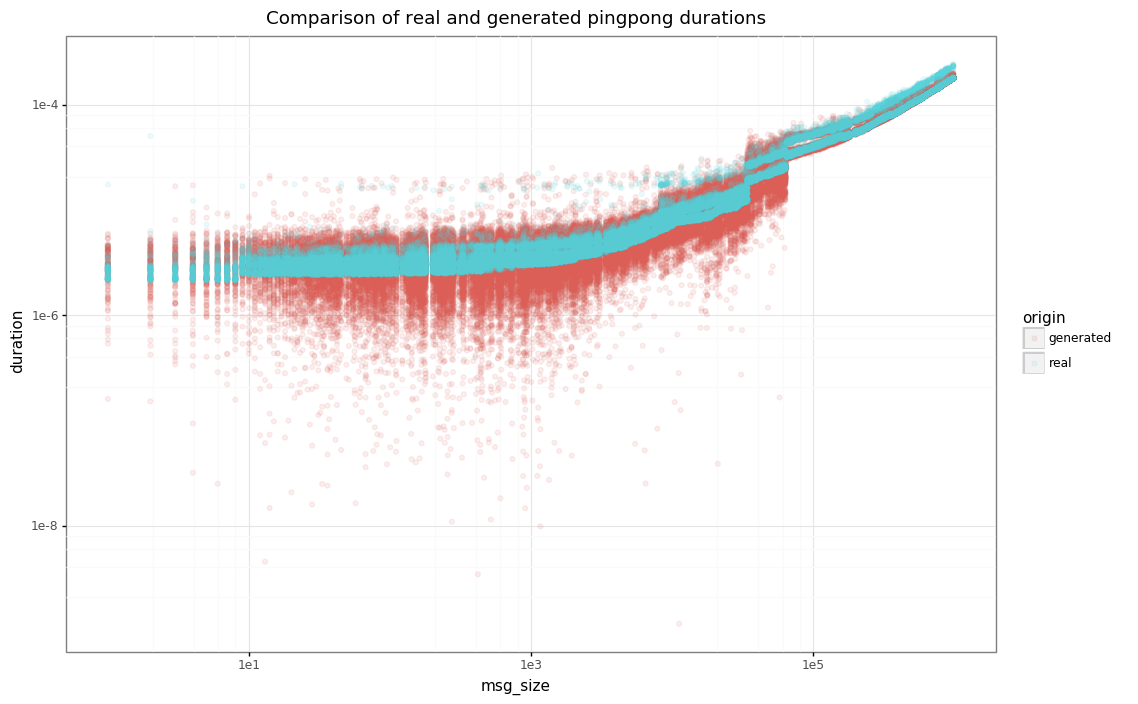

<ggplot: (-9223363294520601028)>

In [60]:
df_pingpong['origin'] = 'real'
pingpong_generated['origin'] = 'generated'
tmp = pandas.concat([pingpong_generated, df_pingpong.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated pingpong durations')
plot

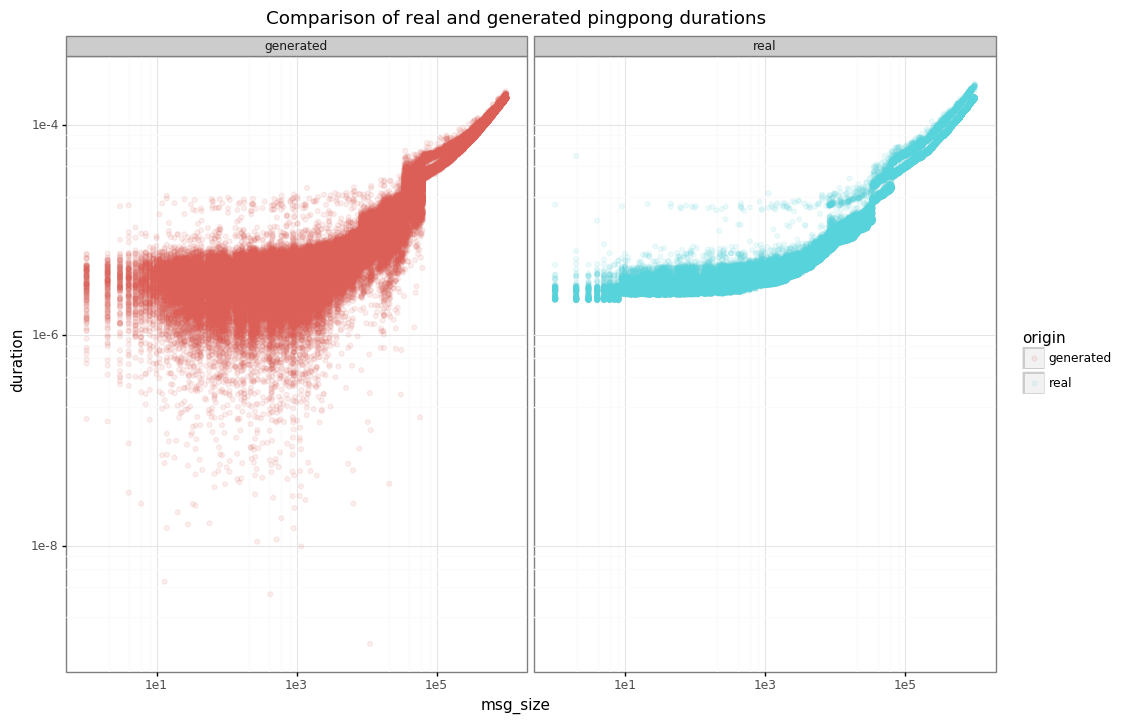

<ggplot: (-9223363294472128231)>

In [61]:
plot + facet_wrap('origin')

## Testing with a half-normal

In [62]:
for model in [small_size_model, large_size_model]:
    for segment, _, _ in model.segments:
        for mode, _ in segment.intercept.modes:
            mode.half = True

pingpong_generated.loc[pingpong_generated.msg_size <= threshold, 'duration'] = pingpong_generated.apply(lambda row: small_size_model.sample(row['msg_size']), axis=1)
pingpong_generated.loc[pingpong_generated.msg_size >  threshold, 'duration'] = pingpong_generated.apply(lambda row: large_size_model.sample(row['msg_size']), axis=1)
pingpong_generated.head()

msg_size  duration     origin
309167     77895  0.000035  generated
56248      77429  0.000049  generated
41712      15442  0.000007  generated
171299     65597  0.000033  generated
81915        130  0.000005  generated

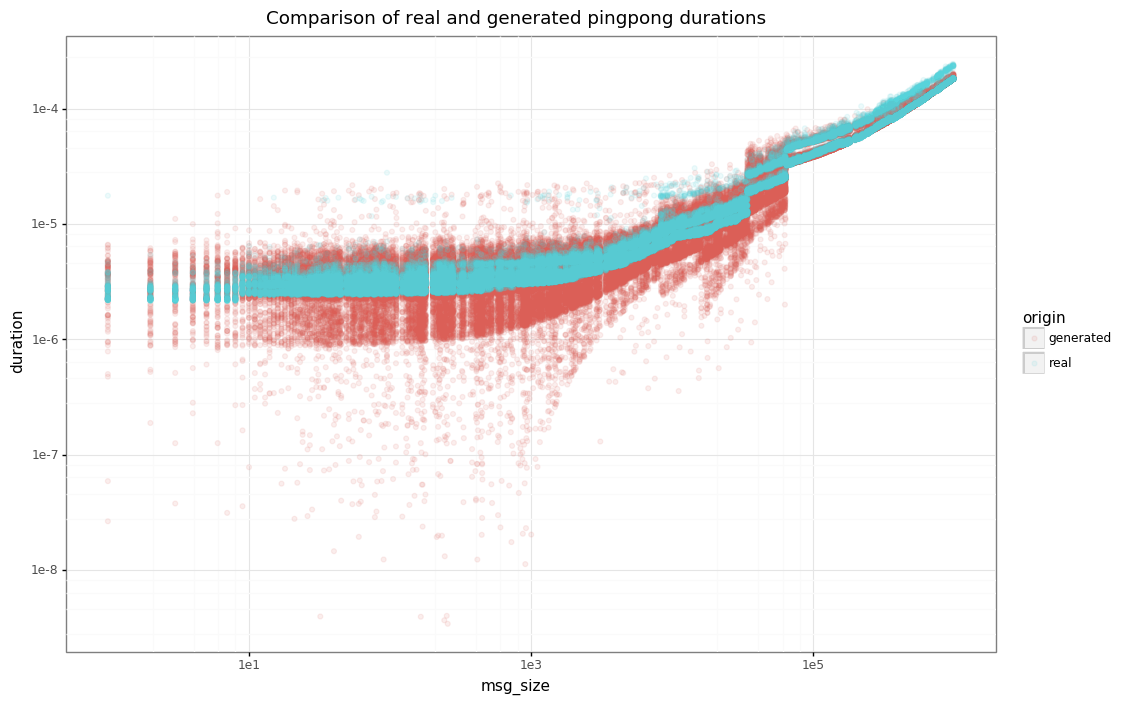

<ggplot: (8742302790099)>

In [63]:
df_pingpong['origin'] = 'real'
pingpong_generated['origin'] = 'generated'
tmp = pandas.concat([pingpong_generated, df_pingpong.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated pingpong durations')
plot

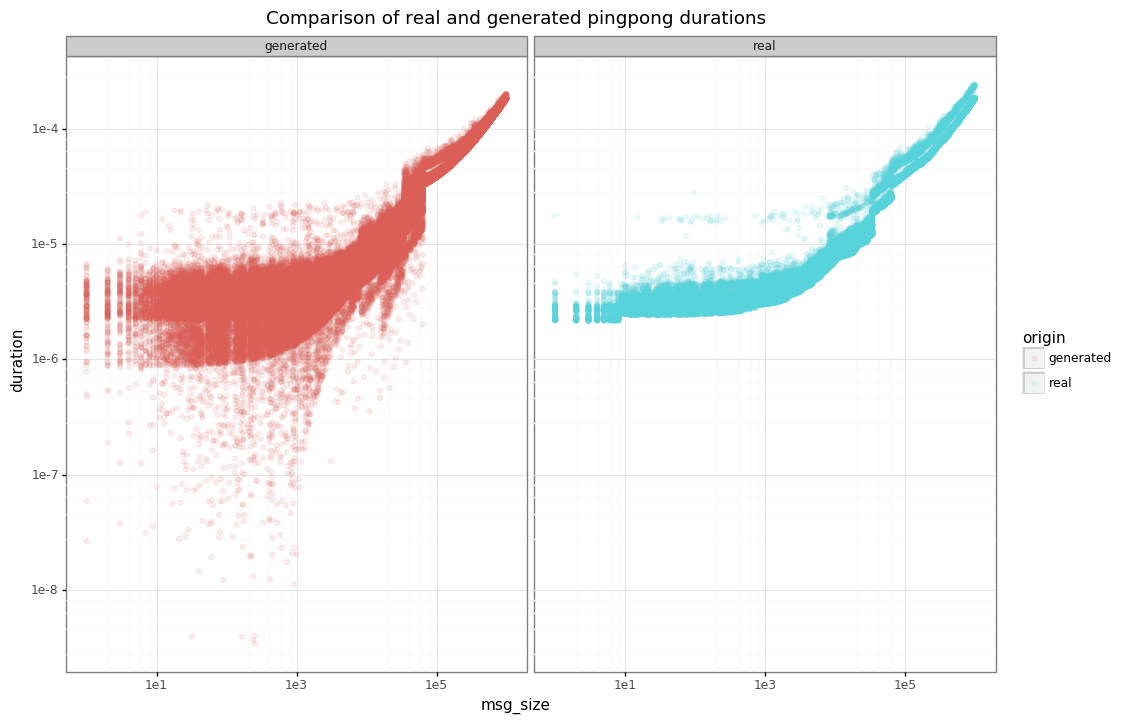

<ggplot: (-9223363294552807729)>

In [64]:
plot + facet_wrap('origin')

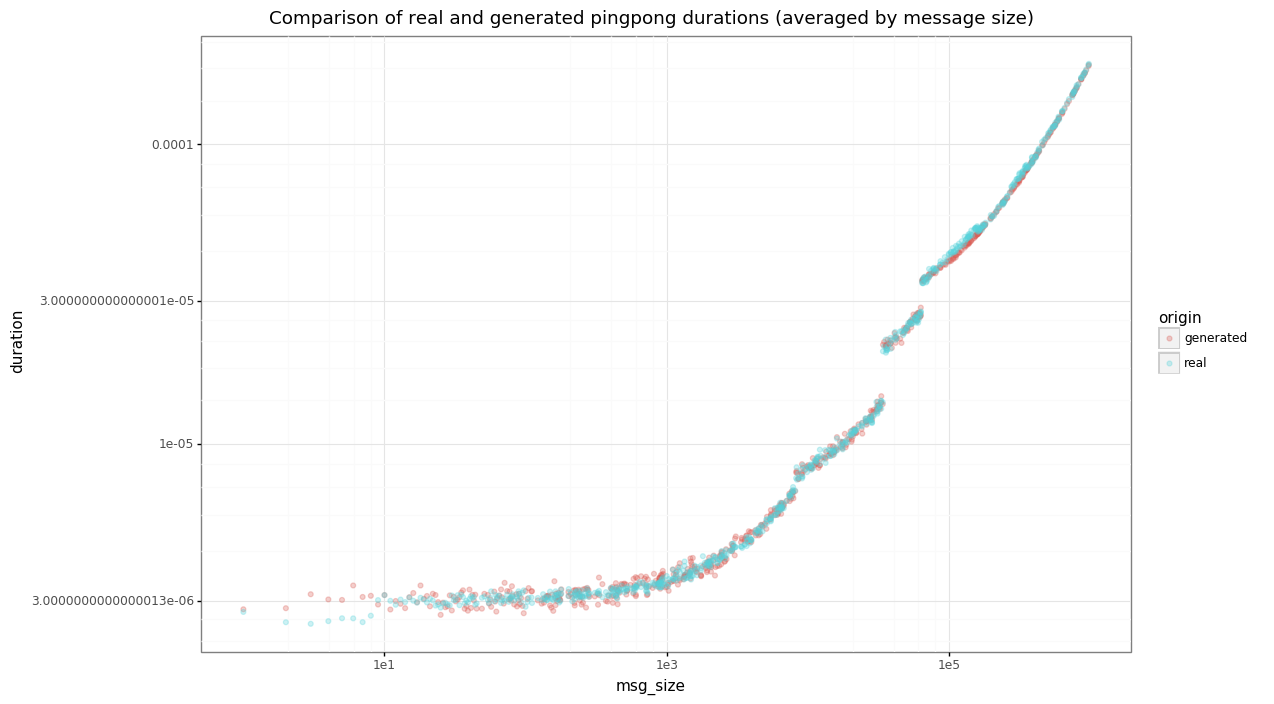

<ggplot: (-9223363294560709127)>

In [65]:
tmp_grouped = tmp.groupby(['origin', 'msg_size'])[['duration']].mean().reset_index()
plot = ggplot(tmp_grouped, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.3)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated pingpong durations (averaged by message size)')
plot

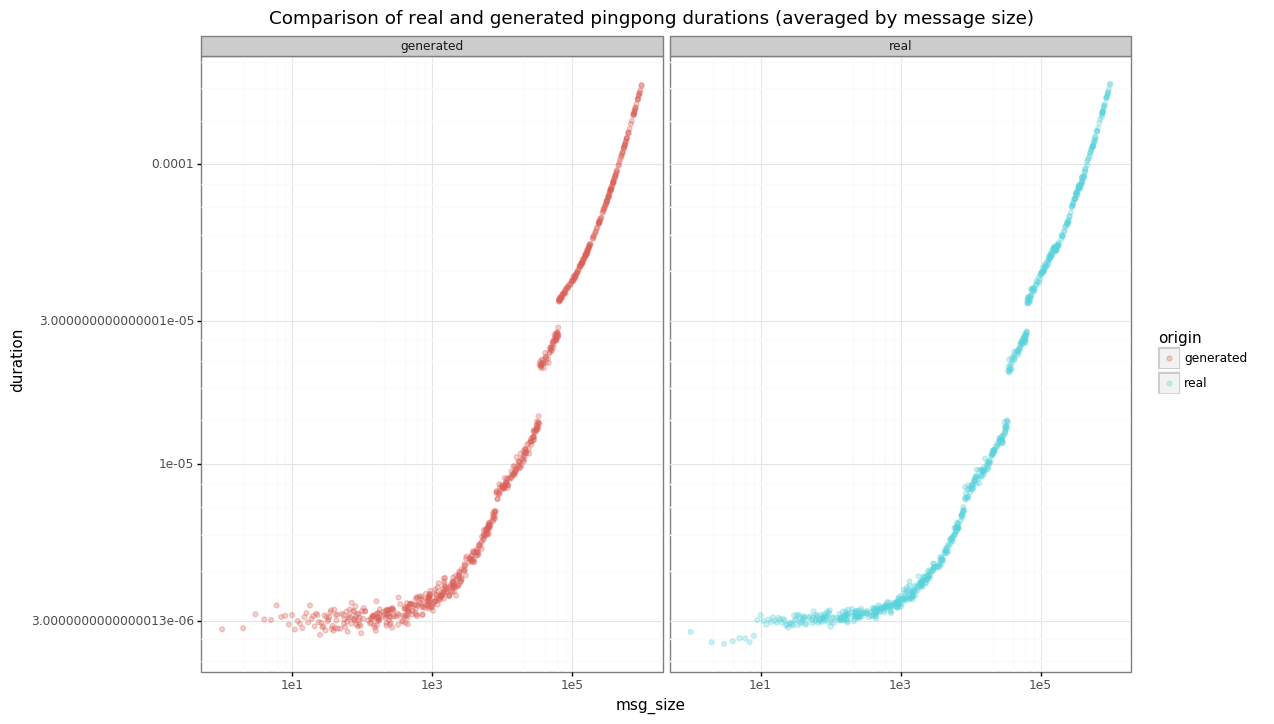

<ggplot: (8742301968069)>

In [66]:
plot + facet_wrap('origin')

In [67]:
import math
def plot_fixed_size(msg_size):
    msg_size = df_pingpong[df_pingpong.msg_size >= msg_size].msg_size.min()
    if math.isnan(msg_size):
        msg_size = df_pingpong.msg_size.max()
    pingpong_generated = pandas.DataFrame(dict(msg_size=[msg_size]*len(df_pingpong[df_pingpong.msg_size == msg_size])))
    pingpong_generated['duration'] = -1
    pingpong_generated.loc[pingpong_generated.msg_size <= threshold, 'duration'] = pingpong_generated.apply(lambda row: small_size_model.sample(row['msg_size']), axis=1)
    pingpong_generated.loc[pingpong_generated.msg_size >  threshold, 'duration'] = pingpong_generated.apply(lambda row: large_size_model.sample(row['msg_size']), axis=1)
    pingpong_generated['origin'] = 'generated'
    tmp = pandas.concat([pingpong_generated, df_pingpong[df_pingpong.msg_size == msg_size]])
    plot = ggplot(tmp, aes(x='duration', color='origin')) + geom_histogram(bins=20) + theme_bw()
    return plot + facet_wrap('origin') + ggtitle('Distribution of the durations for message size %d' % msg_size)

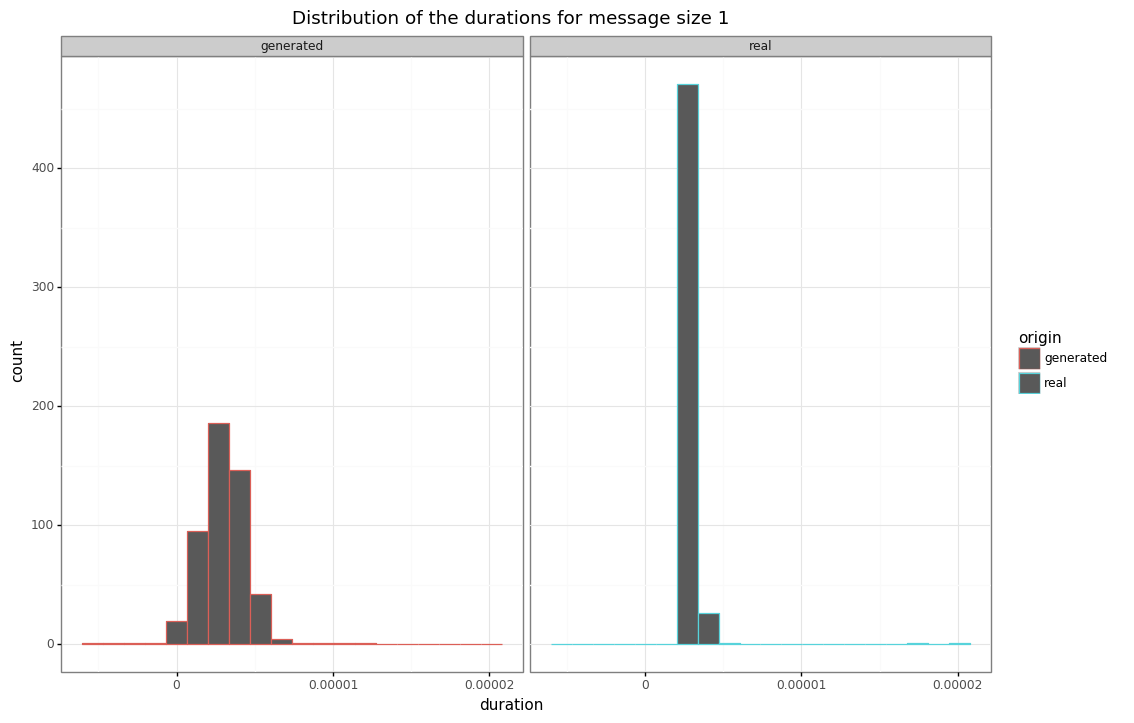

<ggplot: (-9223363294553090230)>


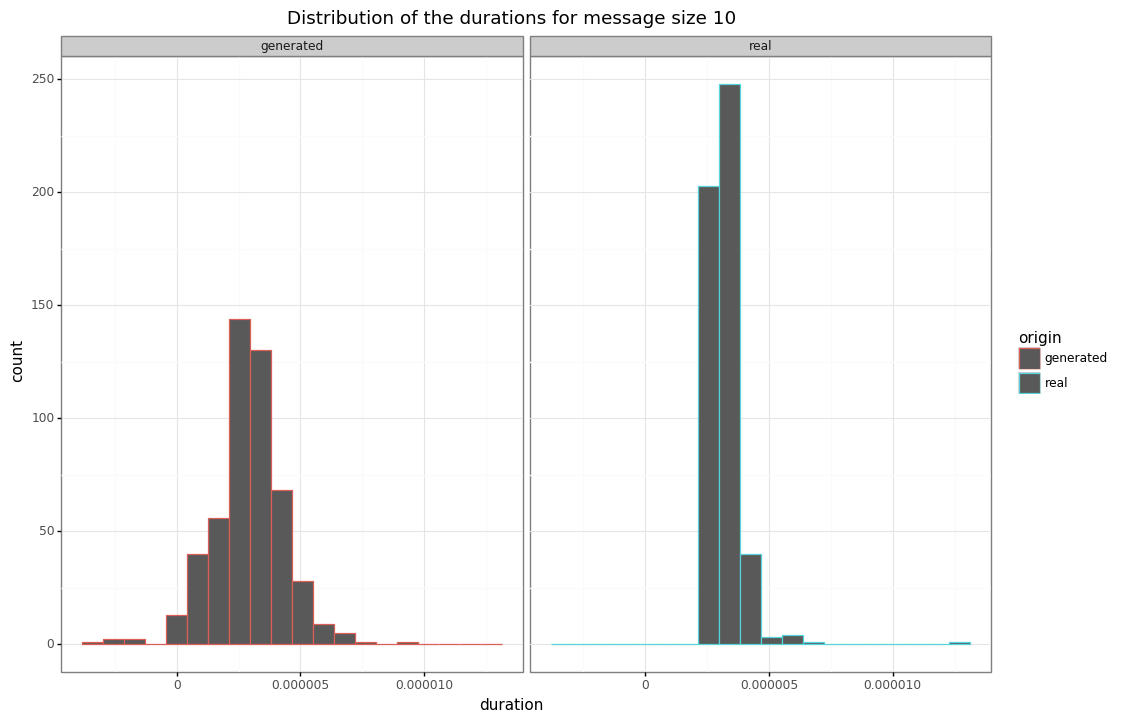

<ggplot: (8742301546083)>


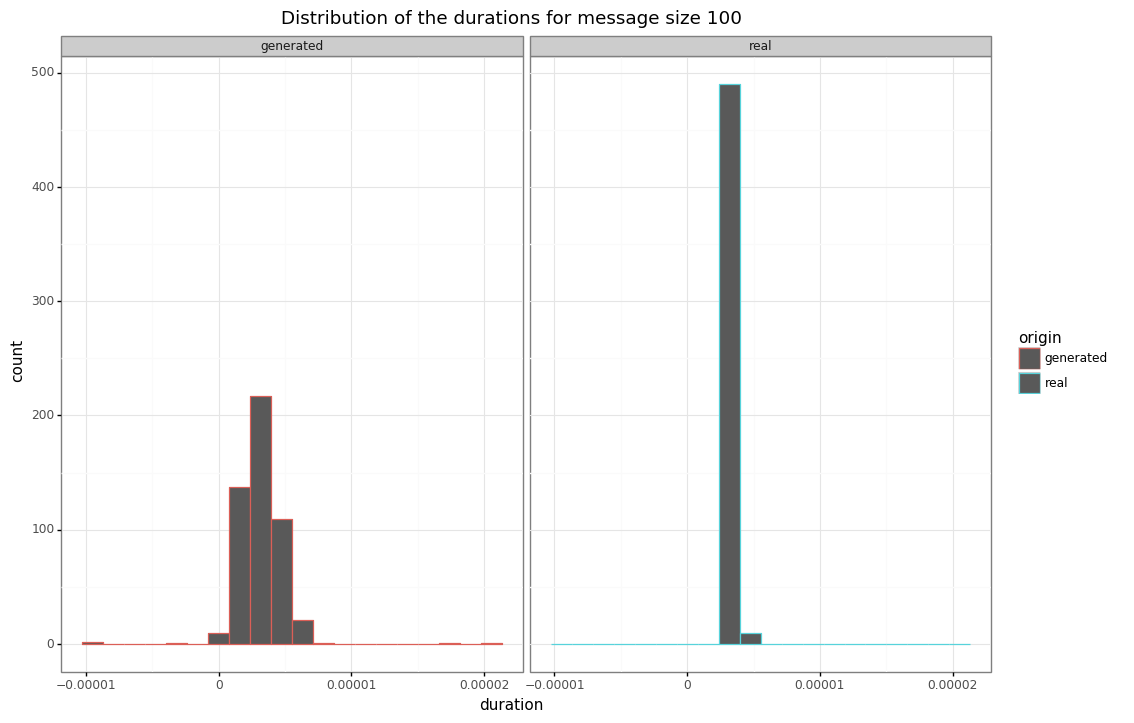

<ggplot: (8742294061183)>


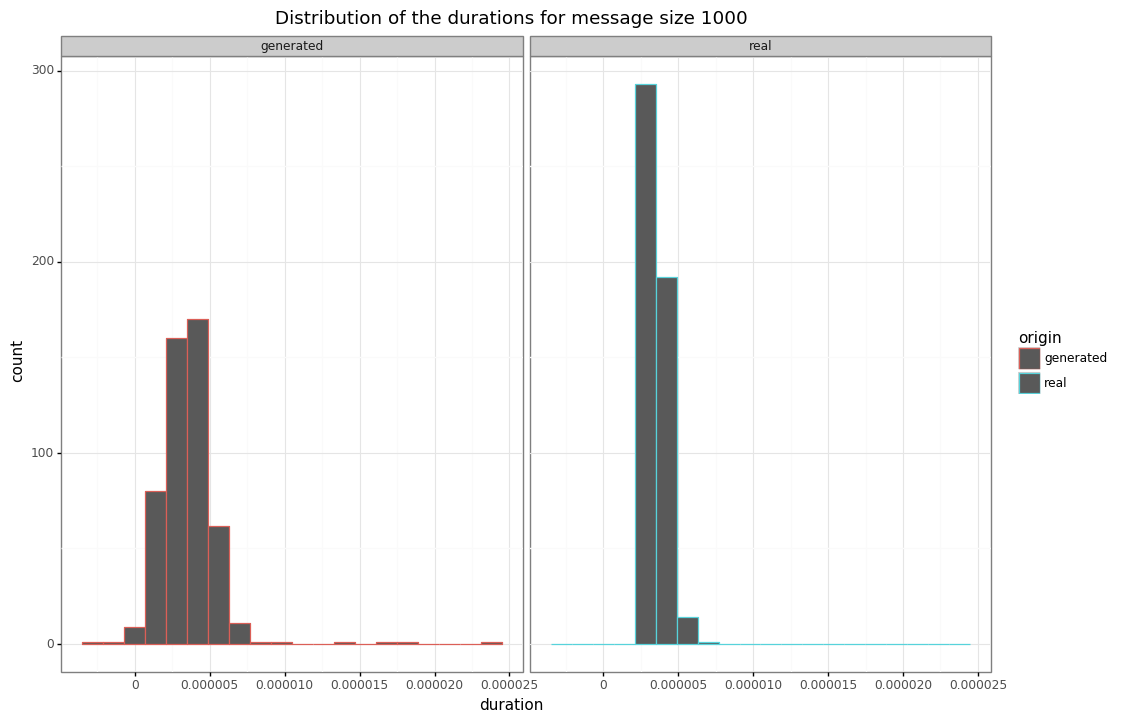

<ggplot: (-9223363294553229701)>


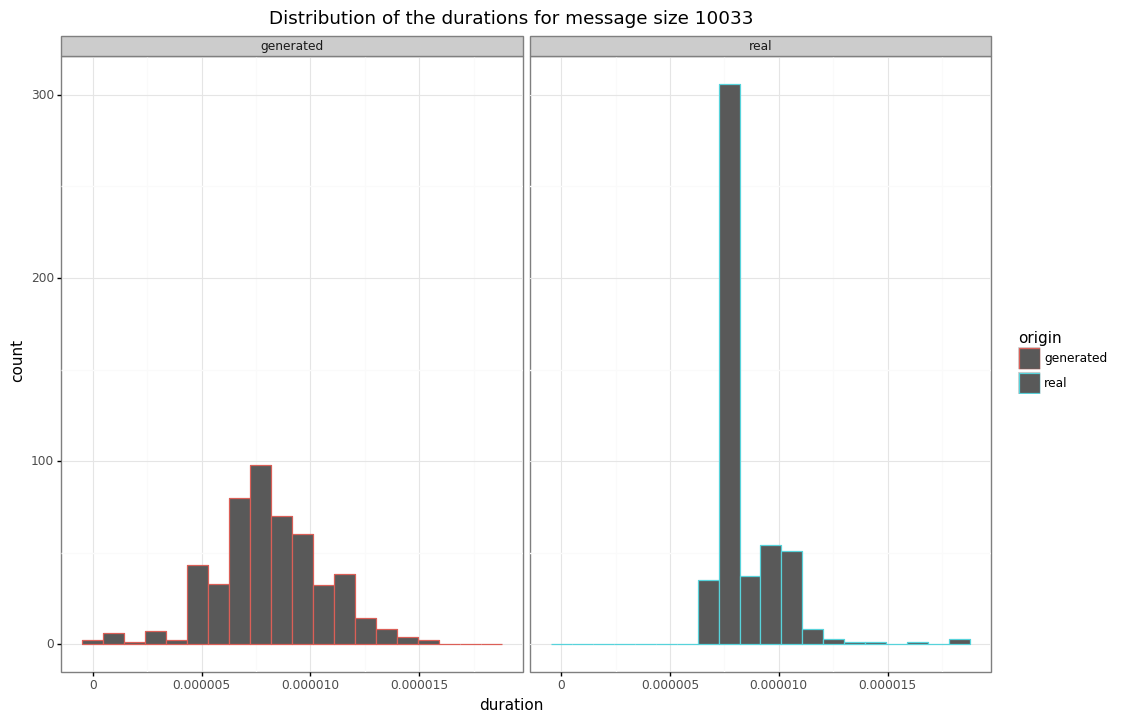

<ggplot: (8742301919408)>


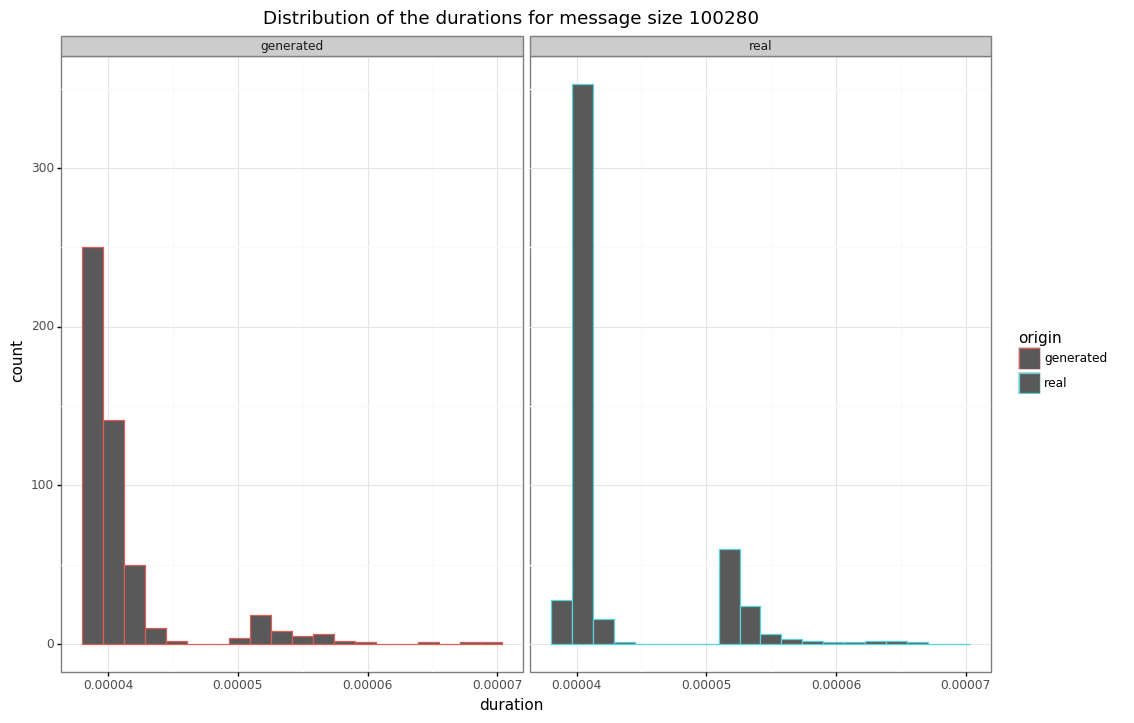

<ggplot: (-9223363294558801727)>


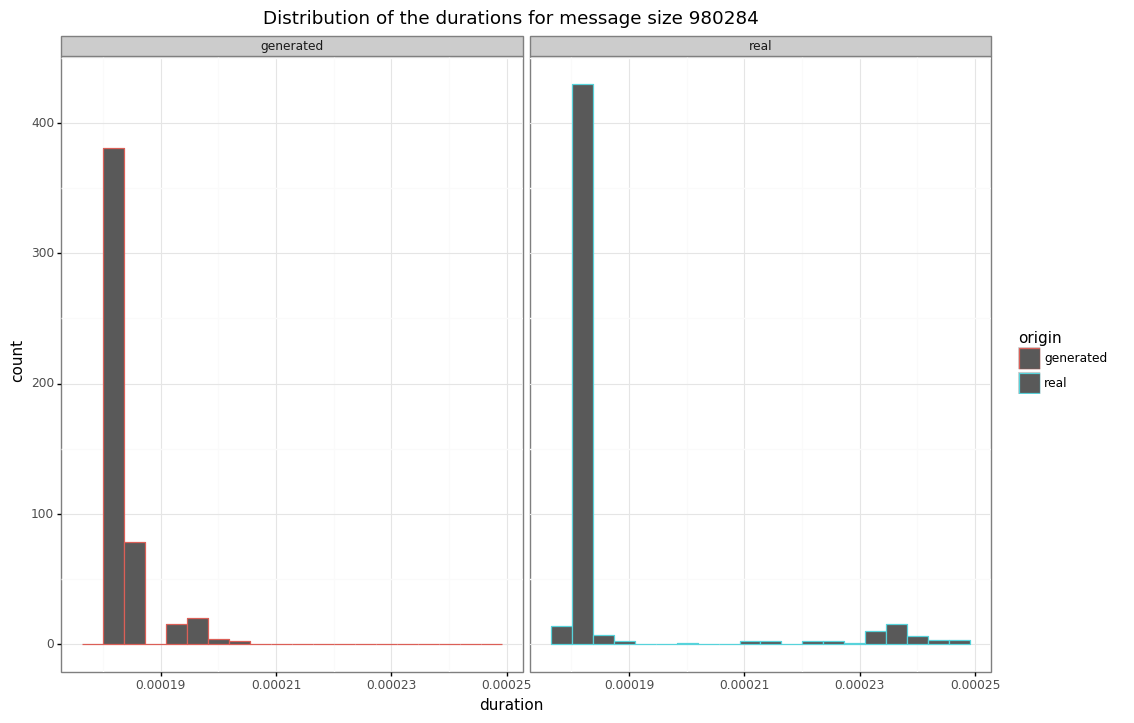

<ggplot: (-9223363294553205865)>


In [68]:
for i in range(7):
    print(plot_fixed_size(10**i))